# Appendix C
#### Some people like $S_8$, the others $\sigma_8$, the others $A_s$
#### Analysis again using $S_8$
#### This content corresponds to Appendix C of my thesis

# Part 1. Enviroment setting
#### Again and again
#### It was before one codes and actually now I am writing separately for readability.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
#import IPython
#print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

In [2]:
#%matplotlib notebook
import os
os.chdir("/home/r/R.Kanaki/Masterarbeit/מייַ_2023/prior_consideration")
import healpy as heal
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from healpy_networks_custom import HealpyGCNN
import healpy_layers_custom as hp_layer
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
from standard_2D import Standardize_Min_Max_2D, Rescale_MSE_Min_Max_2D
import build_model
from Loss_mean import MyLoss
from livelossplot import PlotLossesKeras
from cov_by_hand import cov, chisq
import pandas as pd
import tensorflow as tf
tf.keras.backend.clear_session()

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [15]:
training_data_lognormal_1      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_lognormal.npz')
training_data_lognormal_2      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_lognormal.npz')
training_data_Gauss_1          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_Gauss.npz')
training_data_Gauss_2          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_Gauss.npz')
testing_data_T17               = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/bin34/T17_downgraded_to_128.npz')
testing_data_lognormal_1       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_lognormal.npz')
testing_data_lognormal_2       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_lognormal.npz')
testing_data_Gauss_1           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_Gauss.npz')
testing_data_Gauss_2           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_Gauss.npz')
validation_data_Gauss          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_Gauss.npz')
validation_data_lognormal      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_lognormal.npz')

In [16]:
## For lognormal realization of flask maps, cosmology is same 
train_data_lognormal_1           = training_data_lognormal_1['lognormal_map']
train_data_lognormal_2           = training_data_lognormal_2['lognormal_map']
train_data_Gauss_1               = training_data_Gauss_1['lognormal_map']
train_data_Gauss_2               = training_data_Gauss_2['lognormal_map']
val_data_lognormal               = validation_data_lognormal['lognormal_map']
val_data_Gauss                   = validation_data_Gauss['lognormal_map']
test_data_T17                    = testing_data_T17['lognormal_map']
test_data_lognormal_1            = testing_data_lognormal_1['lognormal_map']
test_data_lognormal_2            = testing_data_lognormal_2['lognormal_map']
test_data_Gauss_1                = testing_data_Gauss_1['lognormal_map']
test_data_Gauss_2                = testing_data_Gauss_2['lognormal_map']

train_label_Omega_M_Gauss       = training_data_Gauss_1['Omega_M']
train_label_sigma_8_Gauss       = training_data_Gauss_1['sigma_8']
val_label_Omega_M_Gauss         = validation_data_Gauss['Omega_M']
val_label_sigma_8_Gauss         = validation_data_Gauss['sigma_8']
train_label_Omega_M_lognormal   = training_data_lognormal_1['Omega_M']
train_label_sigma_8_lognormal   = training_data_lognormal_1['sigma_8']
val_label_Omega_M_lognormal     = validation_data_lognormal['Omega_M']
val_label_sigma_8_lognormal     = validation_data_lognormal['sigma_8']
test_label_Omega_M_T17          = testing_data_T17['Omega_M']
test_label_sigma_8_T17          = testing_data_T17['sigma_8']
test_label_Omega_M_lognormal    = testing_data_lognormal_1['Omega_M']
test_label_sigma_8_lognormal    = testing_data_lognormal_1['sigma_8']
test_label_Omega_M_Gauss        = testing_data_Gauss_1['Omega_M']
test_label_sigma_8_Gauss        = testing_data_Gauss_1['sigma_8']

In [17]:
fiducial_Omega_M = test_label_Omega_M_T17[0]
fiducial_sigma_8 = test_label_sigma_8_T17[0]

In [18]:
train_labels_Gauss          = np.zeros((10000,2))
train_labels_lognormal      = np.zeros((10000,2))
validation_labels_Gauss     = np.zeros((2500,2))
validation_labels_lognormal = np.zeros((2500,2))
test_labels_T17             = np.zeros((108,2))
test_labels_Gauss           = np.zeros((300,2))
test_labels_lognormal       = np.zeros((300,2))
for i in range(len(train_label_Omega_M_Gauss)):
    train_labels_Gauss[i]          = np.array((train_label_Omega_M_Gauss[i], train_label_sigma_8_Gauss[i]))
    train_labels_lognormal[i]      = np.array((train_label_Omega_M_lognormal[i], train_label_sigma_8_lognormal[i]))
for i in range(len(val_label_sigma_8_Gauss)):
    validation_labels_Gauss[i]     = np.array((val_label_Omega_M_Gauss[i], val_label_sigma_8_Gauss[i]))
    validation_labels_lognormal[i] = np.array((val_label_Omega_M_lognormal[i], val_label_sigma_8_lognormal[i]))
for i in range(len(test_label_Omega_M_T17)):
    test_labels_T17[i]             =np.array((test_label_Omega_M_T17[i], test_label_sigma_8_T17[i]))
for i in range(len(test_label_Omega_M_lognormal)):
    test_labels_lognormal[i]       =np.array((test_label_Omega_M_lognormal[i], test_label_sigma_8_lognormal[i]))
    test_labels_Gauss[i]           =np.array((test_label_Omega_M_Gauss[i], test_label_sigma_8_Gauss[i]))

In [19]:
def data_preprocessing_train(maps):
    outputs = maps.astype(np.float32)[..., None]
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_test(maps):
    outputs = maps.astype(np.float32)[..., None]
    return outputs

def data_preprocessing_label_train(label):
    outputs = label.astype(np.float32)
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_label_test(label):
    outputs = label.astype(np.float32)
    return outputs

In [20]:
lognormal_train_1        = data_preprocessing_train(train_data_lognormal_1)
lognormal_train_2        = data_preprocessing_train(train_data_lognormal_2)
lognormal_val            = data_preprocessing_train(val_data_lognormal)
Gauss_train_1            = data_preprocessing_train(train_data_Gauss_1)
Gauss_train_2            = data_preprocessing_train(train_data_Gauss_2)
Gauss_val                = data_preprocessing_train(val_data_Gauss)
T17_test                 = data_preprocessing_test(test_data_T17)
lognormal_test_1         = data_preprocessing_test(test_data_lognormal_1)
lognormal_test_2         = data_preprocessing_test(test_data_lognormal_2)
Gauss_test_1             = data_preprocessing_test(test_data_Gauss_1)
Gauss_test_2             = data_preprocessing_test(test_data_Gauss_2)
labels_train_lognormal   = data_preprocessing_label_train(train_labels_lognormal)
labels_val_lognormal     = data_preprocessing_label_train(validation_labels_lognormal)
labels_train_Gauss       = data_preprocessing_label_train(train_labels_Gauss)
labels_val_Gauss         = data_preprocessing_label_train(validation_labels_Gauss)
labels_test_T17          = data_preprocessing_label_test(test_labels_T17)
labels_test_lognormal    = data_preprocessing_label_test(test_labels_lognormal)
labels_test_Gauss        = data_preprocessing_label_test(test_labels_Gauss)

In [21]:
%matplotlib inline

In [23]:
nside=128
npix = heal.nside2npix(nside)
indices = np.arange(npix)

In [24]:
def create_lognormal_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_lognormal_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model

In [25]:
loss_fc=MyLoss()
path_lognormal_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver5'
callbacks_lognormal = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_lognormal_2 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver7'
callbacks_lognormal_2 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver11'
callbacks_Gauss_1 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_2='/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver12'
callbacks_Gauss = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.0001,
    decay_steps = 3000,
    end_learning_rate=0.00001,
    power=1.0,
    cycle=False,
    name=None
)

In [26]:
checkpoint_path_lognormal_1 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_1/checkpoints/lognormal_weights.h5'
checkpoint_path_lognormal_2 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_2/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_1     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_1/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_2     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_2/checkpoints/lognormal_weights.h5'

In [37]:
from keras import backend as K 
model_Gauss_1 = create_Gaussian_model_1(nside, indices)
model_Gauss_1.summary()
model_Gauss_1.load_weights(checkpoint_path_Gauss_1 , by_name=True)
model_Gauss_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_1            = model_Gauss_1.predict(T17_test)
prediction_lognormal_1_Gauss_1    = model_Gauss_1.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_1        = model_Gauss_1.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_1    = model_Gauss_1.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_1        = model_Gauss_1.predict(Gauss_test_2)
prediction_val_Gauss_1            = model_Gauss_1.predict(Gauss_val)
print(prediction_val_Gauss_1[1,0])
K.clear_session()
model_Gauss_2 = create_Gaussian_model_2(nside, indices)
model_Gauss_2.summary()
model_Gauss_2.load_weights(checkpoint_path_Gauss_2 , by_name=True)
model_Gauss_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_2            = model_Gauss_2.predict(T17_test)
prediction_lognormal_1_Gauss_2    = model_Gauss_2.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_2        = model_Gauss_2.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_2    = model_Gauss_2.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_2        = model_Gauss_2.predict(Gauss_test_2)
prediction_val_Gauss_2            = model_Gauss_2.predict(Gauss_val)
print(prediction_val_Gauss_2[1,0])
K.clear_session()
model_lognormal_1 = create_lognormal_model_1(nside, indices)
model_lognormal_1.summary()
model_lognormal_1.load_weights(checkpoint_path_lognormal_1, by_name=True)
model_lognormal_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_1            = model_lognormal_1.predict(T17_test)
prediction_lognormal_1_lognormal_1    = model_lognormal_1.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_1        = model_lognormal_1.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_1    = model_lognormal_1.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_1        = model_lognormal_1.predict(Gauss_test_2)
prediction_val_lognormal_1            = model_lognormal_1.predict(Gauss_val)
print(prediction_val_lognormal_1[1,0])
K.clear_session()
model_lognormal_2 = create_lognormal_model_2(nside, indices)
model_lognormal_2.summary()
model_lognormal_2.load_weights(checkpoint_path_lognormal_2, by_name=True)
model_lognormal_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_2            = model_lognormal_2.predict(T17_test)
prediction_lognormal_1_lognormal_2    = model_lognormal_2.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_2        = model_lognormal_2.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_2    = model_lognormal_2.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_2        = model_lognormal_2.predict(Gauss_test_2)
prediction_val_lognormal_2            = model_lognormal_2.predict(Gauss_val)
print(prediction_val_lognormal_2[1,0])
K.clear_session()

Detected a reduction factor of 64.0, the input with nside 128 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 chebyshev (Chebyshev)       (None, 196608, 10)        50        
                                                                 
 healpy_pool (HealpyPool)    (None, 49152, 10)         0         
                                                                 
 chebyshev_1 (Chebyshev)     (None, 49152, 10)         500       
                                                                 
 healpy_pool_1 (HealpyPool)  (None, 12288, 10)         0         
                                                                 
 chebyshev_2 (Chebyshev)     (None, 12288, 10)         500       
                                                                 
 healpy

In [28]:
path_loss_Gauss_1     ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/Gauss_v11_loss_metrics_history.csv'
path_loss_Gauss_2     ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/Gauss_v12_loss_metrics_history.csv'
path_loss_lognormal_1 ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/lognormal_v5_loss_metrics_history.csv'
path_loss_lognormal_2 ='/home/r/R.Kanaki/Master_Arbeit_Final/Loss/lognormal_v7_loss_metrics_history.csv'
losses_Gauss_1     = pd.read_csv(path_loss_Gauss_1)
losses_Gauss_2     = pd.read_csv(path_loss_Gauss_2)
losses_lognormal_1 = pd.read_csv(path_loss_lognormal_1)
losses_lognormal_2 = pd.read_csv(path_loss_lognormal_2)

In [27]:
Omega_M_x                 =np.linspace(np.amax(labels_val_Gauss[:,0]), np.amin(labels_val_Gauss[:,0]),100)
sigma_8_x                 =np.linspace(np.amax(labels_val_Gauss[:,1]), np.amin(labels_val_Gauss[:,1]),100)
Omega_M_MSE_Gauss_1       = 1. / len(prediction_val_Gauss_1[:,0]) * np.sum((labels_val_Gauss[:,0]-prediction_val_Gauss_1[:,0])**2)
sigma_8_MSE_Gauss_1       = 1. / len(prediction_val_Gauss_1[:,1]) * np.sum((labels_val_Gauss[:,1]-prediction_val_Gauss_1[:,1])**2)
Omega_M_MSE_Gauss_2       = 1. / len(prediction_val_Gauss_2[:,0]) * np.sum((labels_val_Gauss[:,0]-prediction_val_Gauss_2[:,0])**2)
sigma_8_MSE_Gauss_2       = 1. / len(prediction_val_Gauss_2[:,1]) * np.sum((labels_val_Gauss[:,1]-prediction_val_Gauss_2[:,1])**2)
Omega_M_MSE_lognormal_1   = 1. / len(prediction_val_lognormal_1[:,0]) * np.sum((labels_val_lognormal[:,0]-prediction_val_lognormal_1[:,0])**2)
sigma_8_MSE_lognormal_1   = 1. / len(prediction_val_lognormal_1[:,1]) * np.sum((labels_val_lognormal[:,1]-prediction_val_lognormal_1[:,1])**2)
Omega_M_MSE_lognormal_2   = 1. / len(prediction_val_lognormal_2[:,0]) * np.sum((labels_val_lognormal[:,0]-prediction_val_lognormal_2[:,0])**2)
sigma_8_MSE_lognormal_2   = 1. / len(prediction_val_lognormal_2[:,1]) * np.sum((labels_val_lognormal[:,1]-prediction_val_lognormal_2[:,1])**2)

In [28]:
step_size = 5

In [38]:
def bias_predic(fiducial,prediction_mean):
    bias = fiducial-prediction_mean
    return bias

def variance_predic(prediction_vec, prediction_mean):
    var = np.sum((prediction_vec-prediction_mean)**2)/(len(prediction_vec)-1)
    return var

def mean_predic(prediction):
    mean = np.mean(prediction)
    return mean

def bias_var_mean(fiducial, prediction):
    mean = mean_predic(prediction)
    bias = bias_predic(fiducial, mean)
    var  = variance_predic(prediction, mean)
    return mean, bias, var

In [39]:
prediction_T17_Gauss_1_Omega_M_mean, bias_T17_Gauss_1_Omega_M, var_T17_Gauss_1_Omega_M                                       = bias_var_mean(fiducial_Omega_M, prediction_T17_Gauss_1[:,0])
prediction_T17_Gauss_2_Omega_M_mean, bias_T17_Gauss_2_Omega_M, var_T17_Gauss_2_Omega_M                                       = bias_var_mean(fiducial_Omega_M, prediction_T17_Gauss_2[:,0])
prediction_T17_lognormal_1_Omega_M_mean, bias_T17_lognormal_1_Omega_M, var_T17_lognormal_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_T17_lognormal_1[:,0])
prediction_T17_lognormal_2_Omega_M_mean, bias_T17_lognormal_2_Omega_M, var_T17_lognormal_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_T17_lognormal_2[:,0])
prediction_lognormal_1_Gauss_1_Omega_M_mean, bias_lognormal_1_Gauss_1_Omega_M, var_lognormal_1_Gauss_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_Gauss_1[:,0])
prediction_lognormal_2_Gauss_1_Omega_M_mean, bias_lognormal_2_Gauss_1_Omega_M, var_lognormal_2_Gauss_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_Gauss_1[:,0])
prediction_lognormal_1_Gauss_2_Omega_M_mean, bias_lognormal_1_Gauss_2_Omega_M, var_lognormal_1_Gauss_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_Gauss_2[:,0])
prediction_lognormal_2_Gauss_2_Omega_M_mean, bias_lognormal_2_Gauss_2_Omega_M, var_lognormal_2_Gauss_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_Gauss_2[:,0])
prediction_lognormal_1_lognormal_1_Omega_M_mean, bias_lognormal_1_lognormal_1_Omega_M, var_lognormal_1_lognormal_1_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_lognormal_1[:,0])
prediction_lognormal_2_lognormal_1_Omega_M_mean, bias_lognormal_2_lognormal_1_Omega_M, var_lognormal_2_lognormal_1_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_lognormal_1[:,0])
prediction_lognormal_1_lognormal_2_Omega_M_mean, bias_lognormal_1_lognormal_2_Omega_M, var_lognormal_1_lognormal_2_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_lognormal_2[:,0])
prediction_lognormal_2_lognormal_2_Omega_M_mean, bias_lognormal_2_lognormal_2_Omega_M, var_lognormal_2_lognormal_2_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_lognormal_2[:,0])
prediction_Gauss_1_Gauss_1_Omega_M_mean, bias_Gauss_1_Gauss_1_Omega_M, var_Gauss_1_Gauss_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_Gauss_1[:,0])
prediction_Gauss_2_Gauss_1_Omega_M_mean, bias_Gauss_2_Gauss_1_Omega_M, var_Gauss_2_Gauss_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_Gauss_1[:,0])
prediction_Gauss_1_Gauss_2_Omega_M_mean, bias_Gauss_1_Gauss_2_Omega_M, var_Gauss_1_Gauss_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_Gauss_2[:,0])
prediction_Gauss_2_Gauss_2_Omega_M_mean, bias_Gauss_2_Gauss_2_Omega_M, var_Gauss_2_Gauss_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_Gauss_2[:,0])
prediction_Gauss_1_lognormal_1_Omega_M_mean, bias_Gauss_1_lognormal_1_Omega_M, var_Gauss_1_lognormal_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_lognormal_1[:,0])
prediction_Gauss_2_lognormal_1_Omega_M_mean, bias_Gauss_2_lognormal_1_Omega_M, var_Gauss_2_lognormal_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_lognormal_1[:,0])
prediction_Gauss_1_lognormal_2_Omega_M_mean, bias_Gauss_1_lognormal_2_Omega_M, var_Gauss_1_lognormal_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_lognormal_2[:,0])
prediction_Gauss_2_lognormal_2_Omega_M_mean, bias_Gauss_2_lognormal_2_Omega_M, var_Gauss_2_lognormal_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_lognormal_2[:,0])

prediction_T17_Gauss_1_sigma_8_mean, bias_T17_Gauss_1_sigma_8, var_T17_Gauss_1_sigma_8                                       = bias_var_mean(fiducial_sigma_8, prediction_T17_Gauss_1[:,1])
prediction_T17_Gauss_2_sigma_8_mean, bias_T17_Gauss_2_sigma_8, var_T17_Gauss_2_sigma_8                                       = bias_var_mean(fiducial_sigma_8, prediction_T17_Gauss_2[:,1])
prediction_T17_lognormal_1_sigma_8_mean, bias_T17_lognormal_1_sigma_8, var_T17_lognormal_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_T17_lognormal_1[:,1])
prediction_T17_lognormal_2_sigma_8_mean, bias_T17_lognormal_2_sigma_8, var_T17_lognormal_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_T17_lognormal_2[:,1])
prediction_lognormal_1_Gauss_1_sigma_8_mean, bias_lognormal_1_Gauss_1_sigma_8, var_lognormal_1_Gauss_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_Gauss_1[:,1])
prediction_lognormal_2_Gauss_1_sigma_8_mean, bias_lognormal_2_Gauss_1_sigma_8, var_lognormal_2_Gauss_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_Gauss_1[:,1])
prediction_lognormal_1_Gauss_2_sigma_8_mean, bias_lognormal_1_Gauss_2_sigma_8, var_lognormal_1_Gauss_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_Gauss_2[:,1])
prediction_lognormal_2_Gauss_2_sigma_8_mean, bias_lognormal_2_Gauss_2_sigma_8, var_lognormal_2_Gauss_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_Gauss_2[:,1])
prediction_lognormal_1_lognormal_1_sigma_8_mean, bias_lognormal_1_lognormal_1_sigma_8, var_lognormal_1_lognormal_1_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_lognormal_1[:,1])
prediction_lognormal_2_lognormal_1_sigma_8_mean, bias_lognormal_2_lognormal_1_sigma_8, var_lognormal_2_lognormal_1_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_lognormal_1[:,1])
prediction_lognormal_1_lognormal_2_sigma_8_mean, bias_lognormal_1_lognormal_2_sigma_8, var_lognormal_1_lognormal_2_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_lognormal_2[:,1])
prediction_lognormal_2_lognormal_2_sigma_8_mean, bias_lognormal_2_lognormal_2_sigma_8, var_lognormal_2_lognormal_2_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_lognormal_2[:,1])
prediction_Gauss_1_Gauss_1_sigma_8_mean, bias_Gauss_1_Gauss_1_sigma_8, var_Gauss_1_Gauss_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_Gauss_1[:,1])
prediction_Gauss_2_Gauss_1_sigma_8_mean, bias_Gauss_2_Gauss_1_sigma_8, var_Gauss_2_Gauss_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_Gauss_1[:,1])
prediction_Gauss_1_Gauss_2_sigma_8_mean, bias_Gauss_1_Gauss_2_sigma_8, var_Gauss_1_Gauss_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_Gauss_2[:,1])
prediction_Gauss_2_Gauss_2_sigma_8_mean, bias_Gauss_2_Gauss_2_sigma_8, var_Gauss_2_Gauss_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_Gauss_2[:,1])
prediction_Gauss_1_lognormal_1_sigma_8_mean, bias_Gauss_1_lognormal_1_sigma_8, var_Gauss_1_lognormal_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_lognormal_1[:,1])
prediction_Gauss_2_lognormal_1_sigma_8_mean, bias_Gauss_2_lognormal_1_sigma_8, var_Gauss_2_lognormal_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_lognormal_1[:,1])
prediction_Gauss_1_lognormal_2_sigma_8_mean, bias_Gauss_1_lognormal_2_sigma_8, var_Gauss_1_lognormal_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_lognormal_2[:,1])
prediction_Gauss_2_lognormal_2_sigma_8_mean, bias_Gauss_2_lognormal_2_sigma_8, var_Gauss_2_lognormal_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_lognormal_2[:,1])

In [40]:
def dis(predic1_x, predic1_y, predic2_x, predic2_y):
    dis = np.sqrt((predic1_x-predic2_x)**2+(predic1_y-predic2_y)**2)
    return dis

In [41]:
dis_lognormal_lognormal = dis(prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_sigma_8_mean,prediction_lognormal_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)
dis_lognormal_Gauss     = dis(prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_sigma_8_mean,prediction_lognormal_2_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_sigma_8_mean)
dis_Gauss_lognormal     = dis(prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_sigma_8_mean,prediction_Gauss_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)
dis_Gauss_Gauss         = dis(prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_sigma_8_mean,prediction_Gauss_2_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_sigma_8_mean)

In [42]:
def frac_diff(x,y):
    frac=np.abs(1.-x/y)
    return frac

In [43]:
fr_dis_ll_Om = frac_diff(prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_Omega_M_mean)
fr_dis_lg_Om = frac_diff(prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_Omega_M_mean)
fr_dis_gl_Om = frac_diff(prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_2_lognormal_1_Omega_M_mean)
fr_dis_gg_Om = frac_diff(prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_Omega_M_mean)

fr_dis_ll_sg = frac_diff(prediction_lognormal_1_lognormal_1_sigma_8_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)
fr_dis_lg_sg = frac_diff(prediction_lognormal_1_Gauss_1_sigma_8_mean, prediction_lognormal_2_Gauss_1_sigma_8_mean)
fr_dis_gl_sg = frac_diff(prediction_Gauss_1_lognormal_1_sigma_8_mean, prediction_Gauss_2_lognormal_1_sigma_8_mean)
fr_dis_gg_sg = frac_diff(prediction_Gauss_1_Gauss_1_sigma_8_mean, prediction_Gauss_2_Gauss_1_sigma_8_mean)

In [44]:
fr_var_ll_Om = frac_diff(var_lognormal_1_lognormal_1_Omega_M, var_lognormal_2_lognormal_1_Omega_M)
fr_var_lg_Om = frac_diff(var_lognormal_1_Gauss_1_Omega_M, var_lognormal_2_Gauss_1_Omega_M)
fr_var_gl_Om = frac_diff(var_Gauss_1_lognormal_1_Omega_M, var_Gauss_2_lognormal_1_Omega_M)
fr_var_gg_Om = frac_diff(var_Gauss_1_Gauss_1_Omega_M, var_Gauss_2_Gauss_1_Omega_M)

fr_var_ll_sg = frac_diff(var_lognormal_1_lognormal_1_sigma_8, var_lognormal_2_lognormal_1_sigma_8)
fr_var_lg_sg = frac_diff(var_lognormal_1_Gauss_1_sigma_8, var_lognormal_2_Gauss_1_sigma_8)
fr_var_gl_sg = frac_diff(var_Gauss_1_lognormal_1_sigma_8, var_Gauss_2_lognormal_1_sigma_8)
fr_var_gg_sg = frac_diff(var_Gauss_1_Gauss_1_sigma_8, var_Gauss_2_Gauss_1_sigma_8)

In [46]:
datasets = [
    {
        'x': prediction_T17_Gauss_1_Omega_M_mean,
        'y': prediction_T17_Gauss_1_sigma_8_mean,
        'var_x': var_T17_Gauss_1_Omega_M,
        'var_y': var_T17_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with T17'
    },
    {
        'x': prediction_T17_Gauss_2_Omega_M_mean,
        'y': prediction_T17_Gauss_2_sigma_8_mean,
        'var_x': var_T17_Gauss_2_Omega_M,
        'var_y': var_T17_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with T17'
    },
   {
        'x': prediction_T17_lognormal_1_Omega_M_mean,
        'y': prediction_T17_lognormal_1_sigma_8_mean,
        'var_x': var_T17_lognormal_1_Omega_M,
        'var_y': var_T17_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with T17'
    },
    {
        'x': prediction_T17_lognormal_2_Omega_M_mean,
        'y': prediction_T17_lognormal_2_sigma_8_mean,
        'var_x': var_T17_lognormal_2_Omega_M,
        'var_y': var_T17_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with T17'
    },
    {
        'x': prediction_lognormal_1_Gauss_1_Omega_M_mean,
        'y': prediction_lognormal_1_Gauss_1_sigma_8_mean,
        'var_x': var_lognormal_1_Gauss_1_Omega_M,
        'var_y': var_lognormal_1_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_Gauss_1_Omega_M_mean,
        'y': prediction_lognormal_2_Gauss_1_sigma_8_mean,
        'var_x': var_lognormal_2_Gauss_1_Omega_M,
        'var_y': var_lognormal_2_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with lognormal maps 2'
    },
    {
        'x': prediction_lognormal_1_Gauss_2_Omega_M_mean,
        'y': prediction_lognormal_1_Gauss_2_sigma_8_mean,
        'var_x': var_lognormal_1_Gauss_2_Omega_M,
        'var_y': var_lognormal_1_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_Gauss_2_Omega_M_mean,
        'y': prediction_lognormal_2_Gauss_2_sigma_8_mean,
        'var_x': var_lognormal_2_Gauss_2_Omega_M,
        'var_y': var_lognormal_2_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with lognormal maps 2'
    },
    {
        'x': prediction_lognormal_1_lognormal_1_Omega_M_mean,
        'y': prediction_lognormal_1_lognormal_1_sigma_8_mean,
        'var_x': var_lognormal_1_lognormal_1_Omega_M,
        'var_y': var_lognormal_1_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_lognormal_1_Omega_M_mean,
        'y': prediction_lognormal_2_lognormal_1_sigma_8_mean,
        'var_x': var_lognormal_2_lognormal_1_Omega_M,
        'var_y': var_lognormal_2_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with lognormal maps 2'
    },
    {
        'x': prediction_lognormal_1_lognormal_2_Omega_M_mean,
        'y': prediction_lognormal_1_lognormal_2_sigma_8_mean,
        'var_x': var_lognormal_1_lognormal_2_Omega_M,
        'var_y': var_lognormal_1_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_lognormal_2_Omega_M_mean,
        'y': prediction_lognormal_2_lognormal_2_sigma_8_mean,
        'var_x': var_lognormal_2_lognormal_2_Omega_M,
        'var_y': var_lognormal_2_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with lognormal maps 2'
    },
    {
        'x': prediction_Gauss_1_Gauss_1_Omega_M_mean,
        'y': prediction_Gauss_1_Gauss_1_sigma_8_mean,
        'var_x': var_Gauss_1_Gauss_1_Omega_M,
        'var_y': var_Gauss_1_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_Gauss_1_Omega_M_mean,
        'y': prediction_Gauss_2_Gauss_1_sigma_8_mean,
        'var_x': var_Gauss_2_Gauss_1_Omega_M,
        'var_y': var_Gauss_2_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with Gaussian maps 2'
    },
    {
        'x': prediction_Gauss_1_Gauss_2_Omega_M_mean,
        'y': prediction_Gauss_1_Gauss_2_sigma_8_mean,
        'var_x': var_Gauss_1_Gauss_2_Omega_M,
        'var_y': var_Gauss_1_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_Gauss_2_Omega_M_mean,
        'y': prediction_Gauss_2_Gauss_2_sigma_8_mean,
        'var_x': var_Gauss_2_Gauss_2_Omega_M,
        'var_y': var_Gauss_2_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with Gaussian maps 2'
    },
    {
        'x': prediction_Gauss_1_lognormal_1_Omega_M_mean,
        'y': prediction_Gauss_1_lognormal_1_sigma_8_mean,
        'var_x': var_Gauss_1_lognormal_1_Omega_M,
        'var_y': var_Gauss_1_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_lognormal_1_Omega_M_mean,
        'y': prediction_Gauss_2_lognormal_1_sigma_8_mean,
        'var_x': var_Gauss_2_lognormal_1_Omega_M,
        'var_y': var_Gauss_2_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with Gaussian maps 2'
    },
    {
        'x': prediction_Gauss_1_lognormal_2_Omega_M_mean,
        'y': prediction_Gauss_1_lognormal_2_sigma_8_mean,
        'var_x': var_Gauss_1_lognormal_2_Omega_M,
        'var_y': var_Gauss_1_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_lognormal_2_Omega_M_mean,
        'y': prediction_Gauss_2_lognormal_2_sigma_8_mean,
        'var_x': var_Gauss_2_lognormal_2_Omega_M,
        'var_y': var_Gauss_2_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with Gaussian maps 2'
    }
]

In [47]:
dis_T17_Gauss_1             = np.sqrt((bias_T17_Gauss_1_Omega_M)**2+(bias_T17_Gauss_1_sigma_8)**2)
dis_T17_Gauss_2             = np.sqrt((bias_T17_Gauss_2_Omega_M)**2+(bias_T17_Gauss_2_sigma_8)**2)
dis_Gauss_1_Gauss_1         = np.sqrt((bias_Gauss_1_Gauss_1_Omega_M)**2+(bias_Gauss_1_Gauss_1_sigma_8)**2)
dis_lognormal_1_Gauss_1     = np.sqrt((bias_lognormal_1_Gauss_1_Omega_M)**2+(bias_lognormal_1_Gauss_1_sigma_8)**2)
dis_Gauss_2_Gauss_1         = np.sqrt((bias_Gauss_2_Gauss_1_Omega_M)**2+(bias_Gauss_2_Gauss_1_sigma_8)**2)
dis_lognormal_2_Gauss_1     = np.sqrt((bias_lognormal_2_Gauss_1_Omega_M)**2+(bias_lognormal_2_Gauss_1_sigma_8)**2)
dis_Gauss_1_Gauss_2         = np.sqrt((bias_Gauss_1_Gauss_2_Omega_M)**2+(bias_Gauss_1_Gauss_2_sigma_8)**2)
dis_lognormal_1_Gauss_2     = np.sqrt((bias_lognormal_1_Gauss_2_Omega_M)**2+(bias_lognormal_1_Gauss_2_sigma_8)**2)
dis_Gauss_2_Gauss_2         = np.sqrt((bias_Gauss_2_Gauss_2_Omega_M)**2+(bias_Gauss_2_Gauss_2_sigma_8)**2)
dis_lognormal_2_Gauss_2     = np.sqrt((bias_lognormal_2_Gauss_2_Omega_M)**2+(bias_lognormal_2_Gauss_2_sigma_8)**2)
dis_T17_lognormal_1         = np.sqrt((bias_T17_lognormal_1_Omega_M)**2+(bias_T17_lognormal_1_sigma_8)**2)
dis_T17_lognormal_2         = np.sqrt((bias_T17_lognormal_2_Omega_M)**2+(bias_T17_lognormal_2_sigma_8)**2)
dis_Gauss_1_lognormal_1     = np.sqrt((bias_Gauss_1_lognormal_1_Omega_M)**2+(bias_Gauss_1_lognormal_1_sigma_8)**2)
dis_lognormal_1_lognormal_1 = np.sqrt((bias_lognormal_1_lognormal_1_Omega_M)**2+(bias_lognormal_1_lognormal_1_sigma_8)**2)
dis_Gauss_2_lognormal_1     = np.sqrt((bias_Gauss_2_lognormal_1_Omega_M)**2+(bias_Gauss_2_lognormal_1_sigma_8)**2)
dis_lognormal_2_lognormal_1 = np.sqrt((bias_lognormal_2_lognormal_1_Omega_M)**2+(bias_lognormal_2_lognormal_1_sigma_8)**2)
dis_Gauss_1_lognormal_2     = np.sqrt((bias_Gauss_1_lognormal_2_Omega_M)**2+(bias_Gauss_1_lognormal_2_sigma_8)**2)
dis_lognormal_1_lognormal_2 = np.sqrt((bias_lognormal_1_lognormal_2_Omega_M)**2+(bias_lognormal_1_lognormal_2_sigma_8)**2)
dis_Gauss_2_lognormal_2     = np.sqrt((bias_Gauss_2_lognormal_2_Omega_M)**2+(bias_Gauss_2_lognormal_2_sigma_8)**2)
dis_lognormal_2_lognormal_2 = np.sqrt((bias_lognormal_2_lognormal_2_Omega_M)**2+(bias_lognormal_2_lognormal_2_sigma_8)**2)

In [48]:
mu_T17_Gauss_1                  = np.array((prediction_T17_Gauss_1_Omega_M_mean, prediction_T17_Gauss_1_sigma_8_mean)).T
mu_T17_Gauss_2                  = np.array((prediction_T17_Gauss_2_Omega_M_mean, prediction_T17_Gauss_2_sigma_8_mean)).T
mu_lognormal_1_Gauss_1          = np.array((prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_sigma_8_mean)).T
mu_lognormal_1_Gauss_2          = np.array((prediction_lognormal_1_Gauss_2_Omega_M_mean, prediction_lognormal_1_Gauss_2_sigma_8_mean)).T
mu_lognormal_2_Gauss_1          = np.array((prediction_lognormal_2_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_sigma_8_mean)).T
mu_lognormal_2_Gauss_2          = np.array((prediction_lognormal_2_Gauss_2_Omega_M_mean, prediction_lognormal_2_Gauss_2_sigma_8_mean)).T
mu_Gauss_1_Gauss_1              = np.array((prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_sigma_8_mean)).T
mu_Gauss_1_Gauss_2              = np.array((prediction_Gauss_1_Gauss_2_Omega_M_mean, prediction_Gauss_1_Gauss_2_sigma_8_mean)).T
mu_Gauss_2_Gauss_1              = np.array((prediction_Gauss_2_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_sigma_8_mean)).T
mu_Gauss_2_Gauss_2              = np.array((prediction_Gauss_2_Gauss_2_Omega_M_mean, prediction_Gauss_2_Gauss_2_sigma_8_mean)).T
mu_T17_lognormal_1              = np.array((prediction_T17_lognormal_1_Omega_M_mean, prediction_T17_lognormal_1_sigma_8_mean)).T
mu_T17_lognormal_2              = np.array((prediction_T17_lognormal_2_Omega_M_mean, prediction_T17_lognormal_2_sigma_8_mean)).T
mu_lognormal_1_lognormal_1      = np.array((prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_sigma_8_mean)).T
mu_lognormal_1_lognormal_2      = np.array((prediction_lognormal_1_lognormal_2_Omega_M_mean, prediction_lognormal_1_lognormal_2_sigma_8_mean)).T
mu_lognormal_2_lognormal_1      = np.array((prediction_lognormal_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)).T
mu_lognormal_2_lognormal_2      = np.array((prediction_lognormal_2_lognormal_2_Omega_M_mean, prediction_lognormal_2_lognormal_2_sigma_8_mean)).T
mu_Gauss_1_lognormal_1          = np.array((prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_sigma_8_mean)).T
mu_Gauss_1_lognormal_2          = np.array((prediction_Gauss_1_lognormal_2_Omega_M_mean, prediction_Gauss_1_lognormal_2_sigma_8_mean)).T
mu_Gauss_2_lognormal_1          = np.array((prediction_Gauss_2_lognormal_1_Omega_M_mean, prediction_Gauss_2_lognormal_1_sigma_8_mean)).T
mu_Gauss_2_lognormal_2          = np.array((prediction_Gauss_2_lognormal_2_Omega_M_mean, prediction_Gauss_2_lognormal_2_sigma_8_mean)).T
cov_T17_Gauss_1_KDE             = cov(mu_T17_Gauss_1, prediction_T17_Gauss_1[:,:2])
cov_T17_Gauss_2_KDE             = cov(mu_T17_Gauss_2, prediction_T17_Gauss_2[:,:2])
cov_lognormal_1_Gauss_1_KDE     = cov(mu_lognormal_1_Gauss_1, prediction_lognormal_1_Gauss_1[:,:2])
cov_lognormal_1_Gauss_2_KDE     = cov(mu_lognormal_1_Gauss_2, prediction_lognormal_1_Gauss_2[:,:2])
cov_lognormal_2_Gauss_1_KDE     = cov(mu_lognormal_2_Gauss_1, prediction_lognormal_2_Gauss_1[:,:2])
cov_lognormal_2_Gauss_2_KDE     = cov(mu_lognormal_2_Gauss_2, prediction_lognormal_2_Gauss_2[:,:2])
cov_Gauss_1_Gauss_1_KDE         = cov(mu_Gauss_1_Gauss_1, prediction_Gauss_1_Gauss_1[:,:2])
cov_Gauss_1_Gauss_2_KDE         = cov(mu_Gauss_1_Gauss_2, prediction_Gauss_1_Gauss_2[:,:2])
cov_Gauss_2_Gauss_1_KDE         = cov(mu_Gauss_2_Gauss_1, prediction_Gauss_2_Gauss_1[:,:2])
cov_Gauss_2_Gauss_2_KDE         = cov(mu_Gauss_2_Gauss_2, prediction_Gauss_2_Gauss_2[:,:2])
cov_T17_lognormal_1_KDE         = cov(mu_T17_lognormal_1, prediction_T17_lognormal_1[:,:2])
cov_T17_lognormal_2_KDE         = cov(mu_T17_lognormal_2, prediction_T17_lognormal_2[:,:2])
cov_lognormal_1_lognormal_1_KDE = cov(mu_lognormal_1_lognormal_1, prediction_lognormal_1_lognormal_1[:,:2])
cov_lognormal_1_lognormal_2_KDE = cov(mu_lognormal_1_lognormal_2, prediction_lognormal_1_lognormal_2[:,:2])
cov_lognormal_2_lognormal_1_KDE = cov(mu_lognormal_2_lognormal_1, prediction_lognormal_2_lognormal_1[:,:2])
cov_lognormal_2_lognormal_2_KDE = cov(mu_lognormal_2_lognormal_2, prediction_lognormal_2_lognormal_2[:,:2])
cov_Gauss_1_lognormal_1_KDE     = cov(mu_Gauss_1_lognormal_1, prediction_Gauss_1_lognormal_1[:,:2])
cov_Gauss_1_lognormal_2_KDE     = cov(mu_Gauss_1_lognormal_2, prediction_Gauss_1_lognormal_2[:,:2])
cov_Gauss_2_lognormal_1_KDE     = cov(mu_Gauss_2_lognormal_1, prediction_Gauss_2_lognormal_1[:,:2])
cov_Gauss_2_lognormal_2_KDE     = cov(mu_Gauss_2_lognormal_2, prediction_Gauss_2_lognormal_2[:,:2])

In [49]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_lognormal_1_KDE                   = np.random.multivariate_normal(mu_T17_lognormal_1, cov_T17_lognormal_1_KDE, size=nsamp)
samples_T17_lognormal_2_KDE                   = np.random.multivariate_normal(mu_T17_lognormal_1, cov_T17_lognormal_2_KDE, size=nsamp)
samples_Gauss_1_lognormal_1_KDE               = np.random.multivariate_normal(mu_Gauss_1_lognormal_1, cov_Gauss_1_lognormal_1_KDE, size=nsamp)
samples_Gauss_1_lognormal_2_KDE               = np.random.multivariate_normal(mu_Gauss_1_lognormal_2, cov_Gauss_1_lognormal_2_KDE, size=nsamp)
samples_Gauss_2_lognormal_1_KDE               = np.random.multivariate_normal(mu_Gauss_2_lognormal_1, cov_Gauss_2_lognormal_1_KDE, size=nsamp)
samples_Gauss_2_lognormal_2_KDE               = np.random.multivariate_normal(mu_Gauss_2_lognormal_2, cov_Gauss_2_lognormal_2_KDE, size=nsamp)
samples_lognormal_1_lognormal_1_KDE           = np.random.multivariate_normal(mu_lognormal_1_lognormal_1, cov_lognormal_1_lognormal_1_KDE, size=nsamp)
samples_lognormal_1_lognormal_2_KDE           = np.random.multivariate_normal(mu_lognormal_1_lognormal_2, cov_lognormal_1_lognormal_2_KDE, size=nsamp)
samples_lognormal_2_lognormal_1_KDE           = np.random.multivariate_normal(mu_lognormal_2_lognormal_1, cov_lognormal_2_lognormal_1_KDE, size=nsamp)
samples_lognormal_2_lognormal_2_KDE           = np.random.multivariate_normal(mu_lognormal_2_lognormal_2, cov_lognormal_2_lognormal_2_KDE, size=nsamp)
samples_T17_lognormal_1_mcsamples_KDE         = MCSamples(samples=samples_T17_lognormal_1_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_lognormal_2_mcsamples_KDE         = MCSamples(samples=samples_T17_lognormal_2_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_lognormal_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_lognormal_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_lognormal_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_lognormal_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_lognormal_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_lognormal_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_lognormal_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_lognormal_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_lognormal_11_KDE = [samples_T17_lognormal_1_mcsamples_KDE, samples_lognormal_1_lognormal_1_mcsamples_KDE, samples_Gauss_1_lognormal_1_mcsamples_KDE]
all_samples_lognormal_12_KDE = [samples_T17_lognormal_2_mcsamples_KDE, samples_lognormal_1_lognormal_2_mcsamples_KDE, samples_Gauss_1_lognormal_2_mcsamples_KDE]
all_samples_lognormal_21_KDE = [samples_T17_lognormal_1_mcsamples_KDE, samples_lognormal_2_lognormal_1_mcsamples_KDE, samples_Gauss_2_lognormal_1_mcsamples_KDE]
all_samples_lognormal_22_KDE = [samples_T17_lognormal_2_mcsamples_KDE, samples_lognormal_2_lognormal_2_mcsamples_KDE, samples_Gauss_2_lognormal_2_mcsamples_KDE]
labels = ['T17', 'lognormal', 'Gauß']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [50]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_Gauss_1_KDE                   = np.random.multivariate_normal(mu_T17_Gauss_1, cov_T17_Gauss_1_KDE, size=nsamp)
samples_T17_Gauss_2_KDE                   = np.random.multivariate_normal(mu_T17_Gauss_2, cov_T17_Gauss_2_KDE, size=nsamp)
samples_Gauss_1_Gauss_1_KDE               = np.random.multivariate_normal(mu_Gauss_1_Gauss_1, cov_Gauss_1_Gauss_1_KDE, size=nsamp)
samples_Gauss_1_Gauss_2_KDE               = np.random.multivariate_normal(mu_Gauss_1_Gauss_2, cov_Gauss_1_Gauss_2_KDE, size=nsamp)
samples_Gauss_2_Gauss_1_KDE               = np.random.multivariate_normal(mu_Gauss_2_Gauss_1, cov_Gauss_2_Gauss_1_KDE, size=nsamp)
samples_Gauss_2_Gauss_2_KDE               = np.random.multivariate_normal(mu_Gauss_2_Gauss_2, cov_Gauss_2_Gauss_2_KDE, size=nsamp)
samples_lognormal_1_Gauss_1_KDE           = np.random.multivariate_normal(mu_lognormal_1_Gauss_1, cov_lognormal_1_Gauss_1_KDE, size=nsamp)
samples_lognormal_1_Gauss_2_KDE           = np.random.multivariate_normal(mu_lognormal_1_Gauss_2, cov_lognormal_1_Gauss_2_KDE, size=nsamp)
samples_lognormal_2_Gauss_1_KDE           = np.random.multivariate_normal(mu_lognormal_2_Gauss_1, cov_lognormal_2_Gauss_1_KDE, size=nsamp)
samples_lognormal_2_Gauss_2_KDE           = np.random.multivariate_normal(mu_lognormal_2_Gauss_2, cov_lognormal_2_Gauss_2_KDE, size=nsamp)
samples_T17_Gauss_1_mcsamples_KDE         = MCSamples(samples=samples_T17_Gauss_1_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_Gauss_2_mcsamples_KDE         = MCSamples(samples=samples_T17_Gauss_2_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_Gauss_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_Gauss_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_Gauss_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_Gauss_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_Gauss_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_Gauss_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_Gauss_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_Gauss_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_Gauss_11_KDE = [samples_T17_Gauss_1_mcsamples_KDE, samples_lognormal_1_Gauss_1_mcsamples_KDE, samples_Gauss_1_Gauss_1_mcsamples_KDE]
all_samples_Gauss_12_KDE = [samples_T17_Gauss_2_mcsamples_KDE, samples_lognormal_1_Gauss_2_mcsamples_KDE, samples_Gauss_1_Gauss_2_mcsamples_KDE]
all_samples_Gauss_21_KDE = [samples_T17_Gauss_1_mcsamples_KDE, samples_lognormal_2_Gauss_1_mcsamples_KDE, samples_Gauss_2_Gauss_1_mcsamples_KDE]
all_samples_Gauss_22_KDE = [samples_T17_Gauss_2_mcsamples_KDE, samples_lognormal_2_Gauss_2_mcsamples_KDE, samples_Gauss_2_Gauss_2_mcsamples_KDE]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [51]:
y_2_T17_Gauss_1 = prediction_T17_Gauss_1[:,2]
y_3_T17_Gauss_1 = prediction_T17_Gauss_1[:,3]
y_4_T17_Gauss_1 = prediction_T17_Gauss_1[:,4]
y_2_T17_Gauss_2 = prediction_T17_Gauss_2[:,2]
y_3_T17_Gauss_2 = prediction_T17_Gauss_2[:,3]
y_4_T17_Gauss_2 = prediction_T17_Gauss_2[:,4]
parameter_est_T17_Gauss_1 = np.array((prediction_T17_Gauss_1[:,0],prediction_T17_Gauss_1[:,1])).T
parameter_est_T17_Gauss_2 = np.array((prediction_T17_Gauss_2[:,0],prediction_T17_Gauss_2[:,1])).T

y_2_Gauss_1_Gauss_1 = prediction_Gauss_1_Gauss_1[:,2]
y_3_Gauss_1_Gauss_1 = prediction_Gauss_1_Gauss_1[:,3]
y_4_Gauss_1_Gauss_1 = prediction_Gauss_1_Gauss_1[:,4]
y_2_Gauss_2_Gauss_1 = prediction_Gauss_2_Gauss_1[:,2]
y_3_Gauss_2_Gauss_1 = prediction_Gauss_2_Gauss_1[:,3]
y_4_Gauss_2_Gauss_1 = prediction_Gauss_2_Gauss_1[:,4]
y_2_Gauss_1_Gauss_2 = prediction_Gauss_1_Gauss_2[:,2]
y_3_Gauss_1_Gauss_2 = prediction_Gauss_1_Gauss_2[:,3]
y_4_Gauss_1_Gauss_2 = prediction_Gauss_1_Gauss_2[:,4]
y_2_Gauss_2_Gauss_2 = prediction_Gauss_2_Gauss_2[:,2]
y_3_Gauss_2_Gauss_2 = prediction_Gauss_2_Gauss_2[:,3]
y_4_Gauss_2_Gauss_2 = prediction_Gauss_2_Gauss_2[:,4]
parameter_est_Gauss_1_Gauss_1 = np.array((prediction_Gauss_1_Gauss_1[:,0],prediction_Gauss_1_Gauss_1[:,1])).T
parameter_est_Gauss_1_Gauss_2 = np.array((prediction_Gauss_1_Gauss_2[:,0],prediction_Gauss_1_Gauss_2[:,1])).T
parameter_est_Gauss_2_Gauss_1 = np.array((prediction_Gauss_2_Gauss_1[:,0],prediction_Gauss_2_Gauss_1[:,1])).T
parameter_est_Gauss_2_Gauss_2 = np.array((prediction_Gauss_2_Gauss_2[:,0],prediction_Gauss_2_Gauss_2[:,1])).T

y_2_lognormal_1_Gauss_1 = prediction_lognormal_1_Gauss_1[:,2]
y_3_lognormal_1_Gauss_1 = prediction_lognormal_1_Gauss_1[:,3]
y_4_lognormal_1_Gauss_1 = prediction_lognormal_1_Gauss_1[:,4]
y_2_lognormal_2_Gauss_1 = prediction_lognormal_2_Gauss_1[:,2]
y_3_lognormal_2_Gauss_1 = prediction_lognormal_2_Gauss_1[:,3]
y_4_lognormal_2_Gauss_1 = prediction_lognormal_2_Gauss_1[:,4]
y_2_lognormal_1_Gauss_2 = prediction_lognormal_1_Gauss_2[:,2]
y_3_lognormal_1_Gauss_2 = prediction_lognormal_1_Gauss_2[:,3]
y_4_lognormal_1_Gauss_2 = prediction_lognormal_1_Gauss_2[:,4]
y_2_lognormal_2_Gauss_2 = prediction_lognormal_2_Gauss_2[:,2]
y_3_lognormal_2_Gauss_2 = prediction_lognormal_2_Gauss_2[:,3]
y_4_lognormal_2_Gauss_2 = prediction_lognormal_2_Gauss_2[:,4]
parameter_est_lognormal_1_Gauss_1 = np.array((prediction_lognormal_1_Gauss_1[:,0],prediction_lognormal_1_Gauss_1[:,1])).T
parameter_est_lognormal_1_Gauss_2 = np.array((prediction_lognormal_1_Gauss_2[:,0],prediction_lognormal_1_Gauss_2[:,1])).T
parameter_est_lognormal_2_Gauss_1 = np.array((prediction_lognormal_2_Gauss_1[:,0],prediction_lognormal_2_Gauss_1[:,1])).T
parameter_est_lognormal_2_Gauss_2 = np.array((prediction_lognormal_2_Gauss_2[:,0],prediction_lognormal_2_Gauss_2[:,1])).T

y_2_T17_lognormal_1 = prediction_T17_lognormal_1[:,2]
y_3_T17_lognormal_1 = prediction_T17_lognormal_1[:,3]
y_4_T17_lognormal_1 = prediction_T17_lognormal_1[:,4]
y_2_T17_lognormal_2 = prediction_T17_lognormal_2[:,2]
y_3_T17_lognormal_2 = prediction_T17_lognormal_2[:,3]
y_4_T17_lognormal_2 = prediction_T17_lognormal_2[:,4]
parameter_est_T17_lognormal_1 = np.array((prediction_T17_lognormal_1[:,0],prediction_T17_lognormal_1[:,1])).T
parameter_est_T17_lognormal_2 = np.array((prediction_T17_lognormal_2[:,0],prediction_T17_lognormal_2[:,1])).T

y_2_Gauss_1_lognormal_1 = prediction_Gauss_1_lognormal_1[:,2]
y_3_Gauss_1_lognormal_1 = prediction_Gauss_1_lognormal_1[:,3]
y_4_Gauss_1_lognormal_1 = prediction_Gauss_1_lognormal_1[:,4]
y_2_Gauss_2_lognormal_1 = prediction_Gauss_2_lognormal_1[:,2]
y_3_Gauss_2_lognormal_1 = prediction_Gauss_2_lognormal_1[:,3]
y_4_Gauss_2_lognormal_1 = prediction_Gauss_2_lognormal_1[:,4]
y_2_Gauss_1_lognormal_2 = prediction_Gauss_1_lognormal_2[:,2]
y_3_Gauss_1_lognormal_2 = prediction_Gauss_1_lognormal_2[:,3]
y_4_Gauss_1_lognormal_2 = prediction_Gauss_1_lognormal_2[:,4]
y_2_Gauss_2_lognormal_2 = prediction_Gauss_2_lognormal_2[:,2]
y_3_Gauss_2_lognormal_2 = prediction_Gauss_2_lognormal_2[:,3]
y_4_Gauss_2_lognormal_2 = prediction_Gauss_2_lognormal_2[:,4]
parameter_est_Gauss_1_lognormal_1 = np.array((prediction_Gauss_1_lognormal_1[:,0],prediction_Gauss_1_lognormal_1[:,1])).T
parameter_est_Gauss_1_lognormal_2 = np.array((prediction_Gauss_1_lognormal_2[:,0],prediction_Gauss_1_lognormal_2[:,1])).T
parameter_est_Gauss_2_lognormal_1 = np.array((prediction_Gauss_2_lognormal_1[:,0],prediction_Gauss_2_lognormal_1[:,1])).T
parameter_est_Gauss_2_lognormal_2 = np.array((prediction_Gauss_2_lognormal_2[:,0],prediction_Gauss_2_lognormal_2[:,1])).T

y_2_lognormal_1_lognormal_1 = prediction_lognormal_1_lognormal_1[:,2]
y_3_lognormal_1_lognormal_1 = prediction_lognormal_1_lognormal_1[:,3]
y_4_lognormal_1_lognormal_1 = prediction_lognormal_1_lognormal_1[:,4]
y_2_lognormal_2_lognormal_1 = prediction_lognormal_2_lognormal_1[:,2]
y_3_lognormal_2_lognormal_1 = prediction_lognormal_2_lognormal_1[:,3]
y_4_lognormal_2_lognormal_1 = prediction_lognormal_2_lognormal_1[:,4]
y_2_lognormal_1_lognormal_2 = prediction_lognormal_1_lognormal_2[:,2]
y_3_lognormal_1_lognormal_2 = prediction_lognormal_1_lognormal_2[:,3]
y_4_lognormal_1_lognormal_2 = prediction_lognormal_1_lognormal_2[:,4]
y_2_lognormal_2_lognormal_2 = prediction_lognormal_2_lognormal_2[:,2]
y_3_lognormal_2_lognormal_2 = prediction_lognormal_2_lognormal_2[:,3]
y_4_lognormal_2_lognormal_2 = prediction_lognormal_2_lognormal_2[:,4]
parameter_est_lognormal_1_lognormal_1 = np.array((prediction_lognormal_1_lognormal_1[:,0],prediction_lognormal_1_lognormal_1[:,1])).T
parameter_est_lognormal_1_lognormal_2 = np.array((prediction_lognormal_1_lognormal_2[:,0],prediction_lognormal_1_lognormal_2[:,1])).T
parameter_est_lognormal_2_lognormal_1 = np.array((prediction_lognormal_2_lognormal_1[:,0],prediction_lognormal_2_lognormal_1[:,1])).T
parameter_est_lognormal_2_lognormal_2 = np.array((prediction_lognormal_2_lognormal_2[:,0],prediction_lognormal_2_lognormal_2[:,1])).T

In [52]:
def cov_parametric(y_2,y_3,y_4):
    sig1   = np.exp(2.*y_2)
    sig2   = np.exp(2.*y_3)+(y_4)**2
    r_sig  = y_4*np.exp(y_2)

    cov1       = np.array((sig1, r_sig))
    cov2       = np.array((r_sig, sig2))
    cov_output = np.array((cov1, cov2))
    return cov_output

In [53]:
def cov_parametric_2(y_2,y_3,y_4):
    y_2_mean = np.mean(y_2)
    y_3_mean = np.mean(y_3)
    y_4_mean = np.mean(y_4)
    sig1     = np.exp(2*y_2_mean)
    sig2     = np.exp(2*y_3_mean)+(y_4_mean)**2
    r_sig    = y_4_mean*np.exp(y_2_mean)

    cov1       = np.array((sig1, r_sig))
    cov2       = np.array((r_sig, sig2))
    cov_output = np.array((cov1, cov2))
    return cov_output

In [54]:
cov_para_T17_Gauss_1             = cov_parametric(y_2_T17_Gauss_1, y_3_T17_Gauss_1, y_4_T17_Gauss_1)
cov_para_T17_Gauss_2             = cov_parametric(y_2_T17_Gauss_2, y_3_T17_Gauss_1, y_4_T17_Gauss_2)

cov_para_Gauss_1_Gauss_1         = cov_parametric(y_2_Gauss_1_Gauss_1, y_3_Gauss_1_Gauss_1, y_4_Gauss_1_Gauss_1)
cov_para_Gauss_1_Gauss_2         = cov_parametric(y_2_Gauss_1_Gauss_2, y_3_Gauss_1_Gauss_2, y_4_Gauss_1_Gauss_2)
cov_para_Gauss_2_Gauss_1         = cov_parametric(y_2_Gauss_2_Gauss_1, y_3_Gauss_2_Gauss_1, y_4_Gauss_2_Gauss_1)
cov_para_Gauss_2_Gauss_2         = cov_parametric(y_2_Gauss_2_Gauss_2, y_3_Gauss_2_Gauss_2, y_4_Gauss_2_Gauss_2)

cov_para_lognormal_1_Gauss_1     = cov_parametric(y_2_lognormal_1_Gauss_1, y_3_lognormal_1_Gauss_1, y_4_lognormal_1_Gauss_1)
cov_para_lognormal_1_Gauss_2     = cov_parametric(y_2_lognormal_1_Gauss_2, y_3_lognormal_1_Gauss_2, y_4_lognormal_1_Gauss_2)
cov_para_lognormal_2_Gauss_1     = cov_parametric(y_2_lognormal_2_Gauss_1, y_3_lognormal_2_Gauss_1, y_4_lognormal_2_Gauss_1)
cov_para_lognormal_2_Gauss_2     = cov_parametric(y_2_lognormal_2_Gauss_2, y_3_lognormal_2_Gauss_2, y_4_lognormal_2_Gauss_2)

cov_para_T17_lognormal_1         = cov_parametric(y_2_T17_lognormal_1, y_3_T17_lognormal_1, y_4_T17_lognormal_1)
cov_para_T17_lognormal_2         = cov_parametric(y_2_T17_lognormal_2, y_3_T17_lognormal_2, y_4_T17_lognormal_2)

cov_para_Gauss_1_lognormal_1     = cov_parametric(y_2_Gauss_1_lognormal_1, y_3_Gauss_1_lognormal_1, y_4_Gauss_1_lognormal_1)
cov_para_Gauss_1_lognormal_2     = cov_parametric(y_2_Gauss_1_lognormal_2, y_3_Gauss_1_lognormal_2, y_4_Gauss_1_lognormal_2)
cov_para_Gauss_2_lognormal_1     = cov_parametric(y_2_Gauss_2_lognormal_1, y_3_Gauss_2_lognormal_1, y_4_Gauss_2_lognormal_1)
cov_para_Gauss_2_lognormal_2     = cov_parametric(y_2_Gauss_2_lognormal_2, y_3_Gauss_2_lognormal_2, y_4_Gauss_2_lognormal_2)

cov_para_lognormal_1_lognormal_1 = cov_parametric(y_2_lognormal_1_lognormal_1, y_3_lognormal_1_lognormal_1, y_4_lognormal_1_lognormal_1)
cov_para_lognormal_1_lognormal_2 = cov_parametric(y_2_lognormal_1_lognormal_2, y_3_lognormal_1_lognormal_2, y_4_lognormal_1_lognormal_2)
cov_para_lognormal_2_lognormal_1 = cov_parametric(y_2_lognormal_2_lognormal_1, y_3_lognormal_2_lognormal_1, y_4_lognormal_2_lognormal_1)
cov_para_lognormal_2_lognormal_2 = cov_parametric(y_2_lognormal_2_lognormal_2, y_3_lognormal_2_lognormal_2, y_4_lognormal_2_lognormal_2)

In [55]:
cov_2_para_T17_Gauss_1             = cov_parametric_2(y_2_T17_Gauss_1, y_3_T17_Gauss_1, y_4_T17_Gauss_1)
cov_2_para_T17_Gauss_2             = cov_parametric_2(y_2_T17_Gauss_2, y_3_T17_Gauss_1, y_4_T17_Gauss_2)

cov_2_para_Gauss_1_Gauss_1         = cov_parametric_2(y_2_Gauss_1_Gauss_1, y_3_Gauss_1_Gauss_1, y_4_Gauss_1_Gauss_1)
cov_2_para_Gauss_1_Gauss_2         = cov_parametric_2(y_2_Gauss_1_Gauss_2, y_3_Gauss_1_Gauss_2, y_4_Gauss_1_Gauss_2)
cov_2_para_Gauss_2_Gauss_1         = cov_parametric_2(y_2_Gauss_2_Gauss_1, y_3_Gauss_2_Gauss_1, y_4_Gauss_2_Gauss_1)
cov_2_para_Gauss_2_Gauss_2         = cov_parametric_2(y_2_Gauss_2_Gauss_2, y_3_Gauss_2_Gauss_2, y_4_Gauss_2_Gauss_2)

cov_2_para_lognormal_1_Gauss_1     = cov_parametric_2(y_2_lognormal_1_Gauss_1, y_3_lognormal_1_Gauss_1, y_4_lognormal_1_Gauss_1)
cov_2_para_lognormal_1_Gauss_2     = cov_parametric_2(y_2_lognormal_1_Gauss_2, y_3_lognormal_1_Gauss_2, y_4_lognormal_1_Gauss_2)
cov_2_para_lognormal_2_Gauss_1     = cov_parametric_2(y_2_lognormal_2_Gauss_1, y_3_lognormal_2_Gauss_1, y_4_lognormal_2_Gauss_1)
cov_2_para_lognormal_2_Gauss_2     = cov_parametric_2(y_2_lognormal_2_Gauss_2, y_3_lognormal_2_Gauss_2, y_4_lognormal_2_Gauss_2)

cov_2_para_T17_lognormal_1         = cov_parametric_2(y_2_T17_lognormal_1, y_3_T17_lognormal_1, y_4_T17_lognormal_1)
cov_2_para_T17_lognormal_2         = cov_parametric_2(y_2_T17_lognormal_2, y_3_T17_lognormal_2, y_4_T17_lognormal_2)

cov_2_para_Gauss_1_lognormal_1     = cov_parametric_2(y_2_Gauss_1_lognormal_1, y_3_Gauss_1_lognormal_1, y_4_Gauss_1_lognormal_1)
cov_2_para_Gauss_1_lognormal_2     = cov_parametric_2(y_2_Gauss_1_lognormal_2, y_3_Gauss_1_lognormal_2, y_4_Gauss_1_lognormal_2)
cov_2_para_Gauss_2_lognormal_1     = cov_parametric_2(y_2_Gauss_2_lognormal_1, y_3_Gauss_2_lognormal_1, y_4_Gauss_2_lognormal_1)
cov_2_para_Gauss_2_lognormal_2     = cov_parametric_2(y_2_Gauss_2_lognormal_2, y_3_Gauss_2_lognormal_2, y_4_Gauss_2_lognormal_2)

cov_2_para_lognormal_1_lognormal_1 = cov_parametric_2(y_2_lognormal_1_lognormal_1, y_3_lognormal_1_lognormal_1, y_4_lognormal_1_lognormal_1)
cov_2_para_lognormal_1_lognormal_2 = cov_parametric_2(y_2_lognormal_1_lognormal_2, y_3_lognormal_1_lognormal_2, y_4_lognormal_1_lognormal_2)
cov_2_para_lognormal_2_lognormal_1 = cov_parametric_2(y_2_lognormal_2_lognormal_1, y_3_lognormal_2_lognormal_1, y_4_lognormal_2_lognormal_1)
cov_2_para_lognormal_2_lognormal_2 = cov_parametric_2(y_2_lognormal_2_lognormal_2, y_3_lognormal_2_lognormal_2, y_4_lognormal_2_lognormal_2)

In [56]:
cov_T17_Gauss_1_mean             = np.mean(cov_para_T17_Gauss_1, axis=2)
cov_T17_Gauss_2_mean             = np.mean(cov_para_T17_Gauss_2, axis=2)
cov_T17_lognormal_1_mean         = np.mean(cov_para_T17_lognormal_1, axis=2)
cov_T17_lognormal_2_mean         = np.mean(cov_para_T17_lognormal_2, axis=2)
cov_lognormal_1_Gauss_1_mean     = np.mean(cov_para_lognormal_1_Gauss_1, axis=2)
cov_lognormal_1_Gauss_2_mean     = np.mean(cov_para_lognormal_1_Gauss_2, axis=2)
cov_lognormal_2_Gauss_1_mean     = np.mean(cov_para_lognormal_2_Gauss_1, axis=2)
cov_lognormal_2_Gauss_2_mean     = np.mean(cov_para_lognormal_2_Gauss_2, axis=2)
cov_lognormal_1_lognormal_1_mean = np.mean(cov_para_lognormal_1_lognormal_1, axis=2)
cov_lognormal_1_lognormal_2_mean = np.mean(cov_para_lognormal_1_lognormal_2, axis=2)
cov_lognormal_2_lognormal_1_mean = np.mean(cov_para_lognormal_2_lognormal_1, axis=2)
cov_lognormal_2_lognormal_2_mean = np.mean(cov_para_lognormal_2_lognormal_2, axis=2)
cov_Gauss_1_Gauss_1_mean         = np.mean(cov_para_Gauss_1_Gauss_1, axis=2)
cov_Gauss_1_Gauss_2_mean         = np.mean(cov_para_Gauss_1_Gauss_2, axis=2)
cov_Gauss_2_Gauss_1_mean         = np.mean(cov_para_Gauss_2_Gauss_1, axis=2)
cov_Gauss_2_Gauss_2_mean         = np.mean(cov_para_Gauss_2_Gauss_2, axis=2)
cov_Gauss_1_lognormal_1_mean     = np.mean(cov_para_Gauss_1_lognormal_1, axis=2)
cov_Gauss_1_lognormal_2_mean     = np.mean(cov_para_Gauss_1_lognormal_2, axis=2)
cov_Gauss_2_lognormal_1_mean     = np.mean(cov_para_Gauss_2_lognormal_1, axis=2)
cov_Gauss_2_lognormal_2_mean     = np.mean(cov_para_Gauss_2_lognormal_2, axis=2)

In [57]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_2_T17_Gauss_1                   = np.random.multivariate_normal(mu_T17_Gauss_1, cov_2_para_T17_Gauss_1, size=nsamp)
samples_2_T17_Gauss_2                   = np.random.multivariate_normal(mu_T17_Gauss_2, cov_2_para_T17_Gauss_2, size=nsamp)
samples_2_Gauss_1_Gauss_1               = np.random.multivariate_normal(mu_Gauss_1_Gauss_1, cov_2_para_Gauss_1_Gauss_1, size=nsamp)
samples_2_Gauss_1_Gauss_2               = np.random.multivariate_normal(mu_Gauss_1_Gauss_2, cov_2_para_Gauss_1_Gauss_2, size=nsamp)
samples_2_Gauss_2_Gauss_1               = np.random.multivariate_normal(mu_Gauss_2_Gauss_1, cov_2_para_Gauss_2_Gauss_1, size=nsamp)
samples_2_Gauss_2_Gauss_2               = np.random.multivariate_normal(mu_Gauss_2_Gauss_2, cov_2_para_Gauss_2_Gauss_2, size=nsamp)
samples_2_lognormal_1_Gauss_1           = np.random.multivariate_normal(mu_lognormal_1_Gauss_1, cov_2_para_lognormal_1_Gauss_1, size=nsamp)
samples_2_lognormal_1_Gauss_2           = np.random.multivariate_normal(mu_lognormal_1_Gauss_2, cov_2_para_lognormal_1_Gauss_2, size=nsamp)
samples_2_lognormal_2_Gauss_1           = np.random.multivariate_normal(mu_lognormal_2_Gauss_1, cov_2_para_lognormal_2_Gauss_1, size=nsamp)
samples_2_lognormal_2_Gauss_2           = np.random.multivariate_normal(mu_lognormal_2_Gauss_2, cov_2_para_lognormal_2_Gauss_2, size=nsamp)
samples_2_T17_Gauss_1_mcsamples         = MCSamples(samples=samples_2_T17_Gauss_1, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_2_T17_Gauss_2_mcsamples         = MCSamples(samples=samples_2_T17_Gauss_2, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_2_lognormal_1_Gauss_1_mcsamples = MCSamples(samples=samples_2_lognormal_1_Gauss_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_lognormal_1_Gauss_2_mcsamples = MCSamples(samples=samples_2_lognormal_1_Gauss_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_lognormal_2_Gauss_1_mcsamples = MCSamples(samples=samples_2_lognormal_2_Gauss_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_lognormal_2_Gauss_2_mcsamples = MCSamples(samples=samples_2_lognormal_2_Gauss_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_Gauss_1_Gauss_1_mcsamples     = MCSamples(samples=samples_2_Gauss_1_Gauss_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_2_Gauss_1_Gauss_2_mcsamples     = MCSamples(samples=samples_2_Gauss_1_Gauss_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_2_Gauss_2_Gauss_1_mcsamples     = MCSamples(samples=samples_2_Gauss_2_Gauss_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_2_Gauss_2_Gauss_2_mcsamples     = MCSamples(samples=samples_2_Gauss_2_Gauss_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_2_Gauss_11 = [samples_2_T17_Gauss_1_mcsamples, samples_2_lognormal_1_Gauss_1_mcsamples, samples_2_Gauss_1_Gauss_1_mcsamples]
all_samples_2_Gauss_12 = [samples_2_lognormal_1_Gauss_2_mcsamples, samples_2_Gauss_1_Gauss_2_mcsamples]
all_samples_2_Gauss_21 = [samples_2_T17_Gauss_1_mcsamples, samples_2_lognormal_2_Gauss_1_mcsamples, samples_2_Gauss_2_Gauss_1_mcsamples]
all_samples_2_Gauss_22 = [samples_2_lognormal_2_Gauss_2_mcsamples, samples_2_Gauss_2_Gauss_2_mcsamples]
labels = ['T17', 'lognormal', 'Gauß']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [58]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_Gauss_1                   = np.random.multivariate_normal(mu_T17_Gauss_1, cov_T17_Gauss_1_mean, size=nsamp)
samples_T17_Gauss_2                   = np.random.multivariate_normal(mu_T17_Gauss_2, cov_T17_Gauss_2_mean, size=nsamp)
samples_Gauss_1_Gauss_1               = np.random.multivariate_normal(mu_Gauss_1_Gauss_1, cov_Gauss_1_Gauss_1_mean, size=nsamp)
samples_Gauss_1_Gauss_2               = np.random.multivariate_normal(mu_Gauss_1_Gauss_2, cov_Gauss_1_Gauss_2_mean, size=nsamp)
samples_Gauss_2_Gauss_1               = np.random.multivariate_normal(mu_Gauss_2_Gauss_1, cov_Gauss_2_Gauss_1_mean, size=nsamp)
samples_Gauss_2_Gauss_2               = np.random.multivariate_normal(mu_Gauss_2_Gauss_2, cov_Gauss_2_Gauss_2_mean, size=nsamp)
samples_lognormal_1_Gauss_1           = np.random.multivariate_normal(mu_lognormal_1_Gauss_1, cov_lognormal_1_Gauss_1_mean, size=nsamp)
samples_lognormal_1_Gauss_2           = np.random.multivariate_normal(mu_lognormal_1_Gauss_2, cov_lognormal_1_Gauss_2_mean, size=nsamp)
samples_lognormal_2_Gauss_1           = np.random.multivariate_normal(mu_lognormal_2_Gauss_1, cov_lognormal_2_Gauss_1_mean, size=nsamp)
samples_lognormal_2_Gauss_2           = np.random.multivariate_normal(mu_lognormal_2_Gauss_2, cov_lognormal_2_Gauss_2_mean, size=nsamp)
samples_T17_Gauss_1_mcsamples         = MCSamples(samples=samples_T17_Gauss_1, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_Gauss_2_mcsamples         = MCSamples(samples=samples_T17_Gauss_2, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_1_mcsamples = MCSamples(samples=samples_lognormal_1_Gauss_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_2_mcsamples = MCSamples(samples=samples_lognormal_1_Gauss_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_1_mcsamples = MCSamples(samples=samples_lognormal_2_Gauss_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_2_mcsamples = MCSamples(samples=samples_lognormal_2_Gauss_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_1_mcsamples     = MCSamples(samples=samples_Gauss_1_Gauss_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_2_mcsamples     = MCSamples(samples=samples_Gauss_1_Gauss_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_1_mcsamples     = MCSamples(samples=samples_Gauss_2_Gauss_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_2_mcsamples     = MCSamples(samples=samples_Gauss_2_Gauss_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_Gauss_11 = [samples_T17_Gauss_1_mcsamples, samples_lognormal_1_Gauss_1_mcsamples, samples_Gauss_1_Gauss_1_mcsamples]
all_samples_Gauss_12 = [ samples_lognormal_1_Gauss_2_mcsamples, samples_Gauss_1_Gauss_2_mcsamples]
all_samples_Gauss_21 = [samples_T17_Gauss_1_mcsamples, samples_lognormal_2_Gauss_1_mcsamples, samples_Gauss_2_Gauss_1_mcsamples]
all_samples_Gauss_22 = [ samples_lognormal_2_Gauss_2_mcsamples, samples_Gauss_2_Gauss_2_mcsamples]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [63]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_lognormal_1                   = np.random.multivariate_normal(mu_T17_lognormal_1, cov_T17_lognormal_1_mean, size=nsamp)
samples_T17_lognormal_2                   = np.random.multivariate_normal(mu_T17_lognormal_2, cov_T17_lognormal_2_mean, size=nsamp)
samples_Gauss_1_lognormal_1               = np.random.multivariate_normal(mu_Gauss_1_lognormal_1, cov_Gauss_1_lognormal_1_mean, size=nsamp)
samples_Gauss_1_lognormal_2               = np.random.multivariate_normal(mu_Gauss_1_lognormal_2, cov_Gauss_1_lognormal_2_mean, size=nsamp)
samples_Gauss_2_lognormal_1               = np.random.multivariate_normal(mu_Gauss_2_lognormal_1, cov_Gauss_2_lognormal_1_mean, size=nsamp)
samples_Gauss_2_lognormal_2               = np.random.multivariate_normal(mu_Gauss_2_lognormal_2, cov_Gauss_2_lognormal_2_mean, size=nsamp)
samples_lognormal_1_lognormal_1           = np.random.multivariate_normal(mu_lognormal_1_lognormal_1, cov_lognormal_1_lognormal_1_mean, size=nsamp)
samples_lognormal_1_lognormal_2           = np.random.multivariate_normal(mu_lognormal_1_lognormal_2, cov_lognormal_1_lognormal_2_mean, size=nsamp)
samples_lognormal_2_lognormal_1           = np.random.multivariate_normal(mu_lognormal_2_lognormal_1, cov_lognormal_2_lognormal_1_mean, size=nsamp)
samples_lognormal_2_lognormal_2           = np.random.multivariate_normal(mu_lognormal_2_lognormal_2, cov_lognormal_2_lognormal_2_mean, size=nsamp)
samples_T17_lognormal_1_mcsamples         = MCSamples(samples=samples_T17_lognormal_1, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_lognormal_2_mcsamples         = MCSamples(samples=samples_T17_lognormal_2, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_1_mcsamples = MCSamples(samples=samples_lognormal_1_lognormal_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_2_mcsamples = MCSamples(samples=samples_lognormal_1_lognormal_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_1_mcsamples = MCSamples(samples=samples_lognormal_2_lognormal_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_2_mcsamples = MCSamples(samples=samples_lognormal_2_lognormal_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_1_mcsamples     = MCSamples(samples=samples_Gauss_1_lognormal_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_2_mcsamples     = MCSamples(samples=samples_Gauss_1_lognormal_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_1_mcsamples     = MCSamples(samples=samples_Gauss_2_lognormal_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_2_mcsamples     = MCSamples(samples=samples_Gauss_2_lognormal_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_lognormal_11 = [samples_T17_lognormal_1_mcsamples, samples_lognormal_1_lognormal_1_mcsamples, samples_Gauss_1_lognormal_1_mcsamples]
all_samples_lognormal_12 = [samples_T17_lognormal_1_mcsamples, samples_lognormal_1_lognormal_2_mcsamples, samples_Gauss_1_lognormal_2_mcsamples]
all_samples_lognormal_21 = [samples_T17_lognormal_2_mcsamples, samples_lognormal_2_lognormal_1_mcsamples, samples_Gauss_2_lognormal_1_mcsamples]
all_samples_lognormal_22 = [samples_T17_lognormal_2_mcsamples, samples_lognormal_2_lognormal_2_mcsamples, samples_Gauss_2_lognormal_2_mcsamples]
labels = ['T17', 'lognormal', 'Gauß']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [64]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_2_T17_lognormal_1                   = np.random.multivariate_normal(mu_T17_lognormal_1, cov_2_para_T17_lognormal_1, size=nsamp)
samples_2_T17_lognormal_2                   = np.random.multivariate_normal(mu_T17_lognormal_2, cov_2_para_T17_lognormal_2, size=nsamp)
samples_2_Gauss_1_lognormal_1               = np.random.multivariate_normal(mu_Gauss_1_lognormal_1, cov_2_para_Gauss_1_lognormal_1, size=nsamp)
samples_2_Gauss_1_lognormal_2               = np.random.multivariate_normal(mu_Gauss_1_lognormal_2, cov_2_para_Gauss_1_lognormal_2, size=nsamp)
samples_2_Gauss_2_lognormal_1               = np.random.multivariate_normal(mu_Gauss_2_lognormal_1, cov_2_para_Gauss_2_lognormal_1, size=nsamp)
samples_2_Gauss_2_lognormal_2               = np.random.multivariate_normal(mu_Gauss_2_lognormal_2, cov_2_para_Gauss_2_lognormal_2, size=nsamp)
samples_2_lognormal_1_lognormal_1           = np.random.multivariate_normal(mu_lognormal_1_lognormal_1, cov_2_para_lognormal_1_lognormal_1, size=nsamp)
samples_2_lognormal_1_lognormal_2           = np.random.multivariate_normal(mu_lognormal_1_lognormal_2, cov_2_para_lognormal_1_lognormal_2, size=nsamp)
samples_2_lognormal_2_lognormal_1           = np.random.multivariate_normal(mu_lognormal_2_lognormal_1, cov_2_para_lognormal_2_lognormal_1, size=nsamp)
samples_2_lognormal_2_lognormal_2           = np.random.multivariate_normal(mu_lognormal_2_lognormal_2, cov_2_para_lognormal_2_lognormal_2, size=nsamp)
samples_2_T17_lognormal_1_mcsamples         = MCSamples(samples=samples_T17_lognormal_1, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_2_T17_lognormal_2_mcsamples         = MCSamples(samples=samples_T17_lognormal_2, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_2_lognormal_1_lognormal_1_mcsamples = MCSamples(samples=samples_lognormal_1_lognormal_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_lognormal_1_lognormal_2_mcsamples = MCSamples(samples=samples_lognormal_1_lognormal_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_lognormal_2_lognormal_1_mcsamples = MCSamples(samples=samples_lognormal_2_lognormal_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_lognormal_2_lognormal_2_mcsamples = MCSamples(samples=samples_lognormal_2_lognormal_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_2_Gauss_1_lognormal_1_mcsamples     = MCSamples(samples=samples_Gauss_1_lognormal_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_2_Gauss_1_lognormal_2_mcsamples     = MCSamples(samples=samples_Gauss_1_lognormal_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_2_Gauss_2_lognormal_1_mcsamples     = MCSamples(samples=samples_Gauss_2_lognormal_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_2_Gauss_2_lognormal_2_mcsamples     = MCSamples(samples=samples_Gauss_2_lognormal_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_2_lognormal_11 = [samples_2_T17_lognormal_1_mcsamples, samples_2_lognormal_1_lognormal_1_mcsamples, samples_2_Gauss_1_lognormal_1_mcsamples]
all_samples_2_lognormal_12 = [samples_2_T17_lognormal_1_mcsamples, samples_2_lognormal_1_lognormal_2_mcsamples, samples_2_Gauss_1_lognormal_2_mcsamples]
all_samples_2_lognormal_21 = [samples_2_T17_lognormal_2_mcsamples, samples_2_lognormal_2_lognormal_1_mcsamples, samples_2_Gauss_2_lognormal_1_mcsamples]
all_samples_2_lognormal_22 = [samples_2_T17_lognormal_2_mcsamples, samples_2_lognormal_2_lognormal_2_mcsamples, samples_2_Gauss_2_lognormal_2_mcsamples]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [65]:
samples_test= [samples_Gauss_1_Gauss_1_mcsamples,samples_2_Gauss_1_Gauss_1_mcsamples]
Labels_Test = ['Mean Covariance','Mean Outputs']

In [66]:
nsamp = 100000
samples_T17_0 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[0], cov_para_T17_lognormal_1[:,:,0], size=nsamp)
samples_T17_1 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[1], cov_para_T17_lognormal_1[:,:,1], size=nsamp)
samples_T17_2 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[2], cov_para_T17_lognormal_1[:,:,2], size=nsamp)
samples_T17_3 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[3], cov_para_T17_lognormal_1[:,:,3], size=nsamp)
samples_T17_4 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[4], cov_para_T17_lognormal_1[:,:,4], size=nsamp)
samples_T17_5 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[5], cov_para_T17_lognormal_1[:,:,5], size=nsamp)
samples_T17_0_mcsamples = MCSamples(samples=samples_T17_0, names=param_names, labels=param_names, label='Realization 0', ranges=prior_ranges)
samples_T17_1_mcsamples = MCSamples(samples=samples_T17_1, names=param_names, labels=param_names, label='Realization 1', ranges=prior_ranges)
samples_T17_2_mcsamples = MCSamples(samples=samples_T17_2, names=param_names, labels=param_names, label='Realization 2', ranges=prior_ranges)
samples_T17_3_mcsamples = MCSamples(samples=samples_T17_3, names=param_names, labels=param_names, label='Realization 3', ranges=prior_ranges)
samples_T17_4_mcsamples = MCSamples(samples=samples_T17_4, names=param_names, labels=param_names, label='Realization 4', ranges=prior_ranges)
samples_T17_5_mcsamples = MCSamples(samples=samples_T17_5, names=param_names, labels=param_names, label='Realization 5', ranges=prior_ranges)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [67]:
def figure_of_merit(posterior_samples):
    cov_matrix = np.cov(posterior_samples.T)
    eigvals, _ = np.linalg.eig(cov_matrix)
    return 1.0 / np.sqrt(np.prod(eigvals))

In [68]:
all_samples_cov_mean_11 = [samples_T17_Gauss_1_mcsamples, samples_T17_lognormal_1_mcsamples, samples_lognormal_1_Gauss_1_mcsamples, samples_lognormal_1_lognormal_1_mcsamples, samples_Gauss_1_Gauss_1_mcsamples, samples_Gauss_1_lognormal_1_mcsamples]
labels = ['Trained with Gauss, Test with T17', 'Trained with Lognormal, Test with T17','Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with Gauss']
foms_mean_11= []
for sample in all_samples_cov_mean_11:
    fom = figure_of_merit(sample.samples)
    foms_mean_11.append(fom)
all_samples_cov_KDE_11 = [samples_T17_Gauss_1_mcsamples_KDE, samples_T17_lognormal_1_mcsamples_KDE, samples_lognormal_1_Gauss_1_mcsamples_KDE, samples_lognormal_1_lognormal_1_mcsamples_KDE, samples_Gauss_1_Gauss_1_mcsamples_KDE, samples_Gauss_1_lognormal_1_mcsamples_KDE]
foms_KDE_11= []
for sample in all_samples_cov_KDE_11:
    fom = figure_of_merit(sample.samples)
    foms_KDE_11.append(fom)

In [69]:
all_samples_cov_mean_11 = [samples_T17_Gauss_1_mcsamples, samples_T17_lognormal_1_mcsamples, samples_lognormal_1_Gauss_1_mcsamples, samples_lognormal_1_lognormal_1_mcsamples, samples_Gauss_1_Gauss_1_mcsamples, samples_Gauss_1_lognormal_1_mcsamples]
labels = ['Trained with Gauss, Test with T17', 'Trained with Lognormal, Test with T17','Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with Gauss']
foms_mean_11= []
for sample in all_samples_cov_mean_11:
    fom = figure_of_merit(sample.samples)
    foms_mean_11.append(fom)
all_samples_cov_KDE_11 = [samples_T17_Gauss_1_mcsamples_KDE, samples_T17_lognormal_1_mcsamples_KDE, samples_lognormal_1_Gauss_1_mcsamples_KDE, samples_lognormal_1_lognormal_1_mcsamples_KDE, samples_Gauss_1_Gauss_1_mcsamples_KDE, samples_Gauss_1_lognormal_1_mcsamples_KDE]
foms_KDE_11= []
for sample in all_samples_cov_KDE_11:
    fom = figure_of_merit(sample.samples)
    foms_KDE_11.append(fom)

In [70]:
all_samples_cov_mean_22 = [samples_T17_Gauss_2_mcsamples, samples_T17_lognormal_2_mcsamples, samples_lognormal_2_Gauss_2_mcsamples, samples_lognormal_2_lognormal_2_mcsamples, samples_Gauss_2_Gauss_2_mcsamples, samples_Gauss_2_lognormal_2_mcsamples]
labels = ['Trained with Gauss, Test with T17', 'Trained with Lognormal, Test with T17','Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with Gauss']
foms = []
for sample in all_samples_cov_mean_22:
    fom = figure_of_merit(sample.samples)
    foms.append(fom)

In [71]:
all_samples_cov_mean_11 = [samples_lognormal_1_lognormal_1_mcsamples_KDE, samples_lognormal_1_Gauss_1_mcsamples_KDE, samples_Gauss_1_lognormal_1_mcsamples_KDE, samples_Gauss_1_Gauss_1_mcsamples_KDE, samples_T17_lognormal_1_mcsamples_KDE, samples_T17_Gauss_1_mcsamples_KDE]
labels = ['Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with Gauss', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with T17', 'Trained with Gauss, Test with T17']
foms = []
for sample in all_samples_cov_mean_11:
    fom = figure_of_merit(sample.samples)
    foms.append(fom)

# Part 2. $S_8$ contour

#### It is defined like this: 
$$
S_8=\sigma_8\sqrt{\frac{\Omega_m}{0.3}}
$$
#### Simply using this transformation and only parameter estimations

In [72]:
S_8_T17_Gauss_1           = prediction_T17_Gauss_1[:,1]*np.sqrt(prediction_T17_Gauss_1[:,0]/0.3)
S_8_T17_Gauss_2           = prediction_T17_Gauss_2[:,1]*np.sqrt(prediction_T17_Gauss_2[:,0]/0.3)
S_8_T17_lognormal_1       = prediction_T17_lognormal_1[:,1]*np.sqrt(prediction_T17_lognormal_1[:,0]/0.3)
S_8_T17_lognormal_2       = prediction_T17_lognormal_2[:,1]*np.sqrt(prediction_T17_lognormal_2[:,0]/0.3)
S_8_lognormal_1_Gauss_1     = prediction_lognormal_1_Gauss_1[:,1]*np.sqrt(prediction_lognormal_1_Gauss_1[:,0]/0.3)
S_8_lognormal_1_Gauss_2     = prediction_lognormal_1_Gauss_2[:,1]*np.sqrt(prediction_lognormal_1_Gauss_2[:,0]/0.3)
S_8_lognormal_2_Gauss_1     = prediction_lognormal_2_Gauss_1[:,1]*np.sqrt(prediction_lognormal_2_Gauss_1[:,0]/0.3)
S_8_lognormal_2_Gauss_2     = prediction_lognormal_2_Gauss_2[:,1]*np.sqrt(prediction_lognormal_2_Gauss_2[:,0]/0.3)
S_8_lognormal_1_lognormal_1 = prediction_lognormal_1_lognormal_1[:,1]*np.sqrt(prediction_lognormal_1_lognormal_1[:,0]/0.3)
S_8_lognormal_1_lognormal_2 = prediction_lognormal_1_lognormal_2[:,1]*np.sqrt(prediction_lognormal_1_lognormal_2[:,0]/0.3)
S_8_lognormal_2_lognormal_1 = prediction_lognormal_2_lognormal_1[:,1]*np.sqrt(prediction_lognormal_2_lognormal_1[:,0]/0.3)
S_8_lognormal_2_lognormal_2 = prediction_lognormal_2_lognormal_2[:,1]*np.sqrt(prediction_lognormal_2_lognormal_2[:,0]/0.3)
S_8_Gauss_1_Gauss_1         = prediction_Gauss_1_Gauss_1[:,1]*np.sqrt(prediction_Gauss_1_Gauss_1[:,0]/0.3)
S_8_Gauss_1_Gauss_2         = prediction_Gauss_1_Gauss_2[:,1]*np.sqrt(prediction_Gauss_1_Gauss_2[:,0]/0.3)
S_8_Gauss_2_Gauss_1         = prediction_Gauss_2_Gauss_1[:,1]*np.sqrt(prediction_Gauss_2_Gauss_1[:,0]/0.3)
S_8_Gauss_2_Gauss_2         = prediction_Gauss_2_Gauss_2[:,1]*np.sqrt(prediction_Gauss_2_Gauss_2[:,0]/0.3)
S_8_Gauss_1_lognormal_1     = prediction_lognormal_1_Gauss_1[:,1]*np.sqrt(prediction_lognormal_1_Gauss_1[:,0]/0.3)
S_8_Gauss_1_lognormal_2     = prediction_lognormal_1_Gauss_2[:,1]*np.sqrt(prediction_lognormal_1_Gauss_2[:,0]/0.3)
S_8_Gauss_2_lognormal_1     = prediction_lognormal_2_Gauss_1[:,1]*np.sqrt(prediction_lognormal_2_Gauss_1[:,0]/0.3)
S_8_Gauss_2_lognormal_2     = prediction_lognormal_2_Gauss_2[:,1]*np.sqrt(prediction_lognormal_2_Gauss_2[:,0]/0.3)

In [73]:
fiducial_S_8=fiducial_sigma_8*np.sqrt(fiducial_Omega_M/0.3)

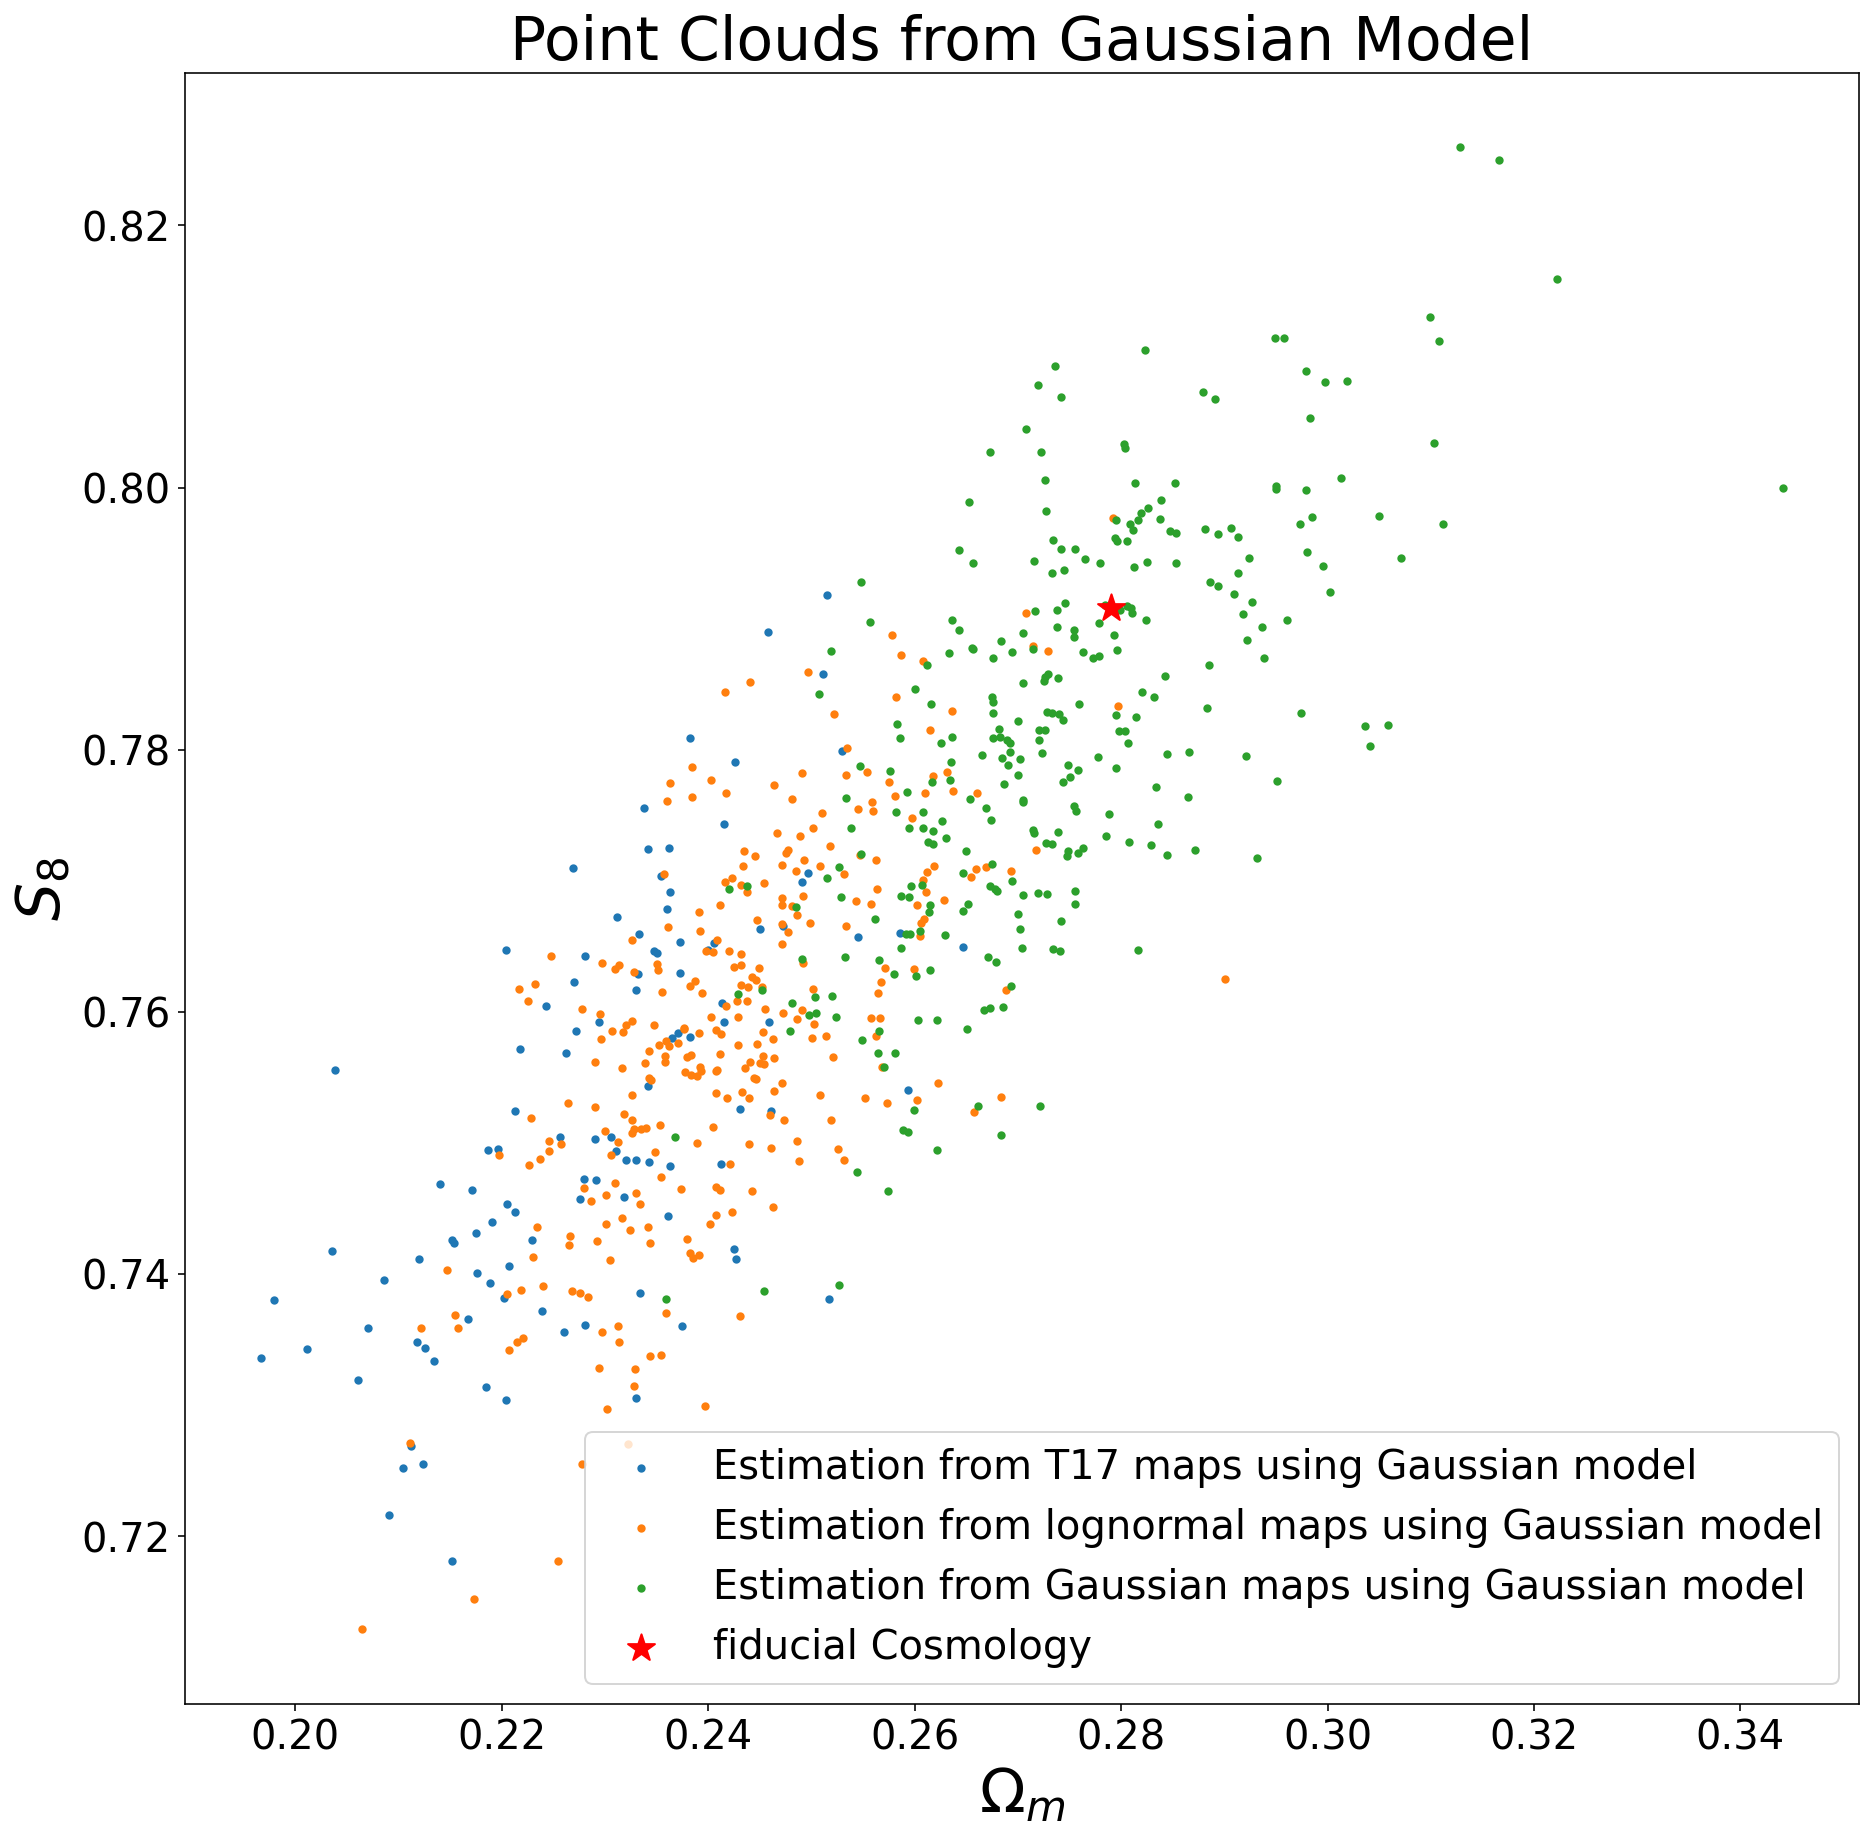

In [74]:
plt.figure(figsize=(15,15))
plt.scatter(prediction_T17_Gauss_1[:,0],S_8_T17_Gauss_1, label=f'Estimation from T17 maps using Gaussian model',s=10)
plt.scatter(prediction_lognormal_1_Gauss_1[:,0],S_8_lognormal_1_Gauss_1, label=f'Estimation from lognormal maps using Gaussian model',s=10)
plt.scatter(prediction_Gauss_1_Gauss_1[:,0],S_8_Gauss_1_Gauss_1, label=f'Estimation from Gaussian maps using Gaussian model',s=10)
#plt.scatter(prediction_T17_lognormal[:,0],S_8_T17_lognormal, label=f'Estimation from T17 maps using lognormal model',s=10)
#plt.scatter(prediction_lognormal_lognormal[:,0],S_8_lognormal_lognormal, label=f'Estimation from lognormal maps using lognormal model',s=10)
#plt.scatter(prediction_Gauss_lognormal[:,0],S_8_Gauss_lognormal, label=f'Estimation from Gaussian maps using lognormal model',s=10)
plt.scatter(fiducial_Omega_M, fiducial_S_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.title('Point Clouds from Gaussian Model',fontsize=30)
plt.legend(fontsize=20) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(f"$S_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Train_Gauss_prediction_2D_S8_11.png',bbox_inches='tight')
plt.show();

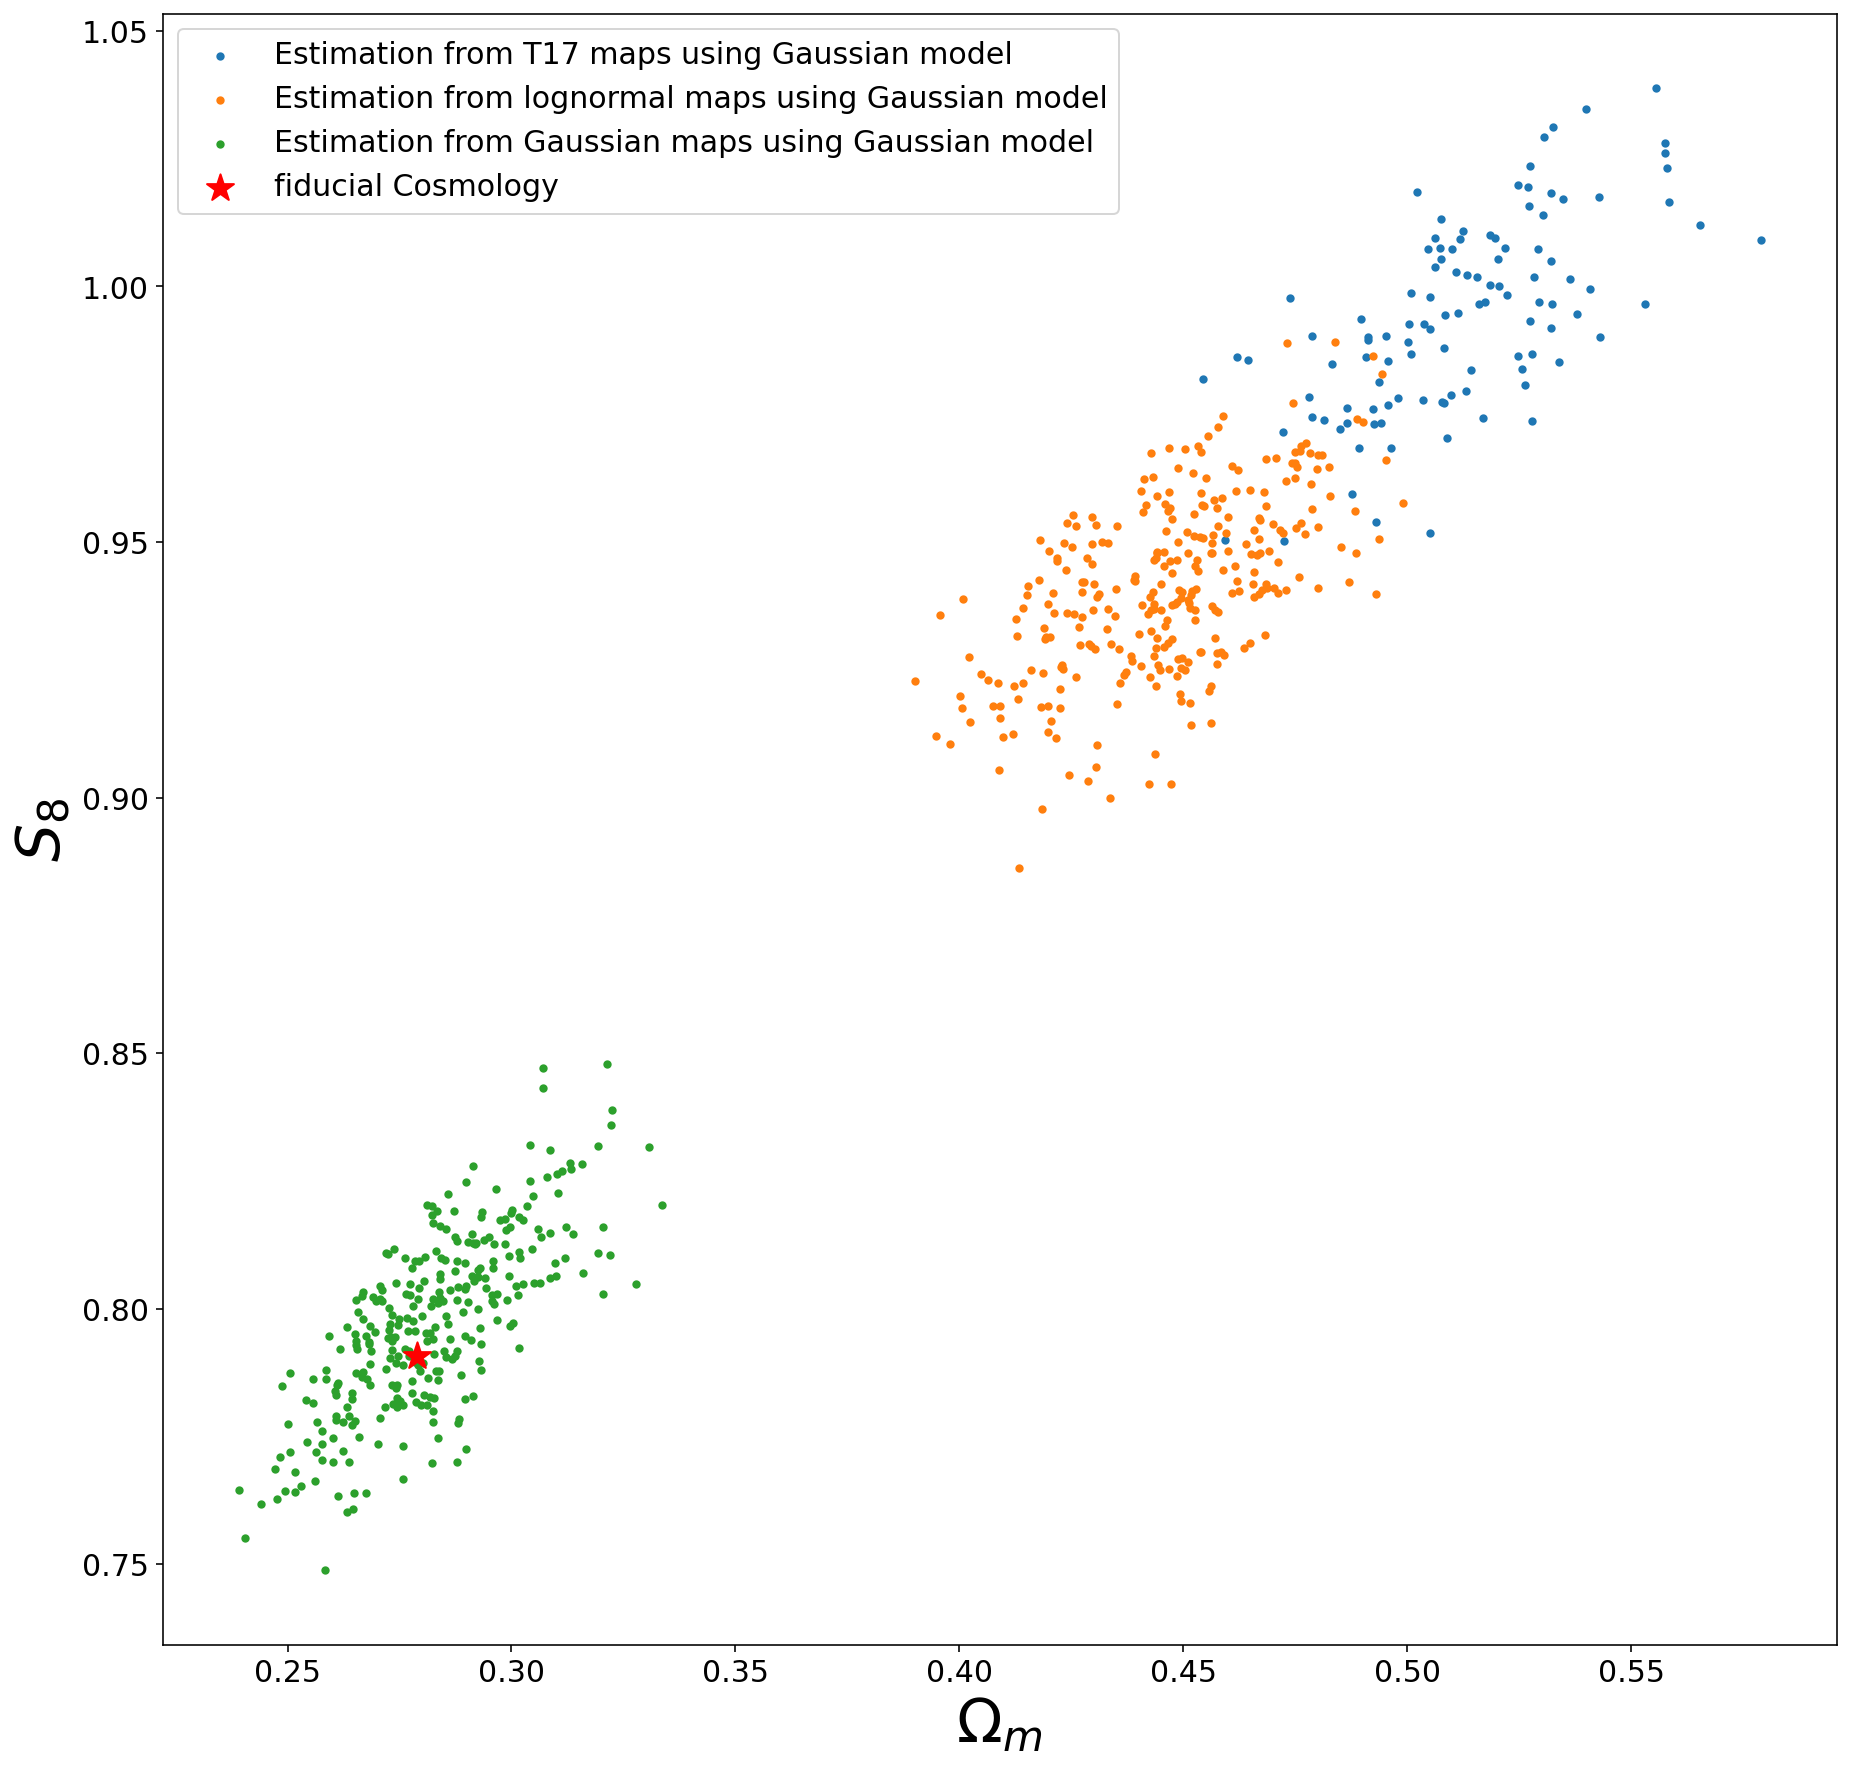

In [75]:
plt.figure(figsize=(15,15))
plt.scatter(prediction_T17_Gauss_2[:,0],S_8_T17_Gauss_2, label=f'Estimation from T17 maps using Gaussian model',s=10)
plt.scatter(prediction_lognormal_2_Gauss_2[:,0],S_8_lognormal_2_Gauss_2, label=f'Estimation from lognormal maps using Gaussian model',s=10)
plt.scatter(prediction_Gauss_2_Gauss_2[:,0],S_8_Gauss_2_Gauss_2, label=f'Estimation from Gaussian maps using Gaussian model',s=10)
#plt.scatter(prediction_T17_lognormal[:,0],S_8_T17_lognormal, label=f'Estimation from T17 maps using lognormal model',s=10)
#plt.scatter(prediction_lognormal_lognormal[:,0],S_8_lognormal_lognormal, label=f'Estimation from lognormal maps using lognormal model',s=10)
#plt.scatter(prediction_Gauss_lognormal[:,0],S_8_Gauss_lognormal, label=f'Estimation from Gaussian maps using lognormal model',s=10)
plt.scatter(fiducial_Omega_M, fiducial_S_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.legend(fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(f"$S_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Train_Gauss_prediction_2D_S8_22.png',bbox_inches='tight')
plt.show();

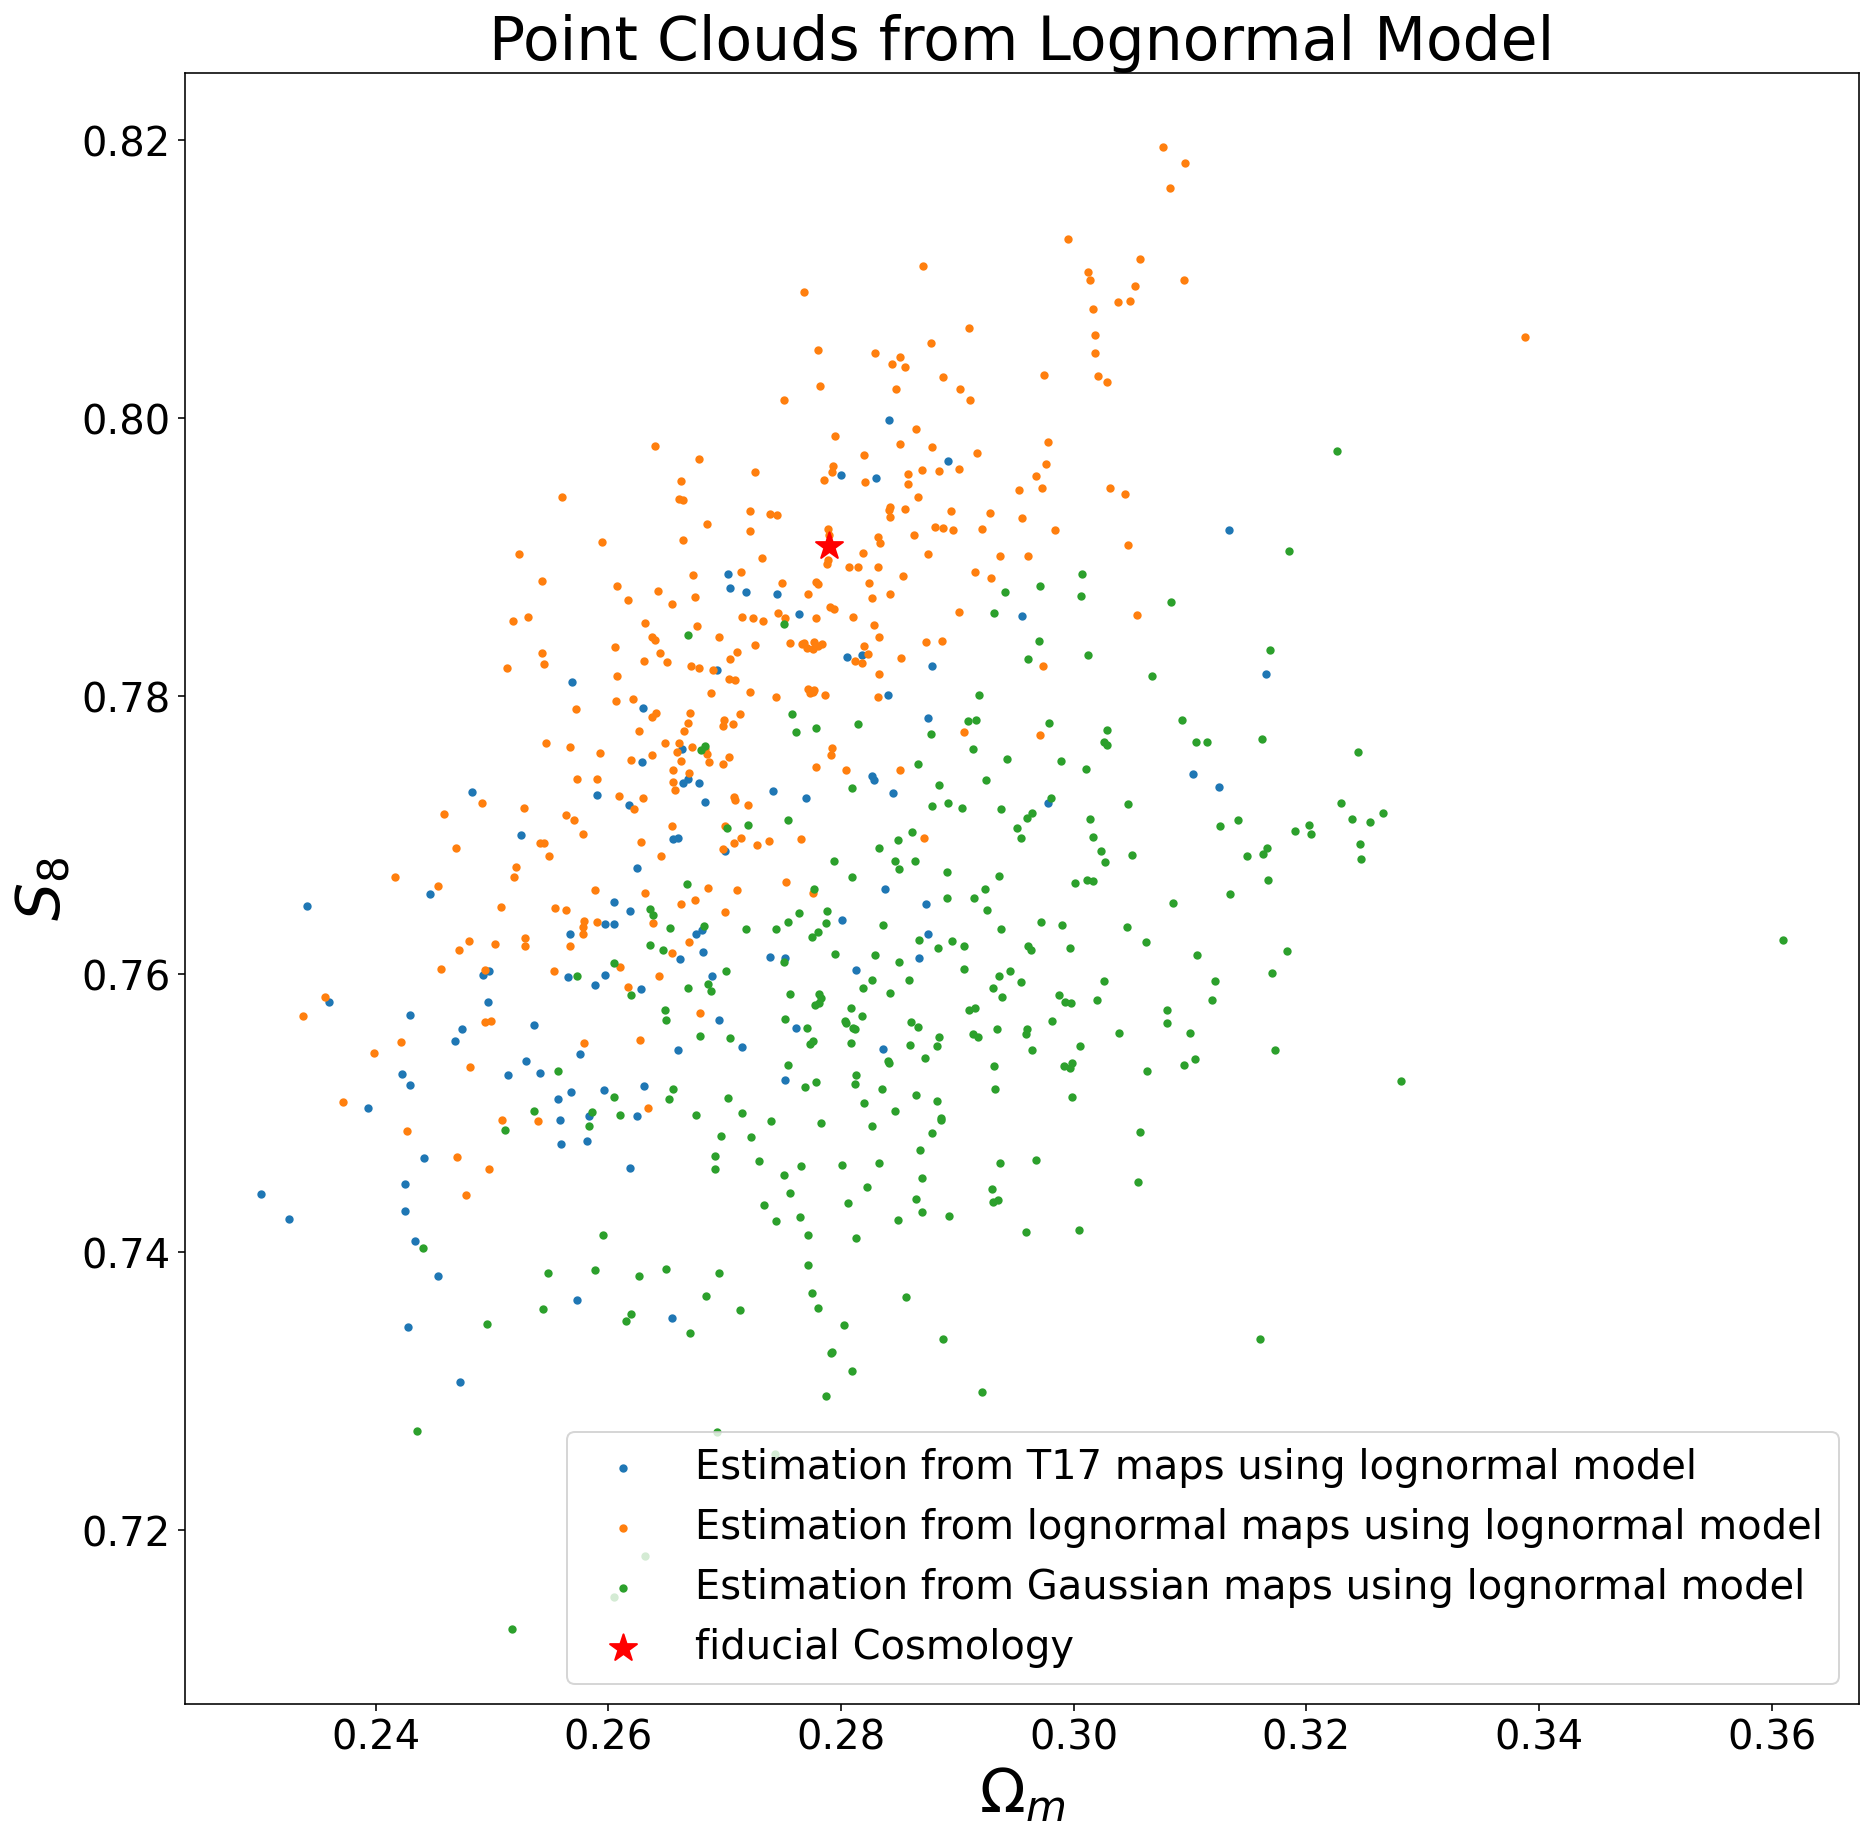

In [76]:
plt.figure(figsize=(15,15))
#plt.scatter(prediction_T17_Gauss[:,0],S_8_T17_Gauss, label=f'Estimation from T17 maps using Gaussian model',s=10)
#plt.scatter(prediction_lognormal_Gauss[:,0],S_8_lognormal_Gauss, label=f'Estimation from lognormal maps using Gaussian model',s=10)
#plt.scatter(prediction_Gauss_Gauss[:,0],S_8_Gauss_Gauss, label=f'Estimation from Gaussian maps using Gaussian model',s=10)
plt.scatter(prediction_T17_lognormal_1[:,0],S_8_T17_lognormal_1, label=f'Estimation from T17 maps using lognormal model',s=10)
plt.scatter(prediction_lognormal_1_lognormal_1[:,0],S_8_lognormal_1_lognormal_1, label=f'Estimation from lognormal maps using lognormal model',s=10)
plt.scatter(prediction_Gauss_1_lognormal_1[:,0],S_8_Gauss_1_lognormal_1, label=f'Estimation from Gaussian maps using lognormal model',s=10)
plt.scatter(fiducial_Omega_M, fiducial_S_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.title('Point Clouds from Lognormal Model',fontsize=30)
plt.legend(fontsize=20) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(f"$S_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Train_lognormal_prediction_2D_S8_11.png',bbox_inches='tight')
plt.show();

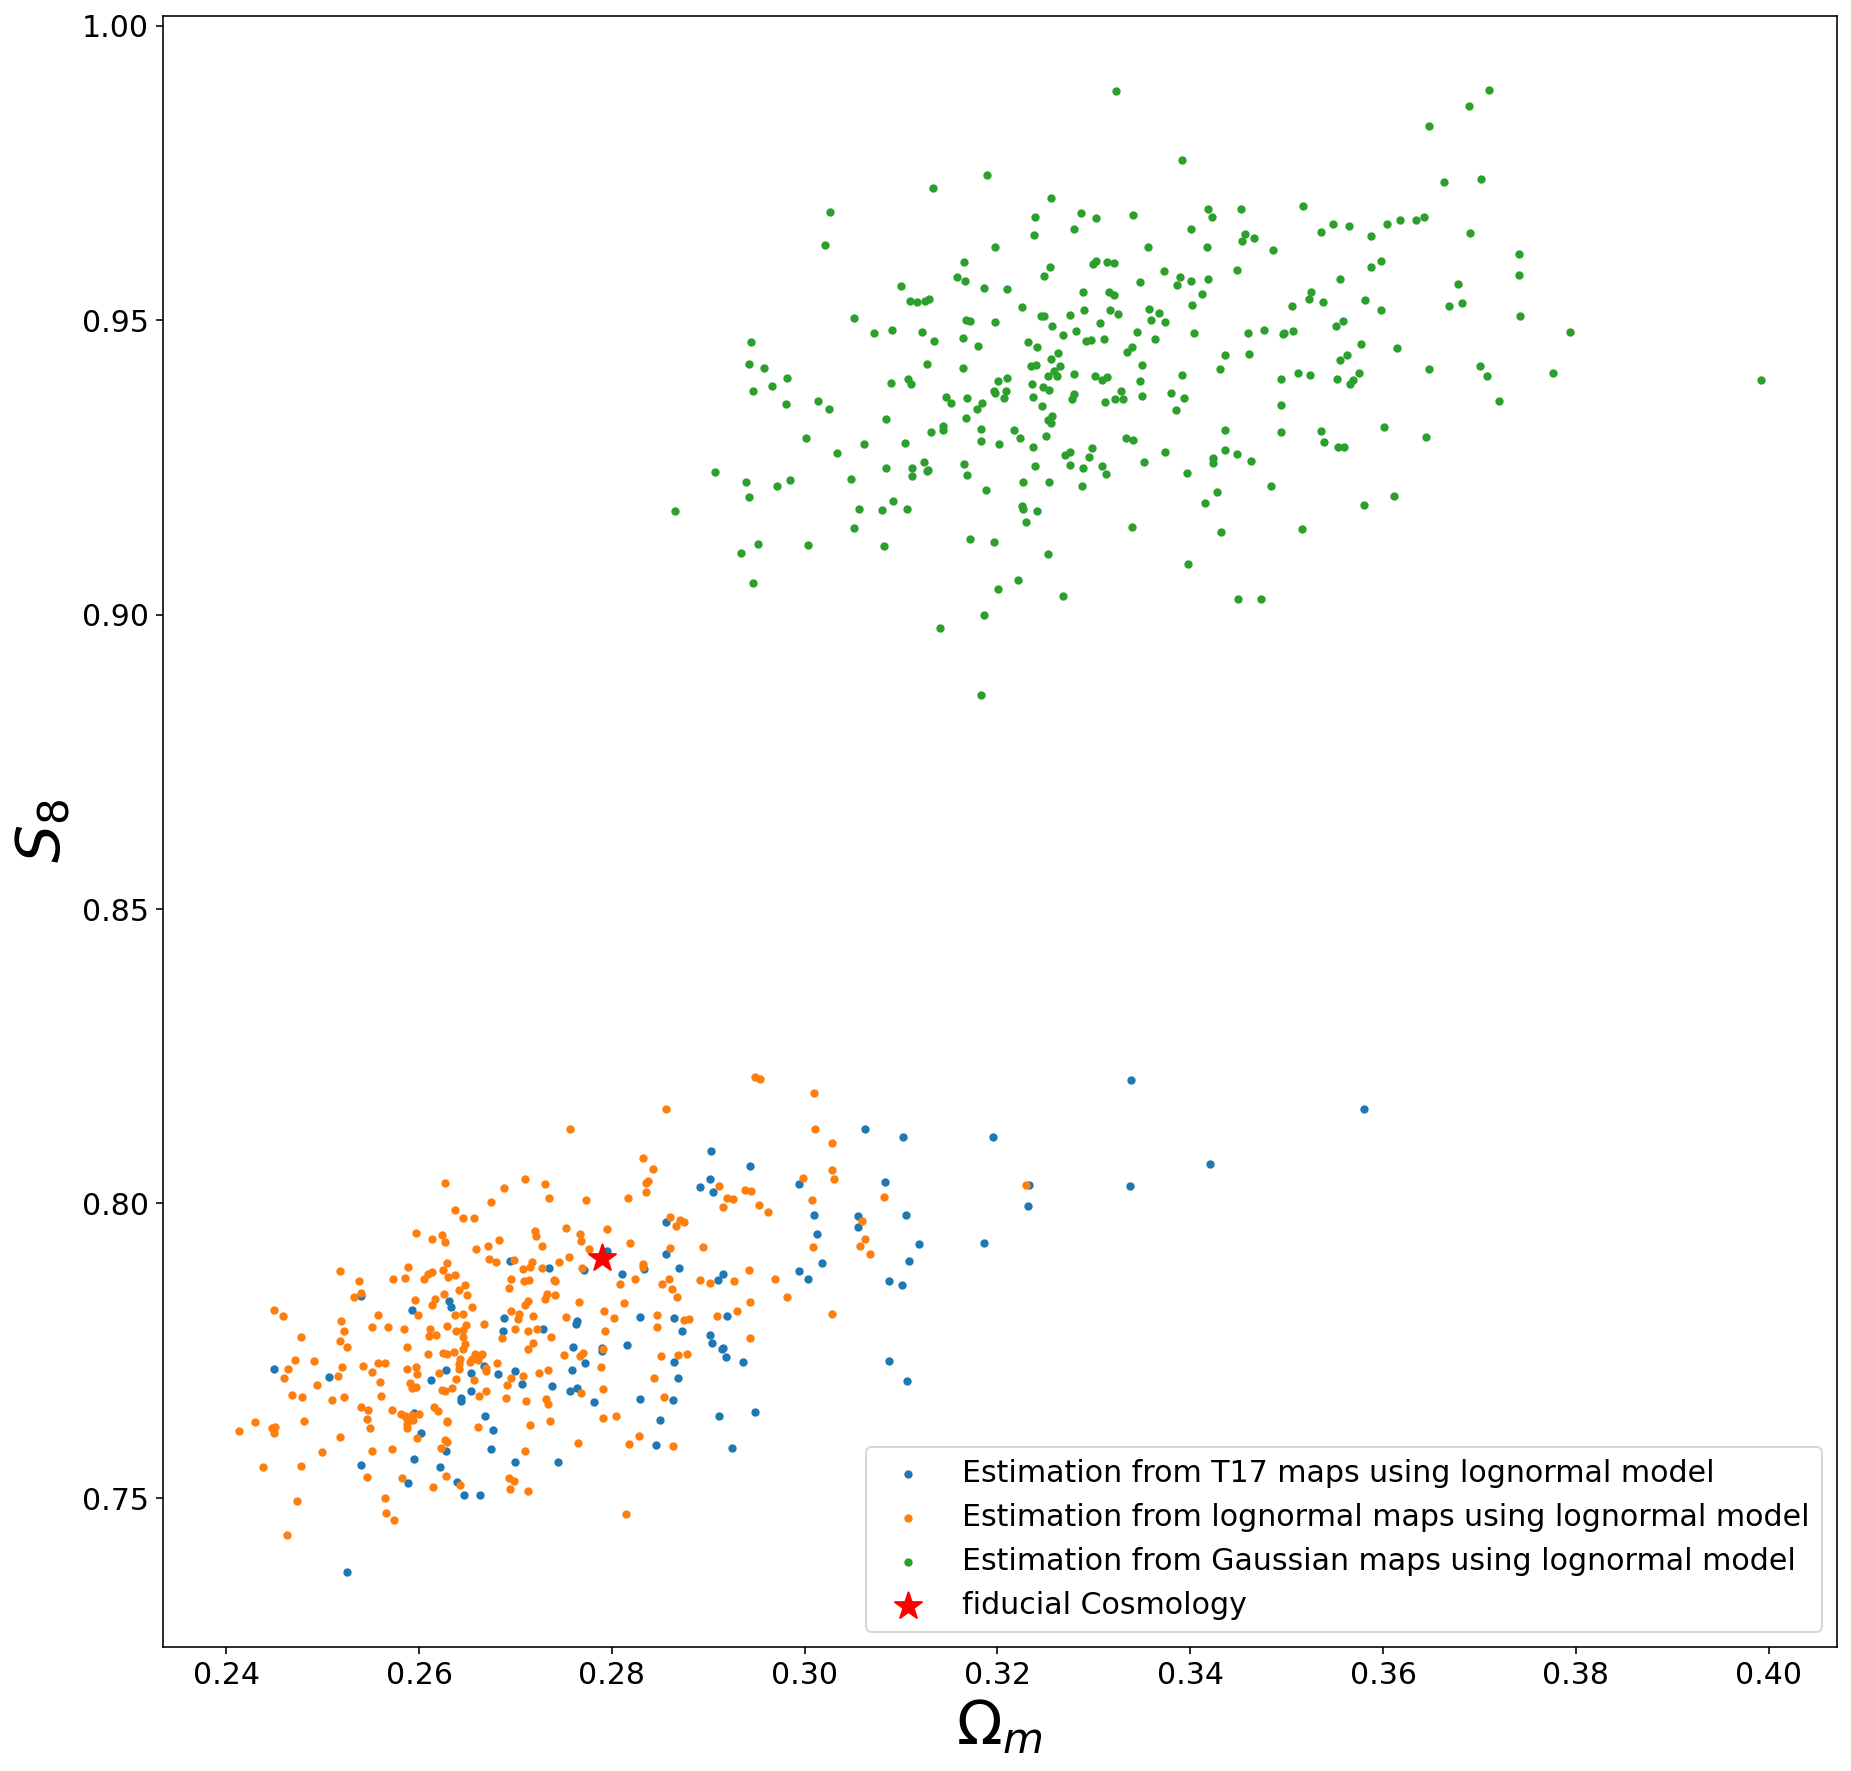

In [77]:
plt.figure(figsize=(15,15))
#plt.scatter(prediction_T17_Gauss[:,0],S_8_T17_Gauss, label=f'Estimation from T17 maps using Gaussian model',s=10)
#plt.scatter(prediction_lognormal_Gauss[:,0],S_8_lognormal_Gauss, label=f'Estimation from lognormal maps using Gaussian model',s=10)
#plt.scatter(prediction_Gauss_Gauss[:,0],S_8_Gauss_Gauss, label=f'Estimation from Gaussian maps using Gaussian model',s=10)
plt.scatter(prediction_T17_lognormal_2[:,0],S_8_T17_lognormal_2, label=f'Estimation from T17 maps using lognormal model',s=10)
plt.scatter(prediction_lognormal_2_lognormal_2[:,0],S_8_lognormal_2_lognormal_2, label=f'Estimation from lognormal maps using lognormal model',s=10)
plt.scatter(prediction_Gauss_2_lognormal_2[:,0],S_8_Gauss_2_lognormal_2, label=f'Estimation from Gaussian maps using lognormal model',s=10)
plt.scatter(fiducial_Omega_M, fiducial_S_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.legend(fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(f"$S_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Train_lognormal_prediction_2D_S8_22.png',bbox_inches='tight')

#### Wow bias is more significant!

In [78]:
prediction_T17_Gauss_1_S_8_mean             = np.mean(S_8_T17_Gauss_1)
prediction_T17_Gauss_2_S_8_mean             = np.mean(S_8_T17_Gauss_2)
prediction_lognormal_1_Gauss_1_S_8_mean     = np.mean(S_8_lognormal_1_Gauss_1)
prediction_lognormal_1_Gauss_2_S_8_mean     = np.mean(S_8_lognormal_1_Gauss_2)
prediction_lognormal_2_Gauss_1_S_8_mean     = np.mean(S_8_lognormal_2_Gauss_1)
prediction_lognormal_2_Gauss_2_S_8_mean     = np.mean(S_8_lognormal_2_Gauss_2)
prediction_Gauss_1_Gauss_1_S_8_mean         = np.mean(S_8_Gauss_1_Gauss_1)
prediction_Gauss_1_Gauss_2_S_8_mean         = np.mean(S_8_Gauss_1_Gauss_2)
prediction_Gauss_2_Gauss_1_S_8_mean         = np.mean(S_8_Gauss_2_Gauss_1)
prediction_Gauss_2_Gauss_2_S_8_mean         = np.mean(S_8_Gauss_2_Gauss_2)
prediction_T17_lognormal_1_S_8_mean         = np.mean(S_8_T17_lognormal_1)
prediction_T17_lognormal_2_S_8_mean         = np.mean(S_8_T17_lognormal_2)
prediction_lognormal_1_lognormal_1_S_8_mean = np.mean(S_8_lognormal_1_lognormal_1)
prediction_lognormal_1_lognormal_2_S_8_mean = np.mean(S_8_lognormal_1_lognormal_2)
prediction_lognormal_2_lognormal_1_S_8_mean = np.mean(S_8_lognormal_2_lognormal_1)
prediction_lognormal_2_lognormal_2_S_8_mean = np.mean(S_8_lognormal_2_lognormal_2)
prediction_Gauss_1_lognormal_1_S_8_mean     = np.mean(S_8_Gauss_1_lognormal_1)
prediction_Gauss_1_lognormal_2_S_8_mean     = np.mean(S_8_Gauss_1_lognormal_2)
prediction_Gauss_2_lognormal_1_S_8_mean     = np.mean(S_8_Gauss_2_lognormal_1)
prediction_Gauss_2_lognormal_2_S_8_mean     = np.mean(S_8_Gauss_2_lognormal_2)

bias_T17_Gauss_1_S_8             = (fiducial_S_8-prediction_T17_Gauss_1_S_8_mean)
bias_T17_Gauss_2_S_8             = (fiducial_S_8-prediction_T17_Gauss_2_S_8_mean)
bias_lognormal_1_Gauss_1_S_8     = (fiducial_S_8-prediction_lognormal_1_Gauss_1_S_8_mean)
bias_lognormal_1_Gauss_2_S_8     = (fiducial_S_8-prediction_lognormal_1_Gauss_2_S_8_mean)
bias_lognormal_2_Gauss_1_S_8     = (fiducial_S_8-prediction_lognormal_2_Gauss_1_S_8_mean)
bias_lognormal_2_Gauss_2_S_8     = (fiducial_S_8-prediction_lognormal_2_Gauss_2_S_8_mean)
bias_Gauss_1_Gauss_1_S_8         = (fiducial_S_8-prediction_Gauss_1_Gauss_1_S_8_mean)
bias_Gauss_1_Gauss_2_S_8         = (fiducial_S_8-prediction_Gauss_1_Gauss_2_S_8_mean)
bias_Gauss_2_Gauss_1_S_8         = (fiducial_S_8-prediction_Gauss_2_Gauss_1_S_8_mean)
bias_Gauss_2_Gauss_2_S_8         = (fiducial_S_8-prediction_Gauss_2_Gauss_2_S_8_mean)
bias_T17_lognormal_1_S_8       = (fiducial_S_8-prediction_T17_lognormal_1_S_8_mean)
bias_T17_lognormal_2_S_8       = (fiducial_S_8-prediction_T17_lognormal_2_S_8_mean)
bias_lognormal_1_lognormal_1_S_8 = (fiducial_S_8-prediction_lognormal_1_lognormal_1_S_8_mean)
bias_lognormal_1_lognormal_2_S_8 = (fiducial_S_8-prediction_lognormal_1_lognormal_2_S_8_mean)
bias_lognormal_2_lognormal_1_S_8 = (fiducial_S_8-prediction_lognormal_2_lognormal_1_S_8_mean)
bias_lognormal_2_lognormal_2_S_8 = (fiducial_S_8-prediction_lognormal_2_lognormal_2_S_8_mean)
bias_Gauss_1_lognormal_1_S_8     = (fiducial_S_8-prediction_Gauss_1_lognormal_1_S_8_mean)
bias_Gauss_1_lognormal_2_S_8     = (fiducial_S_8-prediction_Gauss_1_lognormal_2_S_8_mean)
bias_Gauss_2_lognormal_1_S_8     = (fiducial_S_8-prediction_Gauss_2_lognormal_1_S_8_mean)
bias_Gauss_2_lognormal_2_S_8     = (fiducial_S_8-prediction_Gauss_2_lognormal_2_S_8_mean)


var_T17_Gauss_1_S_8             = np.sum((S_8_T17_Gauss_1-prediction_T17_Gauss_1_S_8_mean)**2)/(len(S_8_T17_Gauss_1)-1)
var_T17_Gauss_2_S_8             = np.sum((S_8_T17_Gauss_2-prediction_T17_Gauss_2_S_8_mean)**2)/(len(S_8_T17_Gauss_2)-1)
var_lognormal_1_Gauss_1_S_8     = np.sum((S_8_lognormal_1_Gauss_1-prediction_lognormal_1_Gauss_1_S_8_mean)**2)/(len(S_8_lognormal_1_Gauss_1)-1)
var_lognormal_1_Gauss_2_S_8     = np.sum((S_8_lognormal_1_Gauss_2-prediction_lognormal_1_Gauss_2_S_8_mean)**2)/(len(S_8_lognormal_1_Gauss_2)-1)
var_lognormal_2_Gauss_1_S_8     = np.sum((S_8_lognormal_2_Gauss_1-prediction_lognormal_2_Gauss_1_S_8_mean)**2)/(len(S_8_lognormal_2_Gauss_1)-1)
var_lognormal_2_Gauss_2_S_8     = np.sum((S_8_lognormal_2_Gauss_2-prediction_lognormal_2_Gauss_2_S_8_mean)**2)/(len(S_8_lognormal_2_Gauss_2)-1)
var_Gauss_1_Gauss_1_S_8         = np.sum((S_8_Gauss_1_Gauss_1-prediction_Gauss_1_Gauss_1_S_8_mean)**2)/(len(S_8_Gauss_1_Gauss_1)-1)
var_Gauss_1_Gauss_2_S_8         = np.sum((S_8_Gauss_1_Gauss_2-prediction_Gauss_1_Gauss_2_S_8_mean)**2)/(len(S_8_Gauss_1_Gauss_2)-1)
var_Gauss_2_Gauss_1_S_8         = np.sum((S_8_Gauss_2_Gauss_1-prediction_Gauss_2_Gauss_1_S_8_mean)**2)/(len(S_8_Gauss_2_Gauss_1)-1)
var_Gauss_2_Gauss_2_S_8         = np.sum((S_8_Gauss_2_Gauss_2-prediction_Gauss_2_Gauss_2_S_8_mean)**2)/(len(S_8_Gauss_2_Gauss_2)-1)
var_T17_lognormal_1_S_8         = np.sum((S_8_T17_lognormal_1-prediction_T17_lognormal_1_S_8_mean)**2)/(len(S_8_T17_lognormal_1)-1)
var_T17_lognormal_2_S_8         = np.sum((S_8_T17_lognormal_2-prediction_T17_lognormal_2_S_8_mean)**2)/(len(S_8_T17_lognormal_2)-1)
var_lognormal_1_lognormal_1_S_8 = np.sum((S_8_lognormal_1_lognormal_1-prediction_lognormal_1_lognormal_1_S_8_mean)**2)/(len(S_8_lognormal_1_lognormal_1)-1)
var_lognormal_1_lognormal_2_S_8 = np.sum((S_8_lognormal_1_lognormal_2-prediction_lognormal_1_lognormal_2_S_8_mean)**2)/(len(S_8_lognormal_1_lognormal_2)-1)
var_lognormal_2_lognormal_1_S_8 = np.sum((S_8_lognormal_2_lognormal_1-prediction_lognormal_2_lognormal_1_S_8_mean)**2)/(len(S_8_lognormal_2_lognormal_1)-1)
var_lognormal_2_lognormal_2_S_8 = np.sum((S_8_lognormal_2_lognormal_2-prediction_lognormal_2_lognormal_2_S_8_mean)**2)/(len(S_8_lognormal_2_lognormal_2)-1)
var_Gauss_1_lognormal_1_S_8     = np.sum((S_8_Gauss_1_lognormal_1-prediction_Gauss_1_lognormal_1_S_8_mean)**2)/(len(S_8_Gauss_1_lognormal_1)-1) 
var_Gauss_1_lognormal_2_S_8     = np.sum((S_8_Gauss_1_lognormal_2-prediction_Gauss_1_lognormal_2_S_8_mean)**2)/(len(S_8_Gauss_1_lognormal_2)-1) 
var_Gauss_2_lognormal_1_S_8     = np.sum((S_8_Gauss_2_lognormal_1-prediction_Gauss_2_lognormal_1_S_8_mean)**2)/(len(S_8_Gauss_2_lognormal_1)-1) 
var_Gauss_2_lognormal_2_S_8     = np.sum((S_8_Gauss_2_lognormal_2-prediction_Gauss_2_lognormal_2_S_8_mean)**2)/(len(S_8_Gauss_2_lognormal_2)-1) 

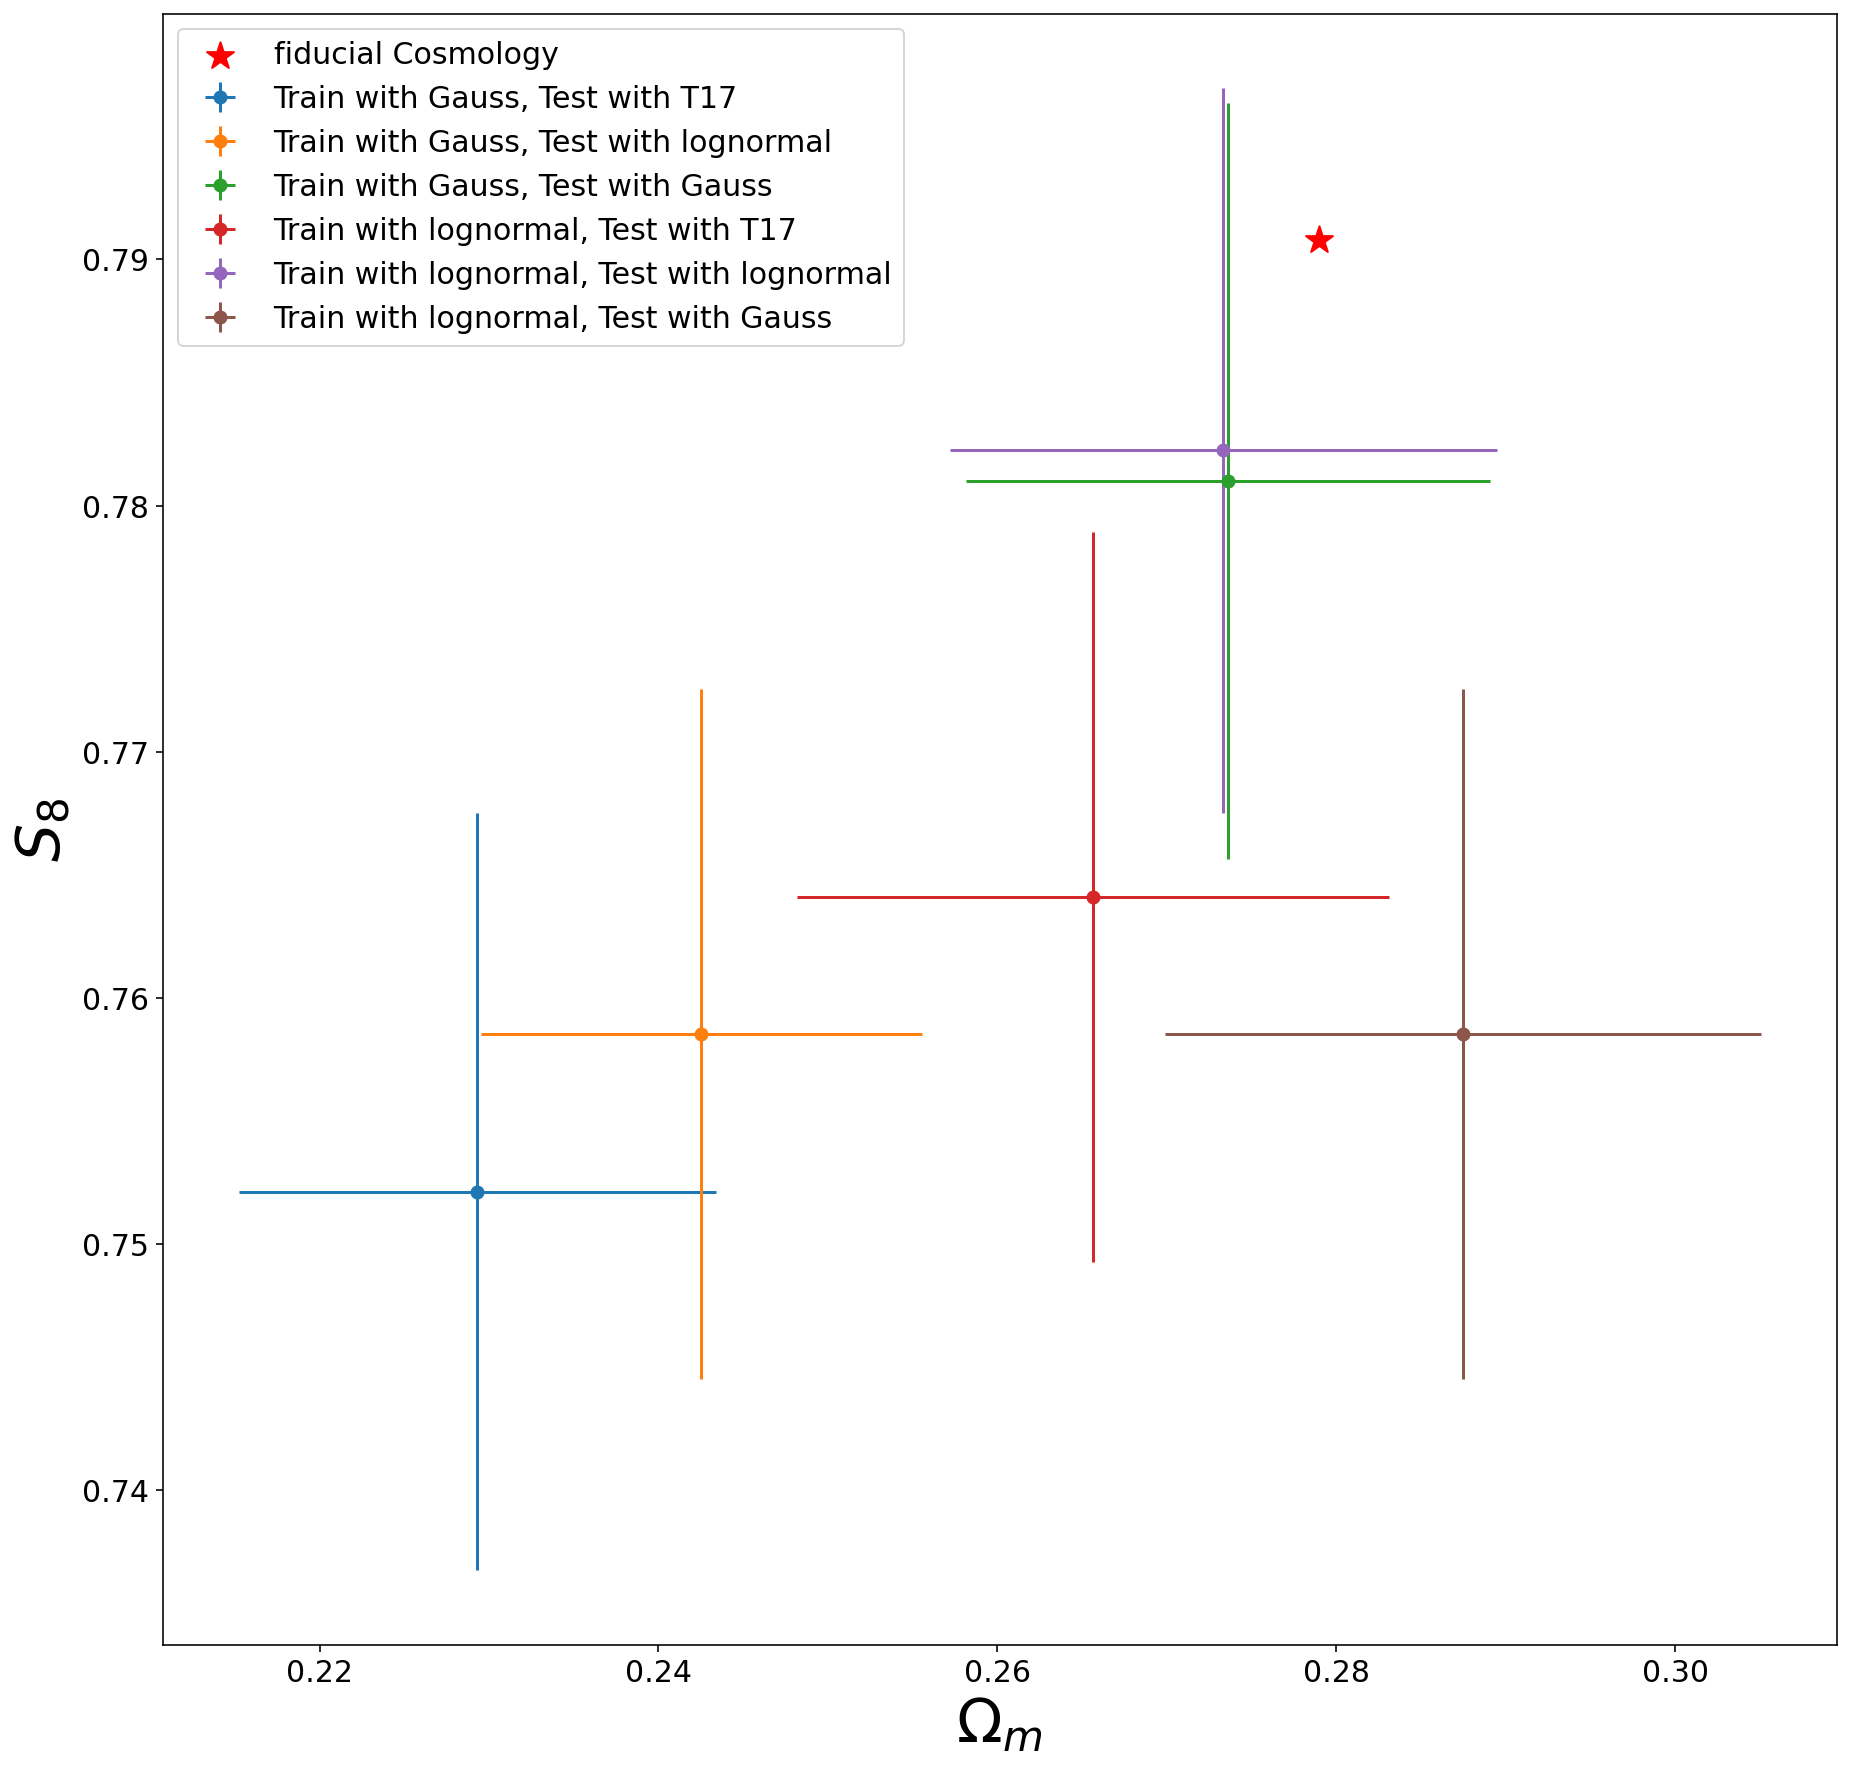

In [79]:
plt.figure(figsize=(15,15))
plt.errorbar(prediction_T17_Gauss_1_Omega_M_mean, prediction_T17_Gauss_1_S_8_mean, fmt='o', xerr=np.sqrt(var_T17_Gauss_1_Omega_M), yerr=np.sqrt(var_T17_Gauss_1_S_8 ),label='Train with Gauss, Test with T17')
plt.errorbar(prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_S_8_mean, fmt='o', xerr=np.sqrt(var_lognormal_1_Gauss_1_Omega_M), yerr=np.sqrt(var_lognormal_1_Gauss_1_S_8),label='Train with Gauss, Test with lognormal')
plt.errorbar(prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_S_8_mean, fmt='o', xerr=np.sqrt(var_Gauss_1_Gauss_1_Omega_M), yerr=np.sqrt(var_Gauss_1_Gauss_1_S_8),label='Train with Gauss, Test with Gauss')
plt.errorbar(prediction_T17_lognormal_1_Omega_M_mean, prediction_T17_lognormal_1_S_8_mean, fmt='o', xerr=np.sqrt(var_T17_lognormal_1_Omega_M), yerr=np.sqrt(var_T17_lognormal_1_S_8),label='Train with lognormal, Test with T17')
plt.errorbar(prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_S_8_mean, fmt='o', xerr=np.sqrt(var_lognormal_1_lognormal_1_Omega_M), yerr=np.sqrt(var_lognormal_1_lognormal_1_S_8),label='Train with lognormal, Test with lognormal')
plt.errorbar(prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_S_8_mean, fmt='o', xerr=np.sqrt(var_Gauss_1_lognormal_1_Omega_M), yerr=np.sqrt(var_Gauss_1_lognormal_1_S_8),label='Train with lognormal, Test with Gauss')
plt.scatter(fiducial_Omega_M, fiducial_S_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.legend(fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(f"$S_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Test_prediction_mean_2D_S_8_11.png',bbox_inches='tight')
plt.show();

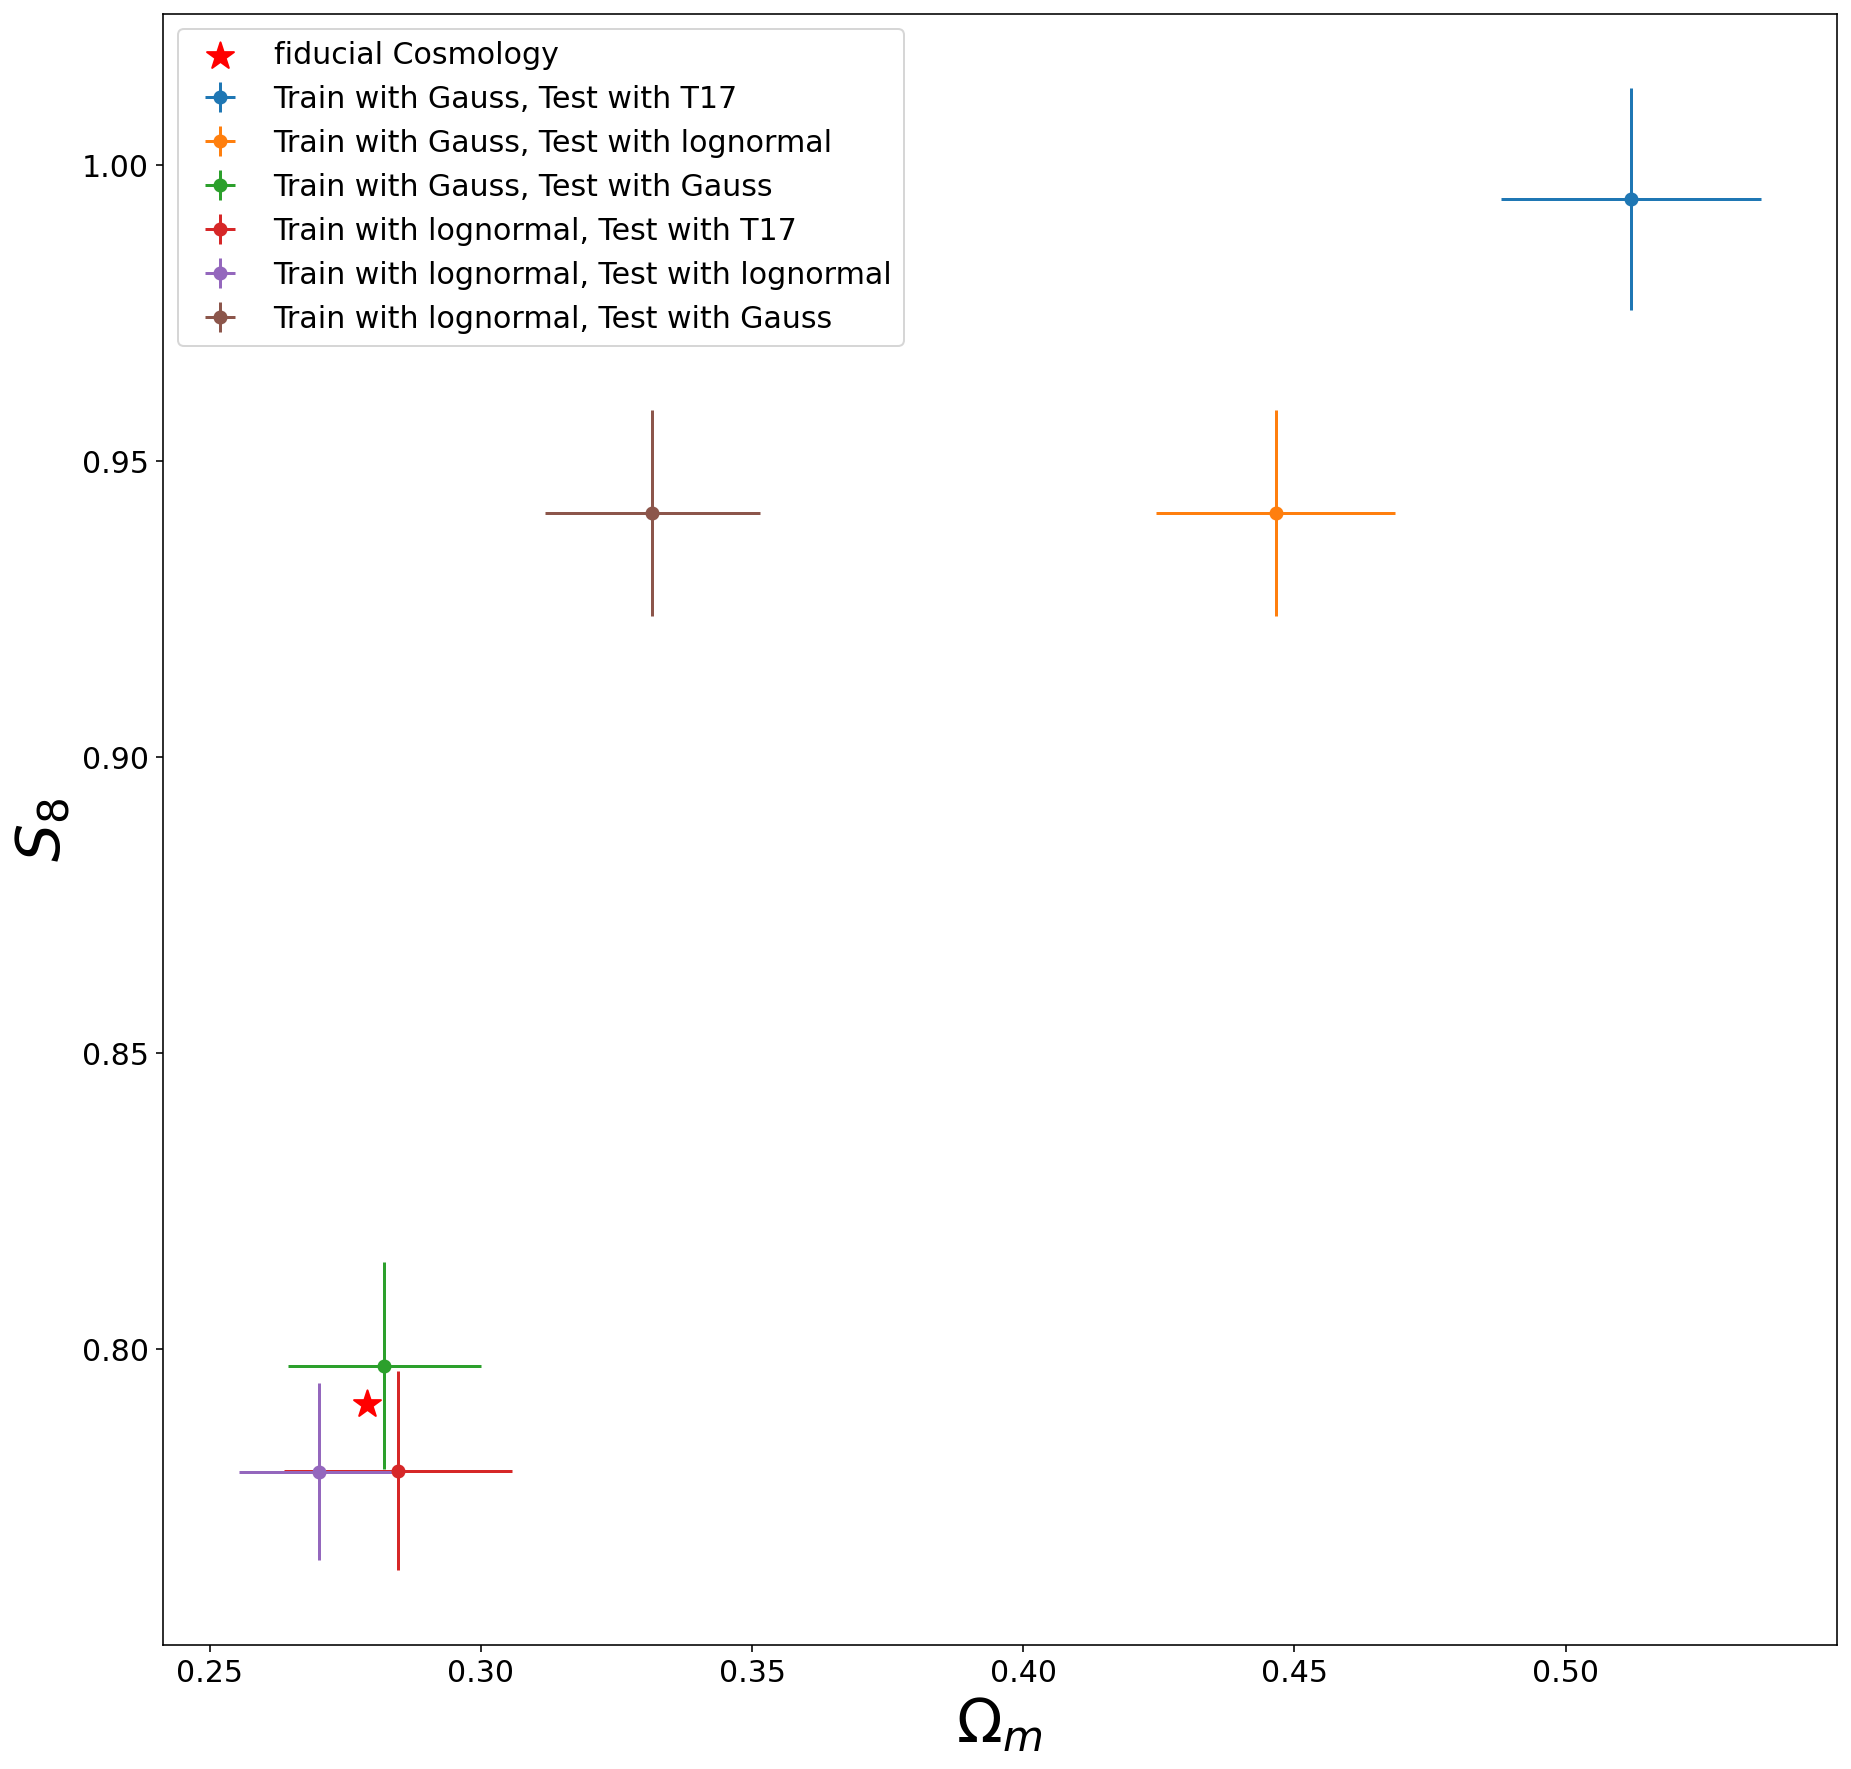

In [80]:
plt.figure(figsize=(15,15))
plt.errorbar(prediction_T17_Gauss_2_Omega_M_mean, prediction_T17_Gauss_2_S_8_mean, fmt='o', xerr=np.sqrt(var_T17_Gauss_2_Omega_M), yerr=np.sqrt(var_T17_Gauss_2_S_8 ),label='Train with Gauss, Test with T17')
plt.errorbar(prediction_lognormal_2_Gauss_2_Omega_M_mean, prediction_lognormal_2_Gauss_2_S_8_mean, fmt='o', xerr=np.sqrt(var_lognormal_2_Gauss_2_Omega_M), yerr=np.sqrt(var_lognormal_2_Gauss_2_S_8),label='Train with Gauss, Test with lognormal')
plt.errorbar(prediction_Gauss_2_Gauss_2_Omega_M_mean, prediction_Gauss_2_Gauss_2_S_8_mean, fmt='o', xerr=np.sqrt(var_Gauss_2_Gauss_2_Omega_M), yerr=np.sqrt(var_Gauss_2_Gauss_2_S_8),label='Train with Gauss, Test with Gauss')
plt.errorbar(prediction_T17_lognormal_2_Omega_M_mean, prediction_T17_lognormal_2_S_8_mean, fmt='o', xerr=np.sqrt(var_T17_lognormal_2_Omega_M), yerr=np.sqrt(var_T17_lognormal_2_S_8),label='Train with lognormal, Test with T17')
plt.errorbar(prediction_lognormal_2_lognormal_2_Omega_M_mean, prediction_lognormal_2_lognormal_2_S_8_mean, fmt='o', xerr=np.sqrt(var_lognormal_2_lognormal_2_Omega_M), yerr=np.sqrt(var_lognormal_2_lognormal_2_S_8),label='Train with lognormal, Test with lognormal')
plt.errorbar(prediction_Gauss_2_lognormal_2_Omega_M_mean, prediction_Gauss_2_lognormal_2_S_8_mean, fmt='o', xerr=np.sqrt(var_Gauss_2_lognormal_2_Omega_M), yerr=np.sqrt(var_Gauss_2_lognormal_2_S_8),label='Train with lognormal, Test with Gauss')
plt.scatter(fiducial_Omega_M, fiducial_S_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.legend(fontsize=15) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(f"$S_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Test_prediction_mean_2D_S_8_22.png',bbox_inches='tight')
plt.show();

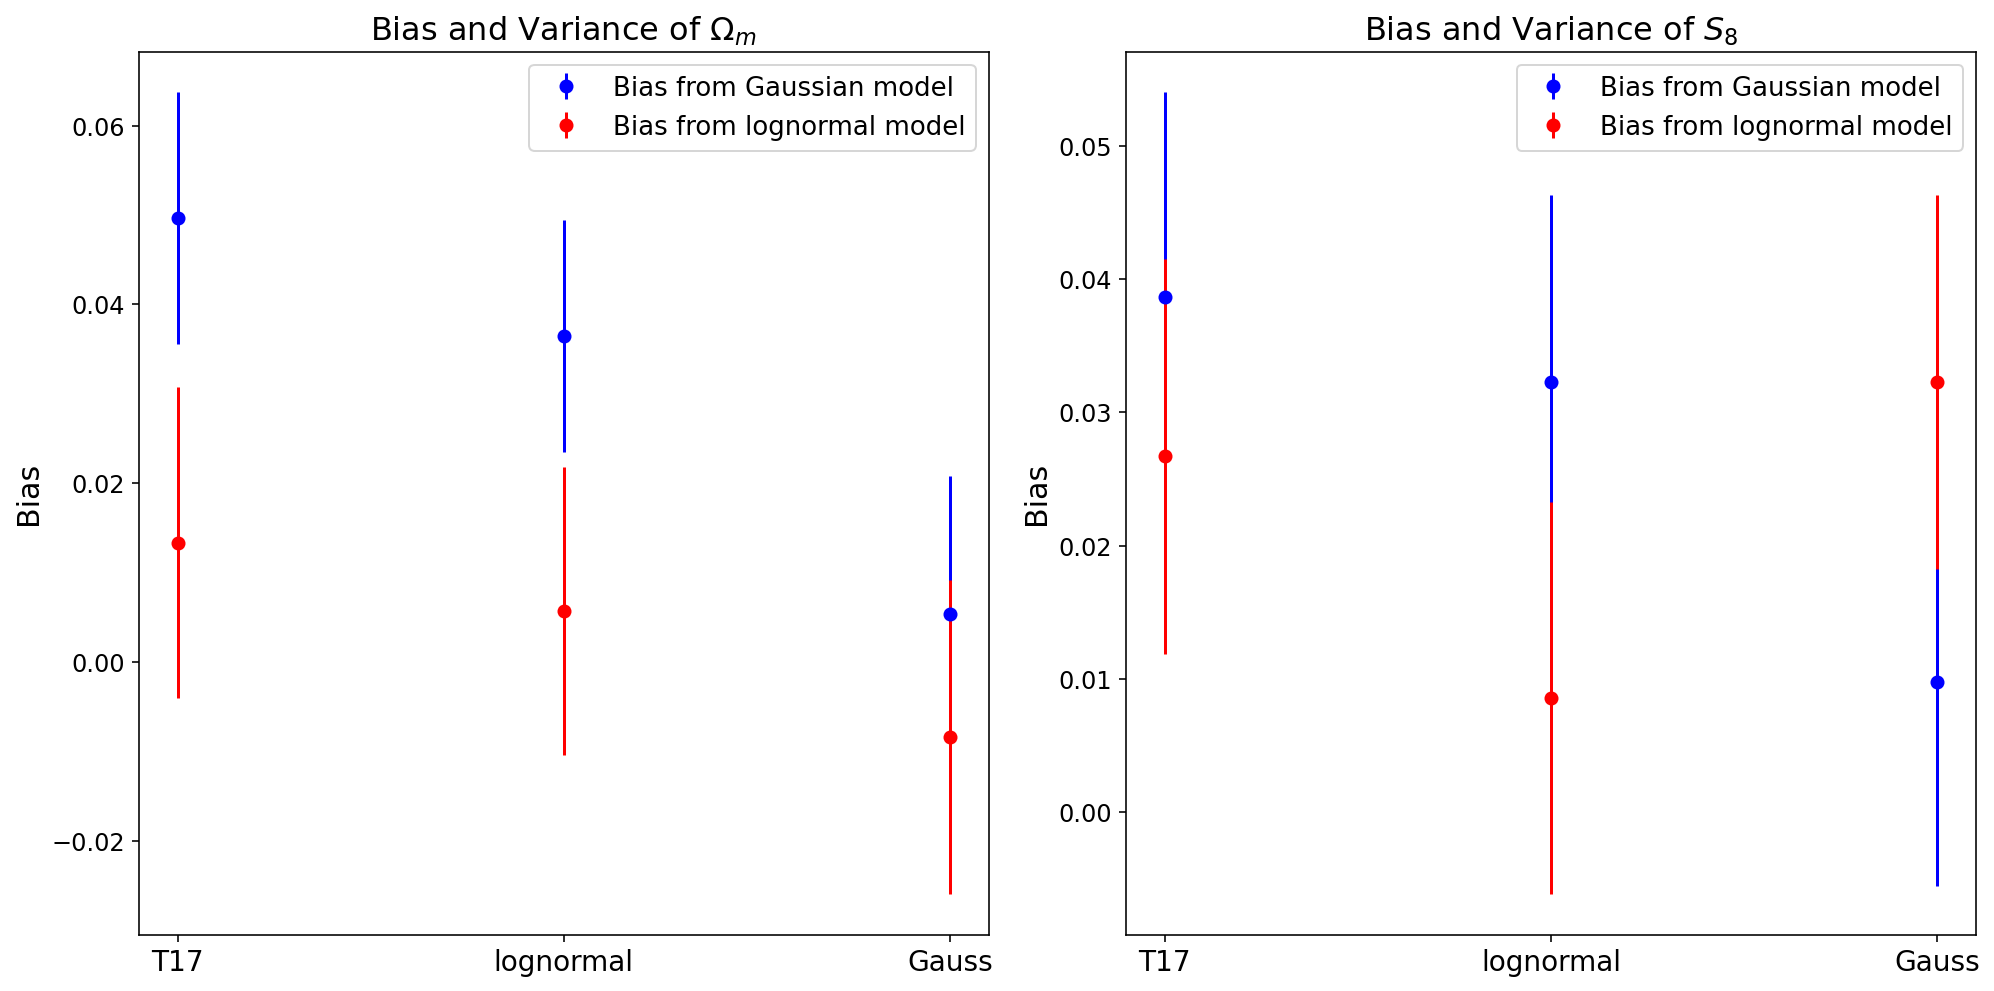

In [81]:
labels = ['T17', 'lognormal', 'Gauss']
bias_Omega_M_Gauss_11         = [bias_T17_Gauss_1_Omega_M, bias_lognormal_1_Gauss_1_Omega_M, bias_Gauss_1_Gauss_1_Omega_M]
variance_Omega_M_Gauss_11     = [var_T17_Gauss_1_Omega_M, var_lognormal_1_Gauss_1_Omega_M, var_Gauss_1_Gauss_1_Omega_M]
bias_Omega_M_lognormal_11     = [bias_T17_lognormal_1_Omega_M, bias_lognormal_1_lognormal_1_Omega_M, bias_Gauss_1_lognormal_1_Omega_M]
variance_Omega_M_lognormal_11 = [var_T17_lognormal_1_Omega_M, var_lognormal_1_lognormal_1_Omega_M, var_Gauss_1_lognormal_1_Omega_M]

bias_S_8_Gauss_11         = [bias_T17_Gauss_1_S_8, bias_lognormal_1_Gauss_1_S_8, bias_Gauss_1_Gauss_1_S_8]
variance_S_8_Gauss_11     = [var_T17_Gauss_1_S_8, var_lognormal_1_Gauss_1_S_8, var_Gauss_1_Gauss_1_S_8]
bias_S_8_lognormal_11     = [bias_T17_lognormal_1_S_8, bias_lognormal_1_lognormal_1_S_8, bias_Gauss_1_lognormal_1_S_8]
variance_S_8_lognormal_11 = [var_T17_lognormal_1_S_8, var_lognormal_1_lognormal_1_S_8, var_Gauss_1_lognormal_1_S_8]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot bias for Omega_M
ax1.errorbar(labels, bias_Omega_M_Gauss_11, yerr=np.sqrt(variance_Omega_M_Gauss_11), fmt='o', color='b', label='Bias from Gaussian model')
ax1.errorbar(labels, bias_Omega_M_lognormal_11, yerr=np.sqrt(variance_Omega_M_lognormal_11), fmt='o', color='r', label='Bias from lognormal model')
ax1.set_title('Bias and Variance of $\Omega_m$', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('Bias', fontsize=15)
ax1.legend(fontsize=13)

# Plot bias for sigma_8
ax2.errorbar(labels, bias_S_8_Gauss_11, yerr=np.sqrt(variance_S_8_Gauss_11), fmt='o', color='b', label='Bias from Gaussian model')
ax2.errorbar(labels, bias_S_8_lognormal_11, yerr=np.sqrt(variance_S_8_lognormal_11), fmt='o', color='r', label='Bias from lognormal model')
ax2.set_title('Bias and Variance of $S_8$', fontsize=16)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel('Bias', fontsize=15)
ax2.legend(fontsize=13)

plt.tight_layout()
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Bias_variance_S_8_11.png',bbox_inches='tight')
plt.show();

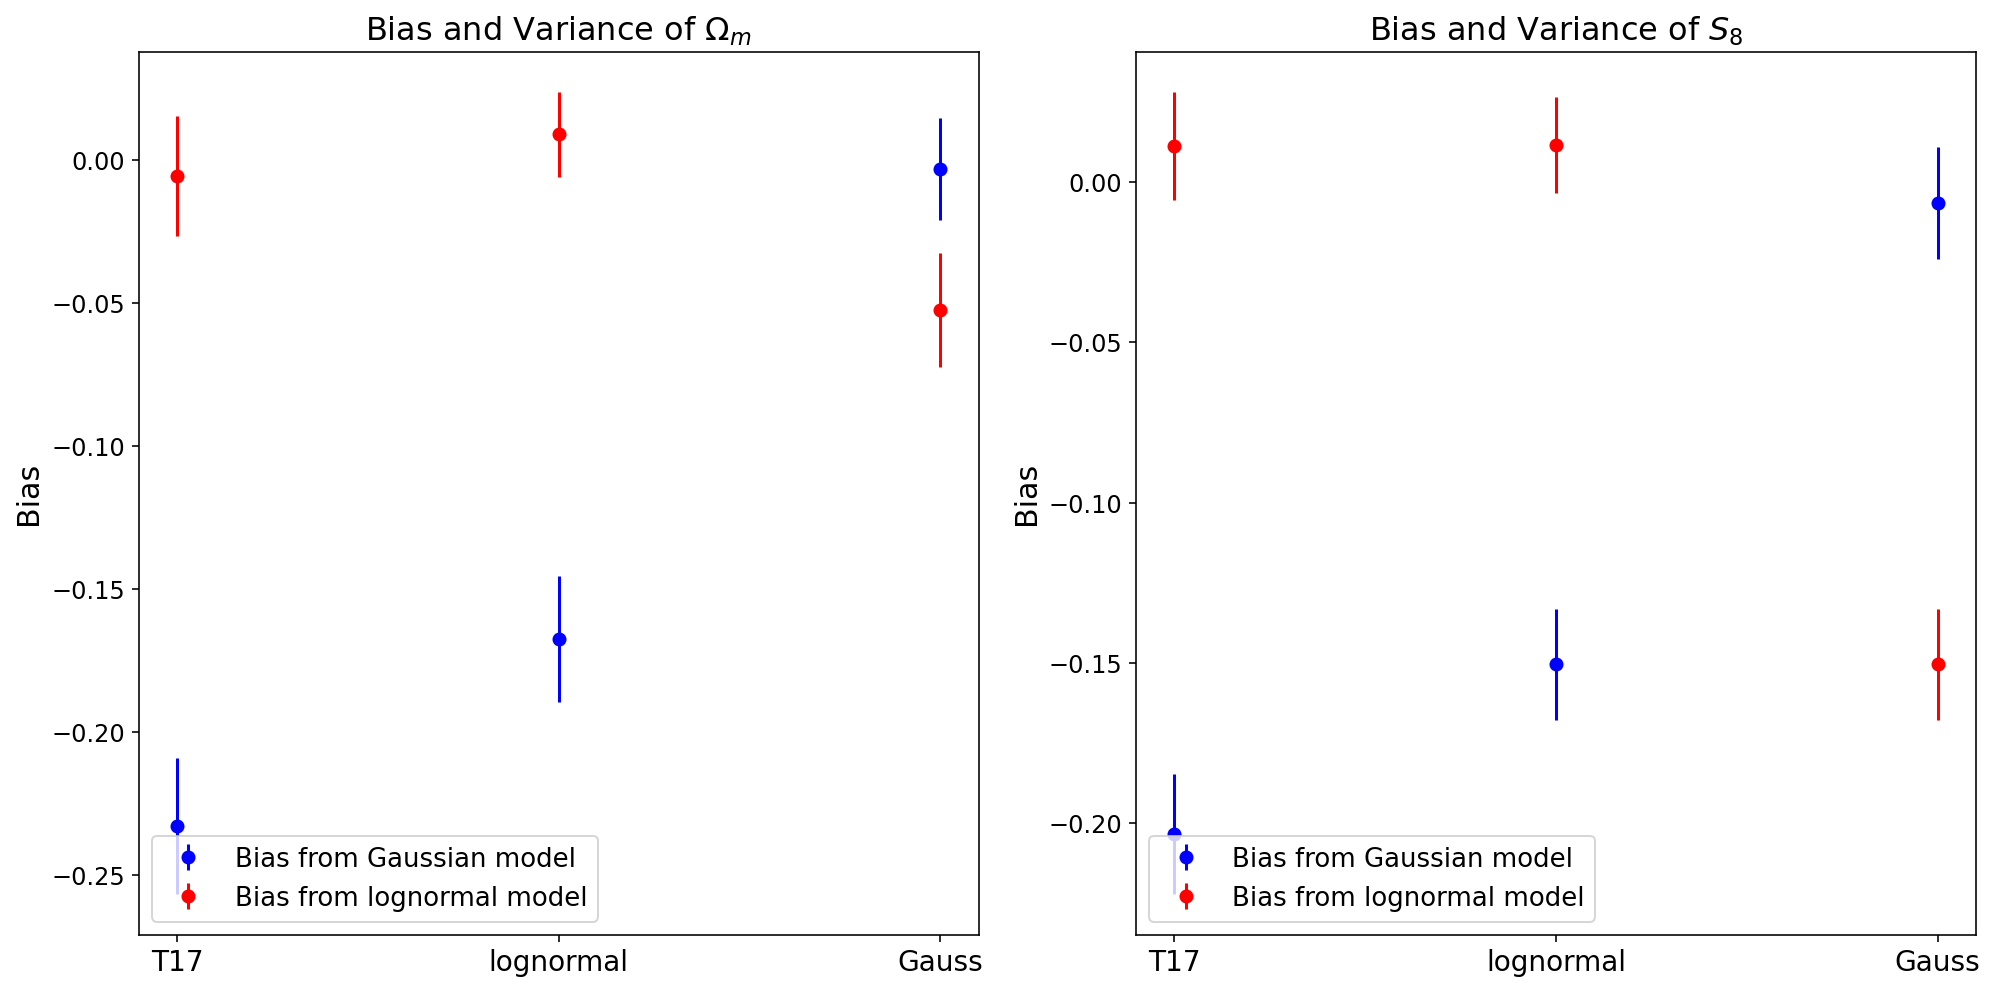

In [82]:
labels = ['T17', 'lognormal', 'Gauss']
bias_Omega_M_Gauss_22         = [bias_T17_Gauss_2_Omega_M, bias_lognormal_2_Gauss_2_Omega_M, bias_Gauss_2_Gauss_2_Omega_M]
variance_Omega_M_Gauss_22     = [var_T17_Gauss_2_Omega_M, var_lognormal_2_Gauss_2_Omega_M, var_Gauss_2_Gauss_2_Omega_M]
bias_Omega_M_lognormal_22     = [bias_T17_lognormal_2_Omega_M, bias_lognormal_2_lognormal_2_Omega_M, bias_Gauss_2_lognormal_2_Omega_M]
variance_Omega_M_lognormal_22 = [var_T17_lognormal_2_Omega_M, var_lognormal_2_lognormal_2_Omega_M, var_Gauss_2_lognormal_2_Omega_M]

bias_S_8_Gauss_22         = [bias_T17_Gauss_2_S_8, bias_lognormal_2_Gauss_2_S_8, bias_Gauss_2_Gauss_2_S_8]
variance_S_8_Gauss_22     = [var_T17_Gauss_2_S_8, var_lognormal_2_Gauss_2_S_8, var_Gauss_2_Gauss_2_S_8]
bias_S_8_lognormal_22     = [bias_T17_lognormal_2_S_8, bias_lognormal_2_lognormal_2_S_8, bias_Gauss_2_lognormal_2_S_8]
variance_S_8_lognormal_22 = [var_T17_lognormal_2_S_8, var_lognormal_2_lognormal_2_S_8, var_Gauss_2_lognormal_2_S_8]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot bias for Omega_M
ax1.errorbar(labels, bias_Omega_M_Gauss_22, yerr=np.sqrt(variance_Omega_M_Gauss_22), fmt='o', color='b', label='Bias from Gaussian model')
ax1.errorbar(labels, bias_Omega_M_lognormal_22, yerr=np.sqrt(variance_Omega_M_lognormal_22), fmt='o', color='r', label='Bias from lognormal model')
ax1.set_title('Bias and Variance of $\Omega_m$', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('Bias', fontsize=15)
ax1.legend(fontsize=13)

# Plot bias for sigma_8
ax2.errorbar(labels, bias_S_8_Gauss_22, yerr=np.sqrt(variance_S_8_Gauss_22), fmt='o', color='b', label='Bias from Gaussian model')
ax2.errorbar(labels, bias_S_8_lognormal_22, yerr=np.sqrt(variance_S_8_lognormal_22), fmt='o', color='r', label='Bias from lognormal model')
ax2.set_title('Bias and Variance of $S_8$', fontsize=16)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel('Bias', fontsize=15)
ax2.legend(fontsize=13)

plt.tight_layout()
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Bias_variance_S_8_22.png',bbox_inches='tight')
plt.show();

In [83]:
dis_T17_Gauss_1_S_8             = np.sqrt((bias_T17_Gauss_1_Omega_M)**2+(bias_T17_Gauss_1_S_8)**2)
dis_T17_Gauss_2_S_8             = np.sqrt((bias_T17_Gauss_2_Omega_M)**2+(bias_T17_Gauss_2_S_8)**2)
dis_Gauss_1_Gauss_1_S_8         = np.sqrt((bias_Gauss_1_Gauss_1_Omega_M)**2+(bias_Gauss_1_Gauss_1_S_8)**2)
dis_Gauss_1_Gauss_2_S_8         = np.sqrt((bias_Gauss_1_Gauss_2_Omega_M)**2+(bias_Gauss_1_Gauss_2_S_8)**2)
dis_Gauss_2_Gauss_1_S_8         = np.sqrt((bias_Gauss_2_Gauss_1_Omega_M)**2+(bias_Gauss_2_Gauss_1_S_8)**2)
dis_Gauss_2_Gauss_2_S_8         = np.sqrt((bias_Gauss_2_Gauss_2_Omega_M)**2+(bias_Gauss_2_Gauss_2_S_8)**2)
dis_lognormal_1_Gauss_1_S_8     = np.sqrt((bias_lognormal_1_Gauss_1_Omega_M)**2+(bias_lognormal_1_Gauss_1_S_8)**2)
dis_lognormal_1_Gauss_2_S_8     = np.sqrt((bias_lognormal_1_Gauss_2_Omega_M)**2+(bias_lognormal_1_Gauss_2_S_8)**2)
dis_lognormal_2_Gauss_1_S_8     = np.sqrt((bias_lognormal_2_Gauss_1_Omega_M)**2+(bias_lognormal_2_Gauss_1_S_8)**2)
dis_lognormal_2_Gauss_2_S_8     = np.sqrt((bias_lognormal_2_Gauss_2_Omega_M)**2+(bias_lognormal_2_Gauss_2_S_8)**2)
dis_T17_lognormal_1_S_8         = np.sqrt((bias_T17_lognormal_1_Omega_M)**2+(bias_T17_lognormal_1_S_8)**2)
dis_T17_lognormal_2_S_8         = np.sqrt((bias_T17_lognormal_2_Omega_M)**2+(bias_T17_lognormal_2_S_8)**2)
dis_Gauss_1_lognormal_1_S_8     = np.sqrt((bias_Gauss_1_lognormal_1_Omega_M)**2+(bias_Gauss_1_lognormal_1_S_8)**2)
dis_Gauss_1_lognormal_2_S_8     = np.sqrt((bias_Gauss_1_lognormal_2_Omega_M)**2+(bias_Gauss_1_lognormal_2_S_8)**2)
dis_Gauss_2_lognormal_1_S_8     = np.sqrt((bias_Gauss_2_lognormal_1_Omega_M)**2+(bias_Gauss_2_lognormal_1_S_8)**2)
dis_Gauss_2_lognormal_2_S_8     = np.sqrt((bias_Gauss_2_lognormal_2_Omega_M)**2+(bias_Gauss_2_lognormal_2_S_8)**2)
dis_lognormal_1_lognormal_1_S_8 = np.sqrt((bias_lognormal_1_lognormal_1_Omega_M)**2+(bias_lognormal_1_lognormal_1_S_8)**2)
dis_lognormal_1_lognormal_2_S_8 = np.sqrt((bias_lognormal_1_lognormal_2_Omega_M)**2+(bias_lognormal_1_lognormal_2_S_8)**2)
dis_lognormal_2_lognormal_1_S_8 = np.sqrt((bias_lognormal_2_lognormal_1_Omega_M)**2+(bias_lognormal_2_lognormal_1_S_8)**2)
dis_lognormal_2_lognormal_2_S_8 = np.sqrt((bias_lognormal_2_lognormal_2_Omega_M)**2+(bias_lognormal_2_lognormal_2_S_8)**2)

In [86]:
bias_indicators = ['T17', 'lognormal', 'Gaussian']
bar_width = 0.2  # Width of each bar
bar_positions = range(len(bias_indicators))  # X-axis positions for bars
colors1 = ['blue', 'orange','green']
colors2 = ['red', 'purple', 'brown']
# Example data (replace with your actual data)
dis_Gauss_11_S_8          = [dis_T17_Gauss_1_S_8, dis_lognormal_1_Gauss_1_S_8, dis_Gauss_1_Gauss_1_S_8]
dis_Gauss_12_S_8          = [dis_T17_Gauss_2_S_8, dis_lognormal_1_Gauss_2_S_8, dis_Gauss_1_Gauss_2_S_8]
dis_Gauss_21_S_8          = [dis_T17_Gauss_1_S_8, dis_lognormal_2_Gauss_1_S_8, dis_Gauss_2_Gauss_1_S_8]
dis_Gauss_22_S_8          = [dis_T17_Gauss_2_S_8, dis_lognormal_2_Gauss_2_S_8, dis_Gauss_2_Gauss_2_S_8]
dis_lognormal_11_S_8      = [dis_T17_lognormal_1_S_8, dis_lognormal_1_lognormal_1_S_8,dis_Gauss_1_lognormal_1_S_8]
dis_lognormal_12_S_8      = [dis_T17_lognormal_2_S_8, dis_lognormal_1_lognormal_2_S_8,dis_Gauss_1_lognormal_2_S_8]
dis_lognormal_21_S_8      = [dis_T17_lognormal_1_S_8, dis_lognormal_2_lognormal_1_S_8,dis_Gauss_2_lognormal_1_S_8]
dis_lognormal_22_S_8      = [dis_T17_lognormal_2_S_8, dis_lognormal_2_lognormal_2_S_8,dis_Gauss_2_lognormal_2_S_8]

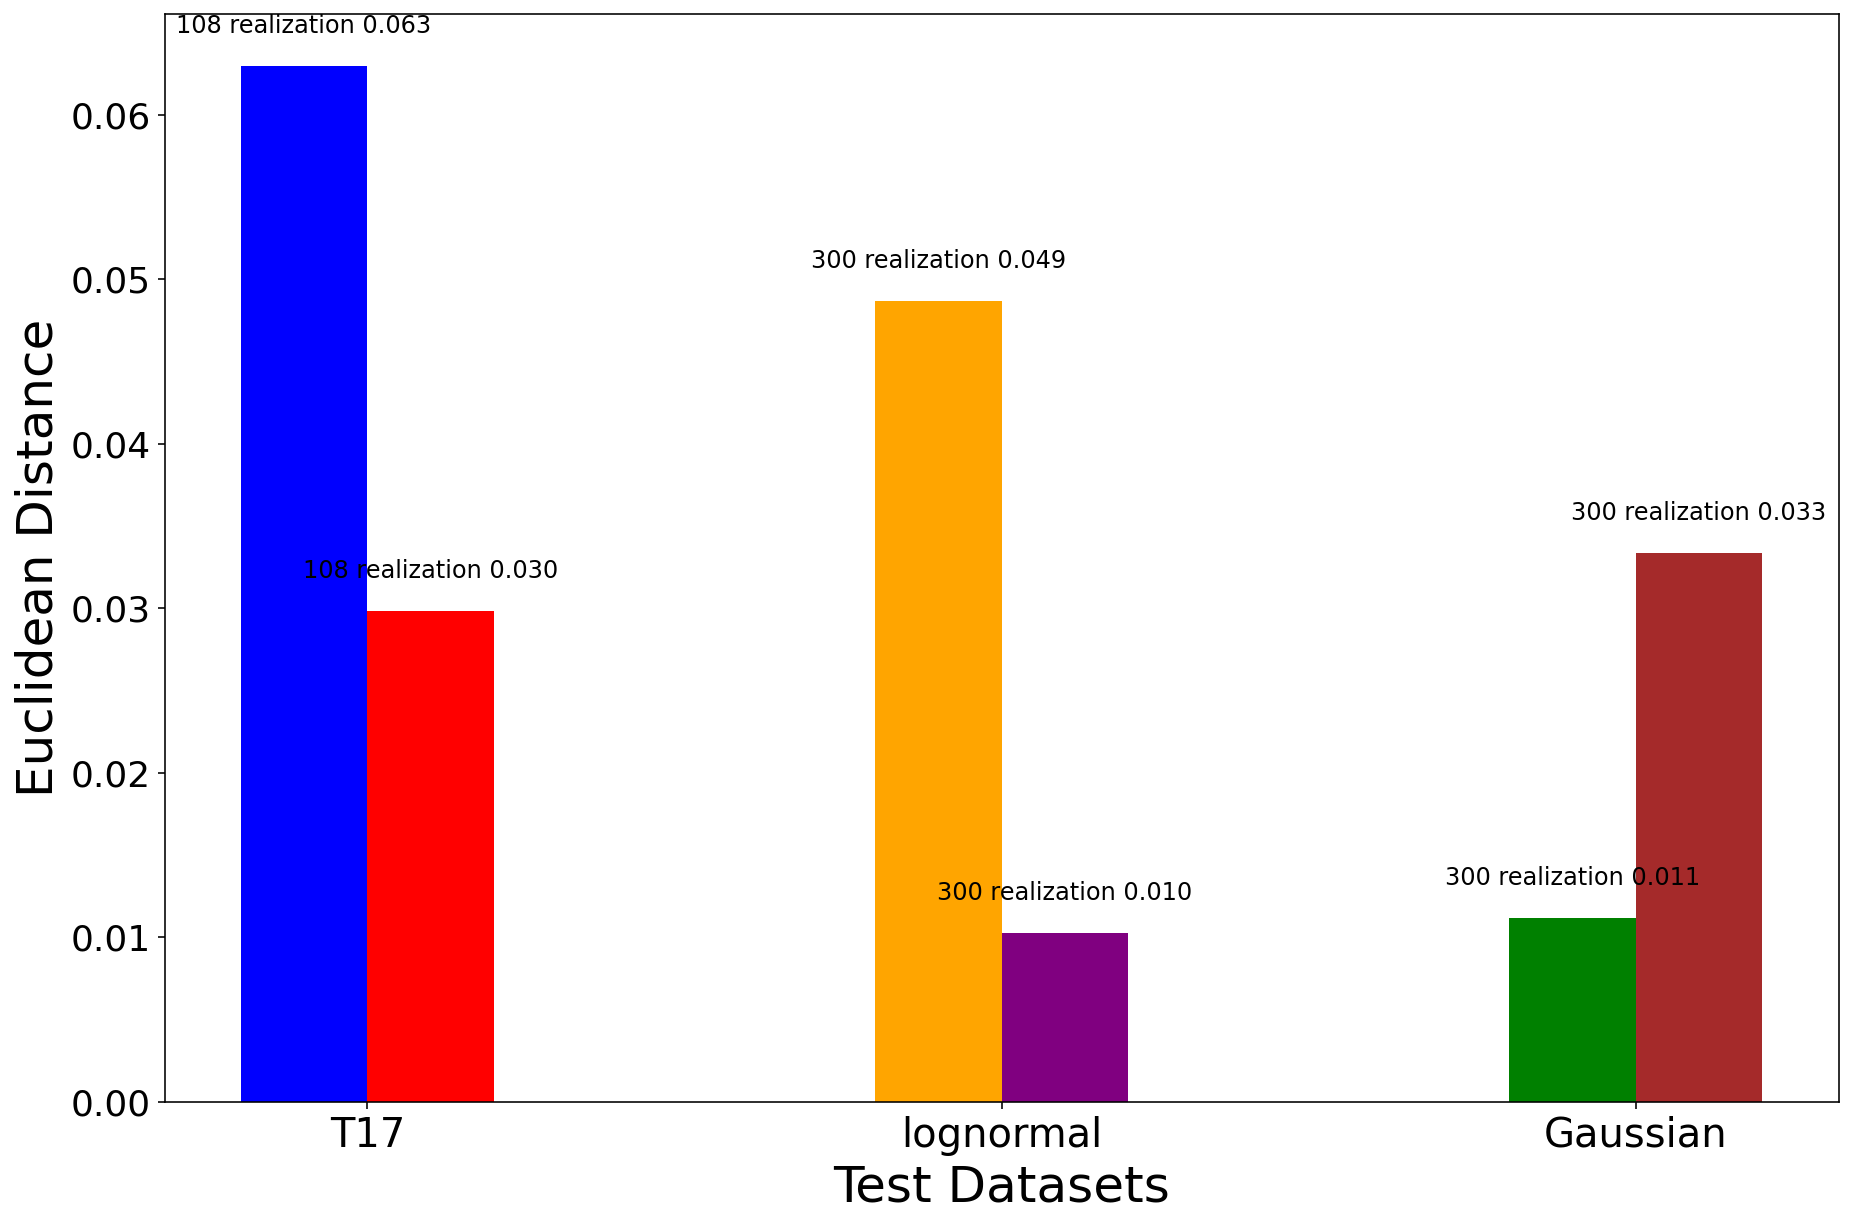

In [87]:
plt.figure(figsize=(15, 10))
for i, v in enumerate(dis_Gauss_11_S_8):
    if i==0:
        plt.text(i - bar_width *0.5, v + 0.002, f'108 realization {v:.3f}', color='black', ha='center', fontsize=12)
    else:
        plt.text(i - bar_width *0.5, v + 0.002, f'300 realization {v:.3f}', color='black', ha='center', fontsize=12)
for i, v in enumerate(dis_lognormal_11_S_8):
    if i==0:
        plt.text(i + bar_width *0.5, v + 0.002, f'108 realization {v:.3f}', color='black', ha='center', fontsize=12)
    else:
        plt.text(i + bar_width *0.5, v + 0.002, f'300 realization {v:.3f}', color='black', ha='center', fontsize=12)
plt.bar([pos - bar_width * 0.5 for pos in bar_positions], dis_Gauss_11_S_8, width=bar_width, color=colors1, label='Trained with Gaussian')
plt.bar([pos + bar_width * 0.5 for pos in bar_positions], dis_lognormal_11_S_8, width=bar_width, color=colors2, label='Trained with lognormal')
plt.yticks(fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('Euclidean Distance', fontsize=25)
plt.xlabel('Test Datasets', fontsize=25)
plt.xticks(bar_positions, bias_indicators)
#plt.legend(fontsize=15)
#plt.title('Bias Indicator Values', fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/bias_indicatos_S_8_11.jpg',bbox_inches='tight')
plt.show();

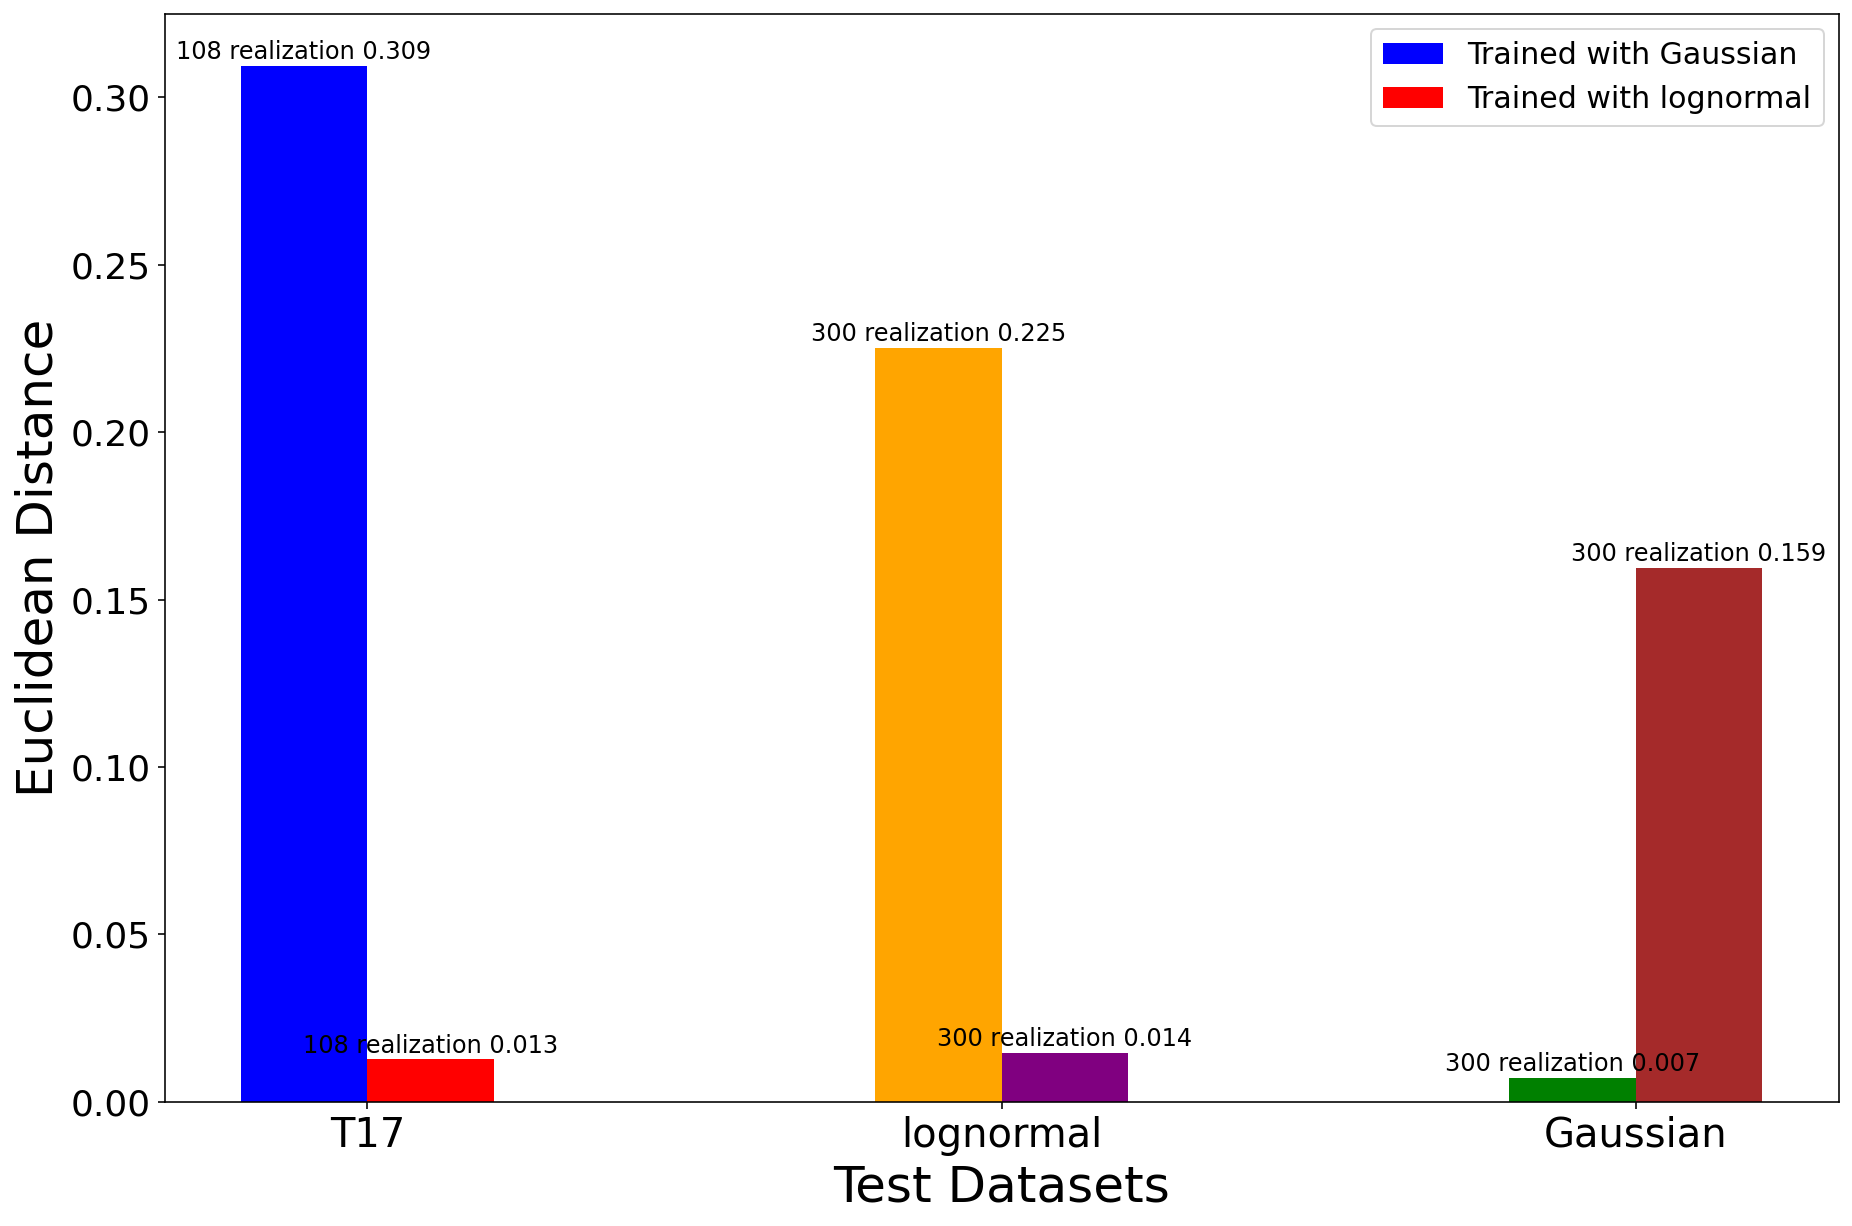

In [88]:
plt.figure(figsize=(15, 10))
for i, v in enumerate(dis_Gauss_22_S_8):
    if i==0:
        plt.text(i - bar_width *0.5, v + 0.002, f'108 realization {v:.3f}', color='black', ha='center', fontsize=12)
    else:
        plt.text(i - bar_width *0.5, v + 0.002, f'300 realization {v:.3f}', color='black', ha='center', fontsize=12)
for i, v in enumerate(dis_lognormal_22_S_8):
    if i==0:
        plt.text(i + bar_width *0.5, v + 0.002, f'108 realization {v:.3f}', color='black', ha='center', fontsize=12)
    else:
        plt.text(i + bar_width *0.5, v + 0.002, f'300 realization {v:.3f}', color='black', ha='center', fontsize=12)
plt.bar([pos - bar_width * 0.5 for pos in bar_positions], dis_Gauss_22_S_8, width=bar_width, color=colors1, label='Trained with Gaussian')
plt.bar([pos + bar_width * 0.5 for pos in bar_positions], dis_lognormal_22_S_8, width=bar_width, color=colors2, label='Trained with lognormal')
plt.yticks(fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('Euclidean Distance', fontsize=25)
plt.xlabel('Test Datasets', fontsize=25)
plt.xticks(bar_positions, bias_indicators)
plt.legend(fontsize=15)
#plt.title('Bias Indicator Values', fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/bias_indicatos_S_8_22.png',bbox_inches='tight')
plt.show();

In [89]:
mu_T17_Gauss_1_S_8                        = np.array((prediction_T17_Gauss_1_Omega_M_mean, prediction_T17_Gauss_1_S_8_mean)).T
mu_T17_Gauss_2_S_8                        = np.array((prediction_T17_Gauss_2_Omega_M_mean, prediction_T17_Gauss_2_S_8_mean)).T
mu_lognormal_1_Gauss_1_S_8                = np.array((prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_S_8_mean)).T
mu_lognormal_1_Gauss_2_S_8                = np.array((prediction_lognormal_1_Gauss_2_Omega_M_mean, prediction_lognormal_1_Gauss_2_S_8_mean)).T
mu_lognormal_2_Gauss_1_S_8                = np.array((prediction_lognormal_2_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_S_8_mean)).T
mu_lognormal_2_Gauss_2_S_8                = np.array((prediction_lognormal_2_Gauss_2_Omega_M_mean, prediction_lognormal_2_Gauss_2_S_8_mean)).T
mu_Gauss_1_Gauss_1_S_8                    = np.array((prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_S_8_mean)).T
mu_Gauss_1_Gauss_2_S_8                    = np.array((prediction_Gauss_1_Gauss_2_Omega_M_mean, prediction_Gauss_1_Gauss_2_S_8_mean)).T
mu_Gauss_2_Gauss_1_S_8                    = np.array((prediction_Gauss_2_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_S_8_mean)).T
mu_Gauss_2_Gauss_2_S_8                    = np.array((prediction_Gauss_2_Gauss_2_Omega_M_mean, prediction_Gauss_2_Gauss_2_S_8_mean)).T
mu_T17_lognormal_1_S_8                    = np.array((prediction_T17_lognormal_1_Omega_M_mean, prediction_T17_lognormal_1_S_8_mean)).T
mu_T17_lognormal_2_S_8                    = np.array((prediction_T17_lognormal_2_Omega_M_mean, prediction_T17_lognormal_2_S_8_mean)).T
mu_lognormal_1_lognormal_1_S_8            = np.array((prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_S_8_mean)).T
mu_lognormal_1_lognormal_2_S_8            = np.array((prediction_lognormal_1_lognormal_2_Omega_M_mean, prediction_lognormal_1_lognormal_2_S_8_mean)).T
mu_lognormal_2_lognormal_1_S_8            = np.array((prediction_lognormal_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_S_8_mean)).T
mu_lognormal_2_lognormal_2_S_8            = np.array((prediction_lognormal_2_lognormal_2_Omega_M_mean, prediction_lognormal_2_lognormal_2_S_8_mean)).T
mu_Gauss_1_lognormal_1_S_8                = np.array((prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_S_8_mean)).T
mu_Gauss_1_lognormal_2_S_8                = np.array((prediction_Gauss_1_lognormal_2_Omega_M_mean, prediction_Gauss_1_lognormal_2_S_8_mean)).T
mu_Gauss_2_lognormal_1_S_8                = np.array((prediction_Gauss_2_lognormal_1_Omega_M_mean, prediction_Gauss_2_lognormal_1_S_8_mean)).T
mu_Gauss_2_lognormal_2_S_8                = np.array((prediction_Gauss_2_lognormal_2_Omega_M_mean, prediction_Gauss_2_lognormal_2_S_8_mean)).T
parameter_est_T17_Gauss_1_S_8             = np.array((prediction_T17_Gauss_1[:,0],S_8_T17_Gauss_1)).T
parameter_est_T17_Gauss_2_S_8             = np.array((prediction_T17_Gauss_2[:,0],S_8_T17_Gauss_2)).T
parameter_est_lognormal_1_Gauss_1_S_8     = np.array((prediction_lognormal_1_Gauss_1[:,0],S_8_lognormal_1_Gauss_1)).T
parameter_est_lognormal_1_Gauss_2_S_8     = np.array((prediction_lognormal_1_Gauss_2[:,0],S_8_lognormal_1_Gauss_2)).T
parameter_est_lognormal_2_Gauss_1_S_8     = np.array((prediction_lognormal_2_Gauss_1[:,0],S_8_lognormal_2_Gauss_1)).T
parameter_est_lognormal_2_Gauss_2_S_8     = np.array((prediction_lognormal_2_Gauss_2[:,0],S_8_lognormal_2_Gauss_2)).T
parameter_est_Gauss_1_Gauss_1_S_8         = np.array((prediction_Gauss_1_Gauss_1[:,0],S_8_Gauss_1_Gauss_1)).T
parameter_est_Gauss_1_Gauss_2_S_8         = np.array((prediction_Gauss_1_Gauss_2[:,0],S_8_Gauss_1_Gauss_2)).T
parameter_est_Gauss_2_Gauss_1_S_8         = np.array((prediction_Gauss_2_Gauss_1[:,0],S_8_Gauss_2_Gauss_1)).T
parameter_est_Gauss_2_Gauss_2_S_8         = np.array((prediction_Gauss_2_Gauss_2[:,0],S_8_Gauss_2_Gauss_2)).T
parameter_est_T17_lognormal_1_S_8         = np.array((prediction_T17_lognormal_1[:,0],S_8_T17_lognormal_1)).T
parameter_est_T17_lognormal_2_S_8         = np.array((prediction_T17_lognormal_2[:,0],S_8_T17_lognormal_2)).T
parameter_est_lognormal_1_lognormal_1_S_8 = np.array((prediction_lognormal_1_lognormal_1[:,0],S_8_lognormal_1_lognormal_1)).T
parameter_est_lognormal_1_lognormal_2_S_8 = np.array((prediction_lognormal_1_lognormal_2[:,0],S_8_lognormal_1_lognormal_2)).T
parameter_est_lognormal_2_lognormal_1_S_8 = np.array((prediction_lognormal_2_lognormal_1[:,0],S_8_lognormal_2_lognormal_1)).T
parameter_est_lognormal_2_lognormal_2_S_8 = np.array((prediction_lognormal_2_lognormal_2[:,0],S_8_lognormal_2_lognormal_2)).T
parameter_est_Gauss_1_lognormal_1_S_8     = np.array((prediction_Gauss_1_lognormal_1[:,0],S_8_Gauss_1_lognormal_1)).T
parameter_est_Gauss_1_lognormal_2_S_8     = np.array((prediction_Gauss_1_lognormal_2[:,0],S_8_Gauss_1_lognormal_2)).T
parameter_est_Gauss_2_lognormal_1_S_8     = np.array((prediction_Gauss_2_lognormal_1[:,0],S_8_Gauss_2_lognormal_1)).T
parameter_est_Gauss_2_lognormal_2_S_8     = np.array((prediction_Gauss_2_lognormal_2[:,0],S_8_Gauss_2_lognormal_2)).T
cov_T17_Gauss_1_KDE_S8                    = cov(mu_T17_Gauss_1_S_8, parameter_est_T17_Gauss_1_S_8)
cov_T17_Gauss_2_KDE_S8                    = cov(mu_T17_Gauss_2_S_8, parameter_est_T17_Gauss_2_S_8)
cov_lognormal_1_Gauss_1_KDE_S8            = cov(mu_lognormal_1_Gauss_1_S_8, parameter_est_lognormal_1_Gauss_1_S_8)
cov_lognormal_1_Gauss_2_KDE_S8            = cov(mu_lognormal_1_Gauss_2_S_8, parameter_est_lognormal_1_Gauss_2_S_8)
cov_lognormal_2_Gauss_1_KDE_S8            = cov(mu_lognormal_2_Gauss_1_S_8, parameter_est_lognormal_2_Gauss_1_S_8)
cov_lognormal_2_Gauss_2_KDE_S8            = cov(mu_lognormal_2_Gauss_2_S_8, parameter_est_lognormal_2_Gauss_2_S_8)
cov_Gauss_1_Gauss_1_KDE_S8                = cov(mu_Gauss_1_Gauss_1_S_8, parameter_est_Gauss_1_Gauss_1_S_8)
cov_Gauss_1_Gauss_2_KDE_S8                = cov(mu_Gauss_1_Gauss_2_S_8, parameter_est_Gauss_1_Gauss_2_S_8)
cov_Gauss_2_Gauss_1_KDE_S8                = cov(mu_Gauss_2_Gauss_1_S_8, parameter_est_Gauss_2_Gauss_1_S_8)
cov_Gauss_2_Gauss_2_KDE_S8                = cov(mu_Gauss_2_Gauss_2_S_8, parameter_est_Gauss_2_Gauss_2_S_8)
cov_T17_lognormal_1_KDE_S8                = cov(mu_T17_lognormal_1_S_8, parameter_est_T17_lognormal_1_S_8)
cov_T17_lognormal_2_KDE_S8                = cov(mu_T17_lognormal_2_S_8, parameter_est_T17_lognormal_2_S_8)
cov_lognormal_1_lognormal_1_KDE_S8        = cov(mu_lognormal_1_lognormal_1_S_8, parameter_est_lognormal_1_lognormal_1_S_8)
cov_lognormal_1_lognormal_2_KDE_S8        = cov(mu_lognormal_1_lognormal_2_S_8, parameter_est_lognormal_1_lognormal_2_S_8)
cov_lognormal_2_lognormal_1_KDE_S8        = cov(mu_lognormal_2_lognormal_1_S_8, parameter_est_lognormal_2_lognormal_1_S_8)
cov_lognormal_2_lognormal_2_KDE_S8        = cov(mu_lognormal_2_lognormal_2_S_8, parameter_est_lognormal_2_lognormal_2_S_8)
cov_Gauss_1_lognormal_1_KDE_S8            = cov(mu_Gauss_1_lognormal_1_S_8, parameter_est_Gauss_1_lognormal_1_S_8)
cov_Gauss_1_lognormal_2_KDE_S8            = cov(mu_Gauss_1_lognormal_2_S_8, parameter_est_Gauss_1_lognormal_2_S_8)
cov_Gauss_2_lognormal_1_KDE_S8            = cov(mu_Gauss_2_lognormal_1_S_8, parameter_est_Gauss_2_lognormal_1_S_8)
cov_Gauss_2_lognormal_2_KDE_S8            = cov(mu_Gauss_2_lognormal_2_S_8, parameter_est_Gauss_2_lognormal_2_S_8)

In [90]:
prior_down_S_8=0.5*np.sqrt(0.15/0.3)
prior_up_S_8=1.1*np.sqrt(0.45/0.3)
print(prior_down_S_8)
print(prior_up_S_8)

0.3535533905932738
1.347219358530748


In [91]:
prior_ranges = {'\Omega_m': (0.15, 0.45), 'S_8': (prior_down_S_8, prior_up_S_8)}
param_names = ['\Omega_m', 'S_8']
#T17 likelihood
nsamp = 100000
samples_T17_Gauss_1_KDE_S_8                   = np.random.multivariate_normal(mu_T17_Gauss_1_S_8, cov_T17_Gauss_1_KDE_S8, size=nsamp)
samples_T17_Gauss_2_KDE_S_8                   = np.random.multivariate_normal(mu_T17_Gauss_2_S_8, cov_T17_Gauss_2_KDE_S8, size=nsamp)
samples_Gauss_1_Gauss_1_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_1_Gauss_1_S_8, cov_Gauss_1_Gauss_1_KDE_S8, size=nsamp)
samples_Gauss_1_Gauss_2_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_1_Gauss_2_S_8, cov_Gauss_1_Gauss_2_KDE_S8, size=nsamp)
samples_Gauss_2_Gauss_1_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_2_Gauss_1_S_8, cov_Gauss_2_Gauss_1_KDE_S8, size=nsamp)
samples_Gauss_2_Gauss_2_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_2_Gauss_2_S_8, cov_Gauss_2_Gauss_2_KDE_S8, size=nsamp)
samples_lognormal_1_Gauss_1_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_1_Gauss_1_S_8, cov_lognormal_1_Gauss_1_KDE_S8, size=nsamp)
samples_lognormal_1_Gauss_2_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_1_Gauss_2_S_8, cov_lognormal_1_Gauss_2_KDE_S8, size=nsamp)
samples_lognormal_2_Gauss_1_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_2_Gauss_1_S_8, cov_lognormal_2_Gauss_1_KDE_S8, size=nsamp)
samples_lognormal_2_Gauss_2_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_2_Gauss_2_S_8, cov_lognormal_2_Gauss_2_KDE_S8, size=nsamp)
samples_T17_Gauss_1_mcsamples_KDE_S_8         = MCSamples(samples=samples_T17_Gauss_1_KDE_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_Gauss_2_mcsamples_KDE_S_8         = MCSamples(samples=samples_T17_Gauss_2_KDE_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_1_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_1_Gauss_1_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_2_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_1_Gauss_2_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_1_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_2_Gauss_1_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_2_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_2_Gauss_2_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_1_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_1_Gauss_1_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_2_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_1_Gauss_2_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_1_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_2_Gauss_1_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_2_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_2_Gauss_2_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_Gauss_KDE_S_8_11 = [samples_T17_Gauss_1_mcsamples_KDE_S_8, samples_lognormal_1_Gauss_1_mcsamples_KDE_S_8, samples_Gauss_1_Gauss_1_mcsamples_KDE_S_8]
all_samples_Gauss_KDE_S_8_12 = [samples_T17_Gauss_2_mcsamples_KDE_S_8, samples_lognormal_1_Gauss_2_mcsamples_KDE_S_8, samples_Gauss_1_Gauss_2_mcsamples_KDE_S_8]
all_samples_Gauss_KDE_S_8_21 = [samples_T17_Gauss_1_mcsamples_KDE_S_8, samples_lognormal_2_Gauss_1_mcsamples_KDE_S_8, samples_Gauss_2_Gauss_1_mcsamples_KDE_S_8]
all_samples_Gauss_KDE_S_8_22 = [samples_T17_Gauss_2_mcsamples_KDE_S_8, samples_lognormal_2_Gauss_2_mcsamples_KDE_S_8, samples_Gauss_2_Gauss_2_mcsamples_KDE_S_8]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


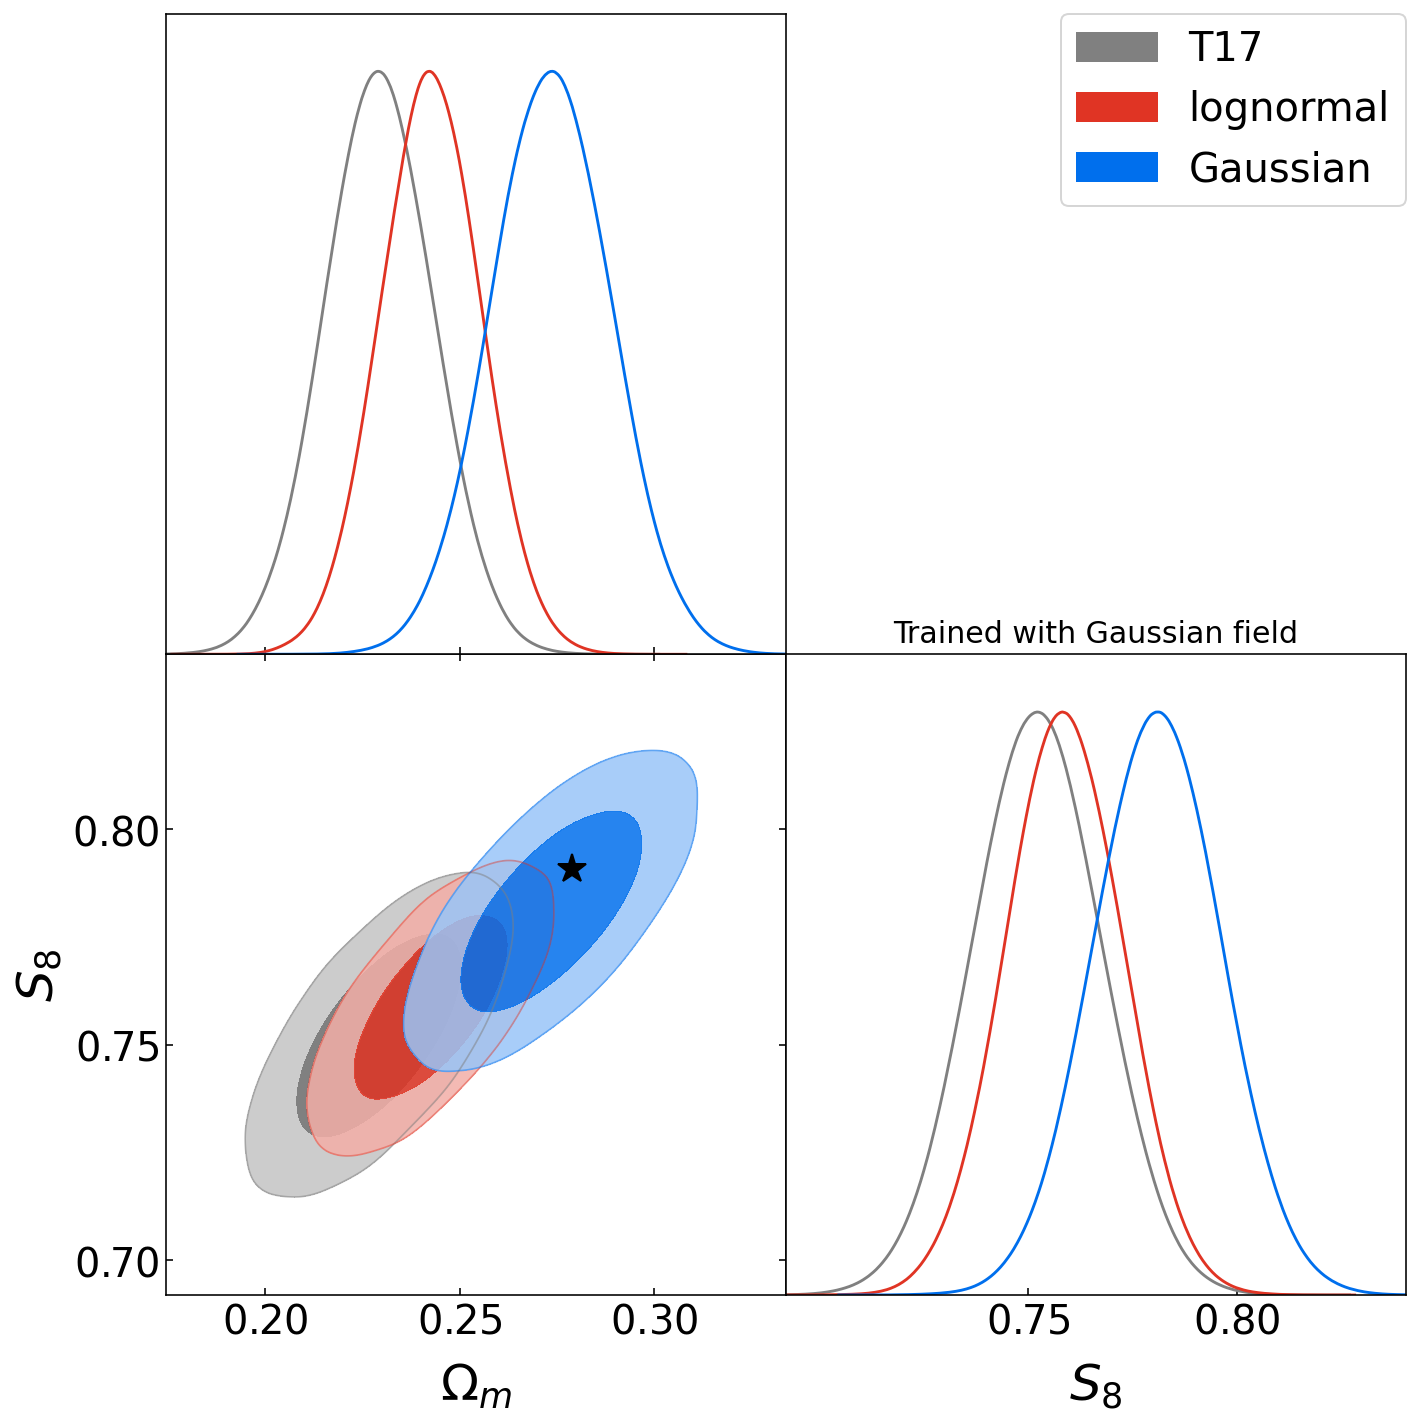

In [92]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_Gauss_KDE_S_8_11, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Trained with Gaussian field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Posterior_Train_Gauss_KDE_S_8_11.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

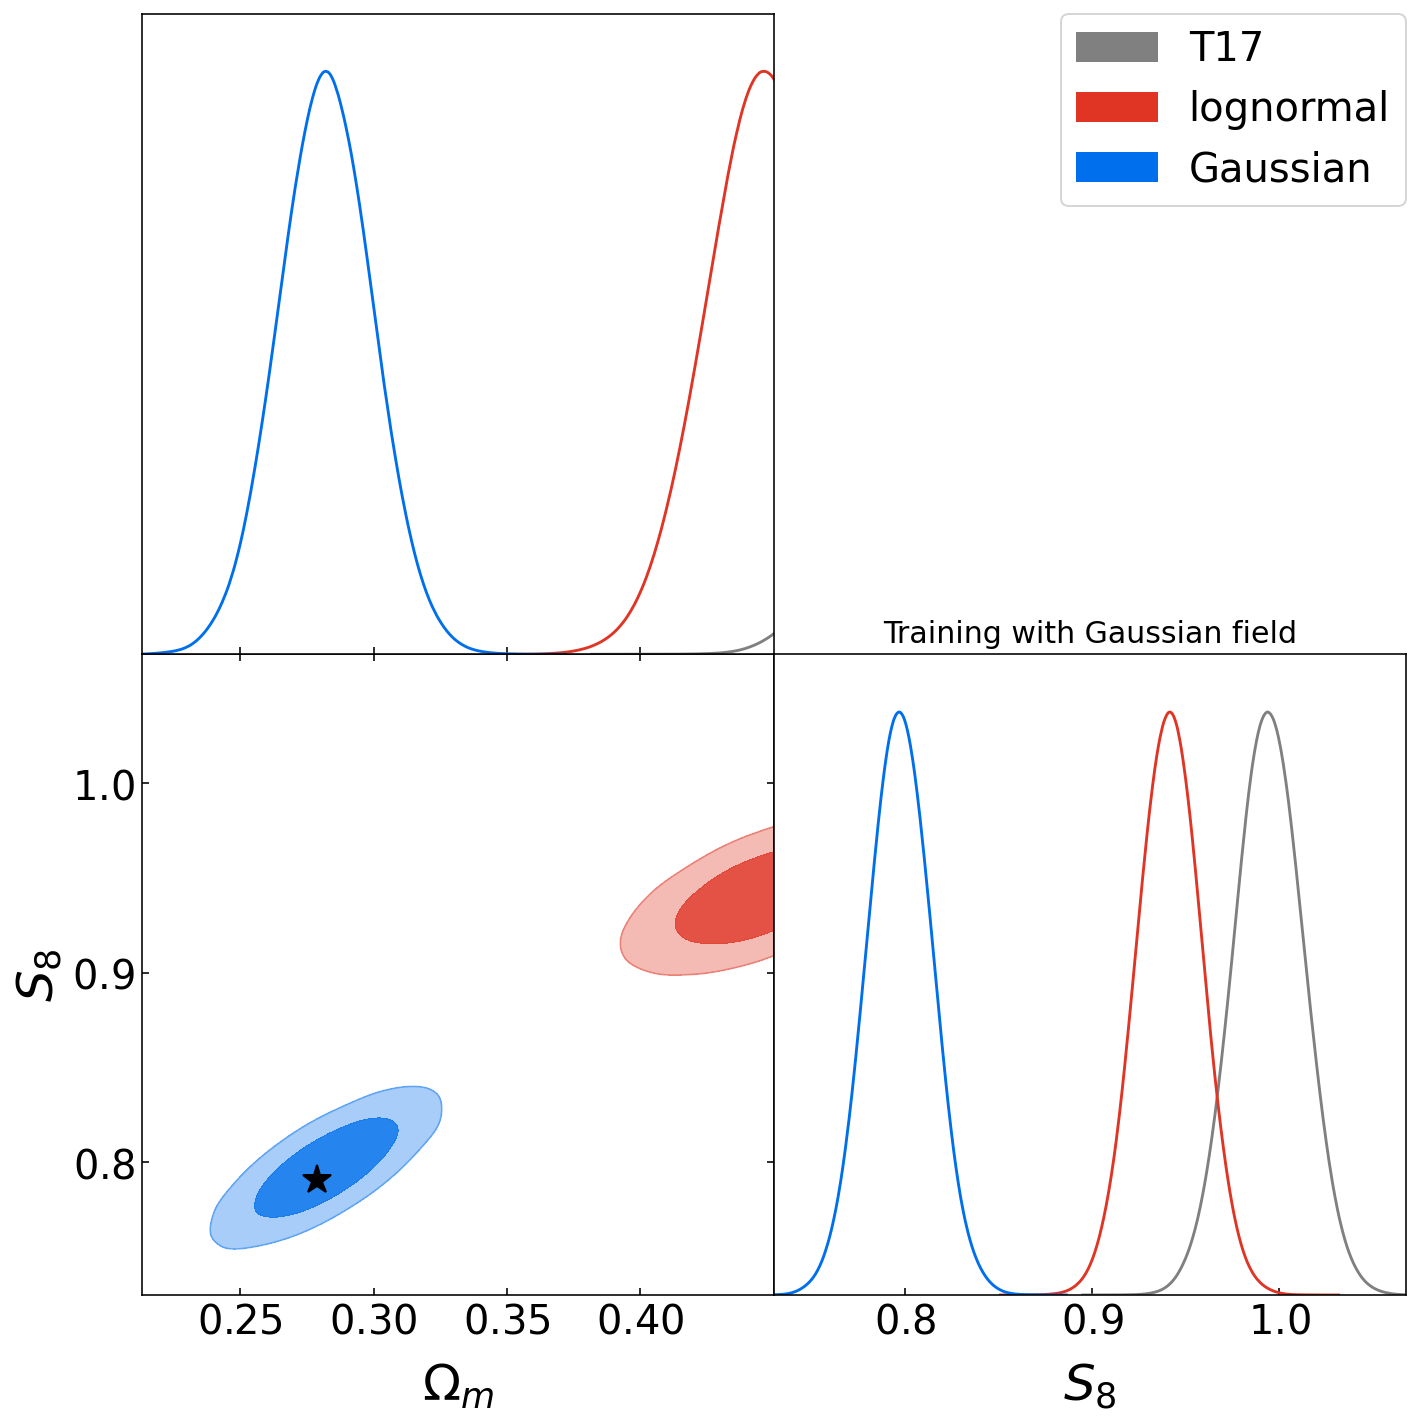

In [93]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_Gauss_KDE_S_8_22, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Training with Gaussian field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_Gauss_KDE_S_8_22.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [94]:
prior_ranges = {'\Omega_m': (0.15, 0.45), 'S_8': (prior_down_S_8, prior_up_S_8)}
param_names = ['\Omega_m', 'S_8']
#T17 likelihood
nsamp = 100000
samples_T17_lognormal_1_KDE_S_8                   = np.random.multivariate_normal(mu_T17_lognormal_1_S_8, cov_T17_lognormal_1_KDE_S8, size=nsamp)
samples_T17_lognormal_2_KDE_S_8                   = np.random.multivariate_normal(mu_T17_lognormal_2_S_8, cov_T17_lognormal_2_KDE_S8, size=nsamp)
samples_Gauss_1_lognormal_1_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_1_lognormal_1_S_8, cov_Gauss_1_lognormal_1_KDE_S8, size=nsamp)
samples_Gauss_1_lognormal_2_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_1_lognormal_2_S_8, cov_Gauss_1_lognormal_2_KDE_S8, size=nsamp)
samples_Gauss_2_lognormal_1_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_2_lognormal_1_S_8, cov_Gauss_2_lognormal_1_KDE_S8, size=nsamp)
samples_Gauss_2_lognormal_2_KDE_S_8               = np.random.multivariate_normal(mu_Gauss_2_lognormal_2_S_8, cov_Gauss_2_lognormal_2_KDE_S8, size=nsamp)
samples_lognormal_1_lognormal_1_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_1_lognormal_1_S_8, cov_lognormal_1_lognormal_1_KDE_S8, size=nsamp)
samples_lognormal_1_lognormal_2_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_1_lognormal_2_S_8, cov_lognormal_1_lognormal_2_KDE_S8, size=nsamp)
samples_lognormal_2_lognormal_1_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_2_lognormal_1_S_8, cov_lognormal_2_lognormal_1_KDE_S8, size=nsamp)
samples_lognormal_2_lognormal_2_KDE_S_8           = np.random.multivariate_normal(mu_lognormal_2_lognormal_2_S_8, cov_lognormal_2_lognormal_2_KDE_S8, size=nsamp)
samples_T17_lognormal_1_mcsamples_KDE_S_8         = MCSamples(samples=samples_T17_lognormal_1_KDE_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_lognormal_2_mcsamples_KDE_S_8         = MCSamples(samples=samples_T17_lognormal_2_KDE_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_1_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_1_lognormal_1_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_2_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_1_lognormal_2_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_1_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_2_lognormal_1_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_2_mcsamples_KDE_S_8 = MCSamples(samples=samples_lognormal_2_lognormal_2_KDE_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_1_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_1_lognormal_1_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_2_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_1_lognormal_2_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_1_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_2_lognormal_1_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_2_mcsamples_KDE_S_8     = MCSamples(samples=samples_Gauss_2_lognormal_2_KDE_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_lognormal_KDE_S_8_11 = [samples_T17_lognormal_1_mcsamples_KDE_S_8, samples_lognormal_1_lognormal_1_mcsamples_KDE_S_8, samples_Gauss_1_lognormal_1_mcsamples_KDE_S_8]
all_samples_lognormal_KDE_S_8_12 = [samples_T17_lognormal_2_mcsamples_KDE_S_8, samples_lognormal_1_lognormal_2_mcsamples_KDE_S_8, samples_Gauss_1_lognormal_2_mcsamples_KDE_S_8]
all_samples_lognormal_KDE_S_8_21 = [samples_T17_lognormal_1_mcsamples_KDE_S_8, samples_lognormal_2_lognormal_1_mcsamples_KDE_S_8, samples_Gauss_2_lognormal_1_mcsamples_KDE_S_8]
all_samples_lognormal_KDE_S_8_22 = [samples_T17_lognormal_2_mcsamples_KDE_S_8, samples_lognormal_2_lognormal_2_mcsamples_KDE_S_8, samples_Gauss_2_lognormal_2_mcsamples_KDE_S_8]
labels = ['T17', 'lognormal', 'Gauß']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


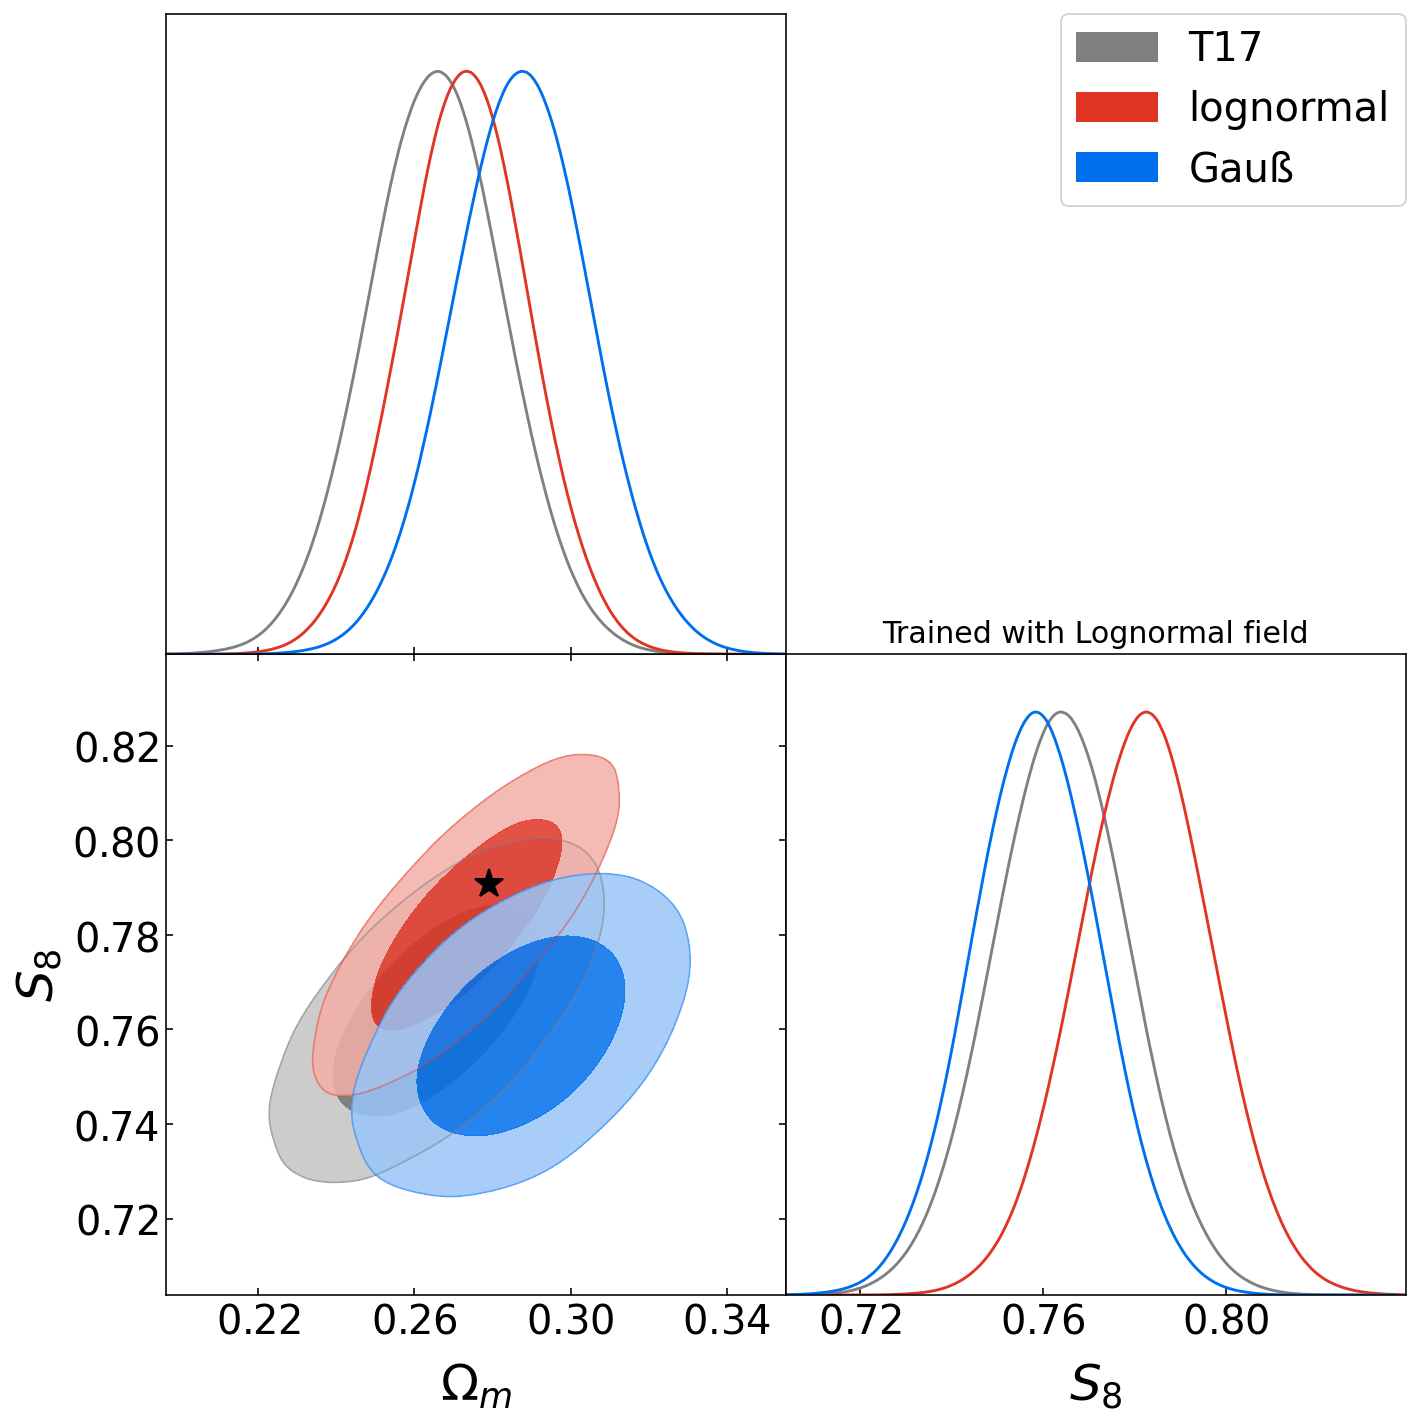

In [95]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_lognormal_KDE_S_8_11, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Trained with Lognormal field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_lognormal_KDE_S_8_11.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

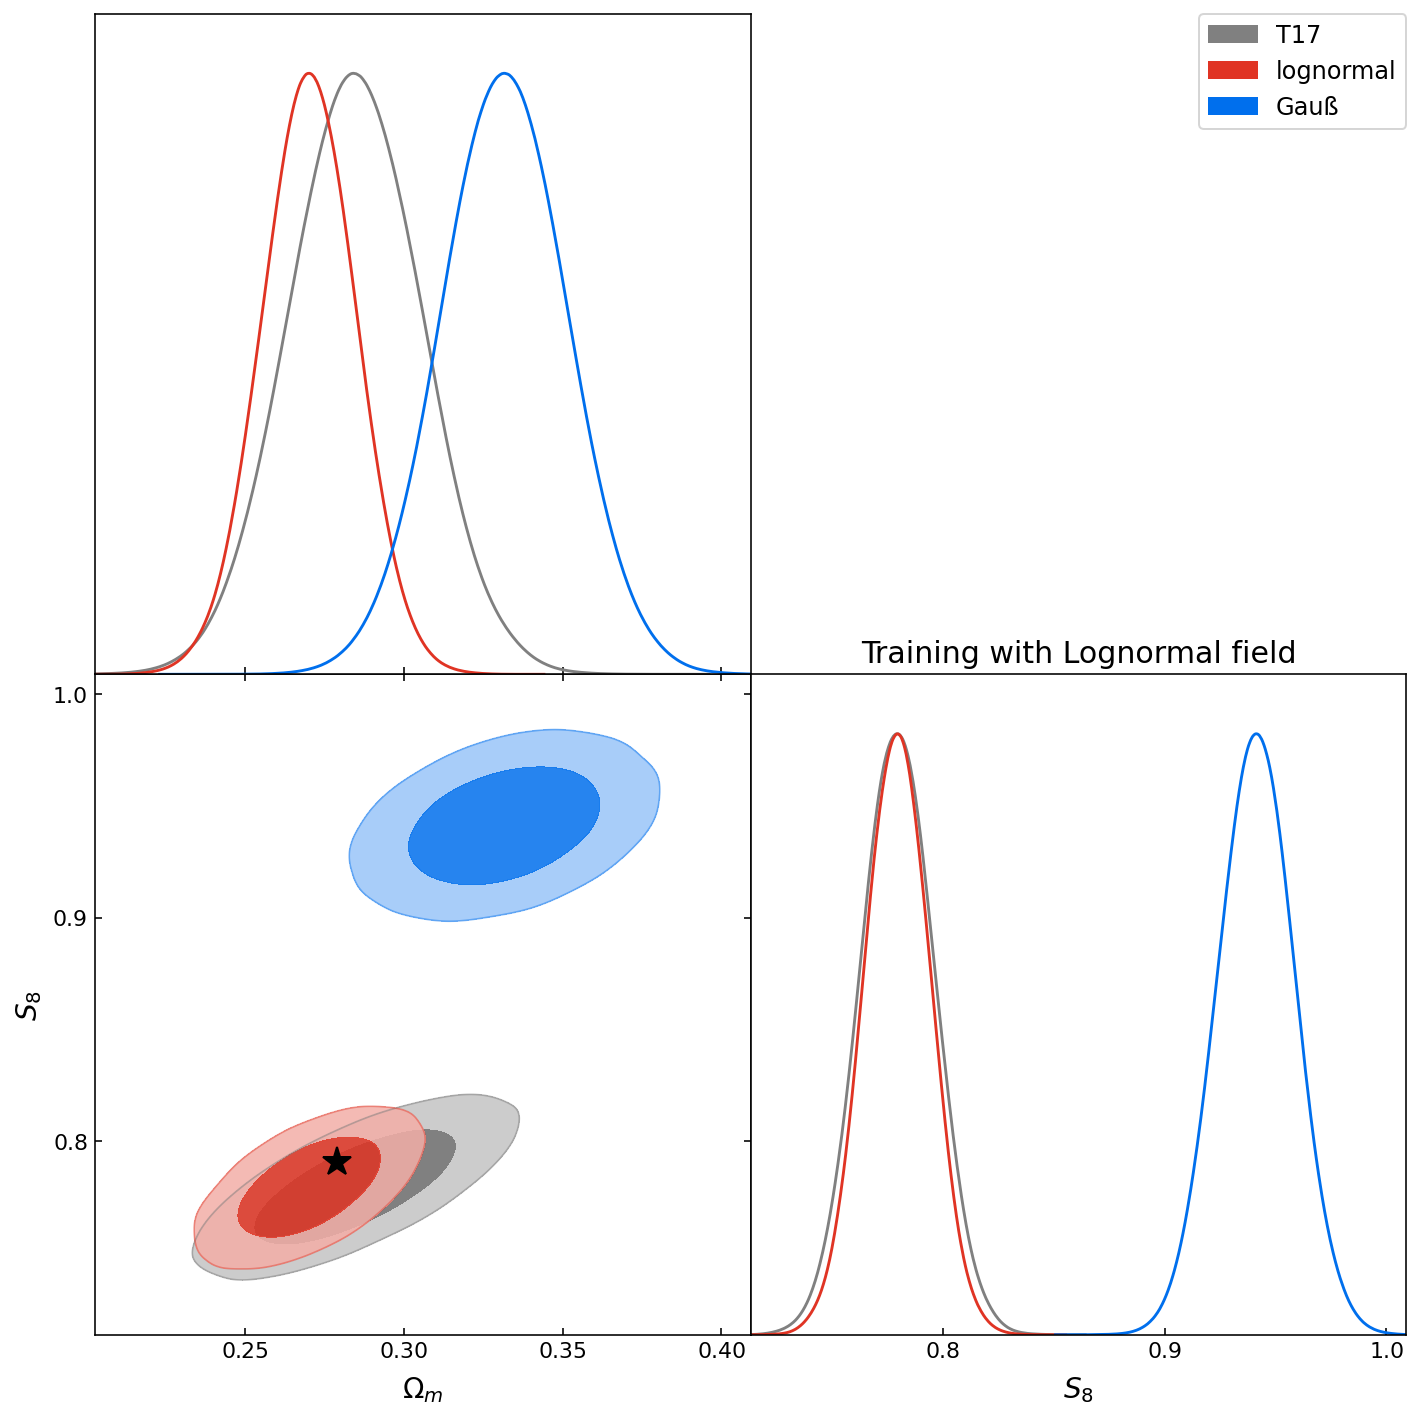

In [96]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)

# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_lognormal_KDE_S_8_22, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Training with Lognormal field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_lognormal_KDE_S_8_22.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Using Covariance from GCNN Networks
## $cov(\Omega_m,S_8)=J(\Omega_m,S_8)cov(\Omega_m,\sigma_8)J^T(\Omega_m,\sigma_8)$
## $J=\begin{pmatrix}\frac{\partial\Omega_m}{\partial\Omega_m}&\frac{\partial\Omega_m}{\partial\sigma_8}\\\frac{\partial S_8}{\partial\Omega_m}&\frac{\partial S_8}{\partial\sigma_8}\end{pmatrix}=\begin{pmatrix}1&-0.9S^2_8\sigma^{-3}_8\\\frac{1}{2\sqrt{0.3}}\frac{\sigma_8}{\sqrt{\Omega_m}}&\sqrt{\frac{\Omega_m}{0.3}}\end{pmatrix}$

In [97]:
def calculate_jacobian(omega_m, sigma_8):
    S_8=sigma_8*np.sqrt(omega_m/0.3)
    element_11 = 1.0
    element_12 = -0.9 * S_8**2 * sigma_8**(-3)
    element_21 = 0.5 * sigma_8 / (np.sqrt(0.3) * np.sqrt(omega_m))
    element_22 = np.sqrt(omega_m / 0.3)
    jacobian_matrix = np.array([[element_11, element_12],
                                [element_21, element_22]])
    
    return jacobian_matrix

In [98]:
J_T17_Gauss_1             = calculate_jacobian(prediction_T17_Gauss_1_Omega_M_mean,prediction_T17_Gauss_1_sigma_8_mean)
J_T17_Gauss_2             = calculate_jacobian(prediction_T17_Gauss_2_Omega_M_mean,prediction_T17_Gauss_2_sigma_8_mean)
J_lognormal_1_Gauss_1     = calculate_jacobian(prediction_lognormal_1_Gauss_1_Omega_M_mean,prediction_lognormal_1_Gauss_1_sigma_8_mean)
J_lognormal_1_Gauss_2     = calculate_jacobian(prediction_lognormal_1_Gauss_2_Omega_M_mean,prediction_lognormal_1_Gauss_2_sigma_8_mean)
J_lognormal_2_Gauss_1     = calculate_jacobian(prediction_lognormal_2_Gauss_1_Omega_M_mean,prediction_lognormal_2_Gauss_1_sigma_8_mean)
J_lognormal_2_Gauss_2     = calculate_jacobian(prediction_lognormal_2_Gauss_2_Omega_M_mean,prediction_lognormal_2_Gauss_2_sigma_8_mean)
J_Gauss_1_Gauss_1         = calculate_jacobian(prediction_Gauss_1_Gauss_1_Omega_M_mean,prediction_Gauss_1_Gauss_1_sigma_8_mean)
J_Gauss_1_Gauss_2         = calculate_jacobian(prediction_Gauss_1_Gauss_2_Omega_M_mean,prediction_Gauss_1_Gauss_2_sigma_8_mean)
J_Gauss_2_Gauss_1         = calculate_jacobian(prediction_Gauss_2_Gauss_1_Omega_M_mean,prediction_Gauss_2_Gauss_1_sigma_8_mean)
J_Gauss_2_Gauss_2         = calculate_jacobian(prediction_Gauss_2_Gauss_2_Omega_M_mean,prediction_Gauss_2_Gauss_2_sigma_8_mean)
J_T17_lognormal_1         = calculate_jacobian(prediction_T17_lognormal_1_Omega_M_mean,prediction_T17_lognormal_1_sigma_8_mean)
J_T17_lognormal_2         = calculate_jacobian(prediction_T17_lognormal_2_Omega_M_mean,prediction_T17_lognormal_2_sigma_8_mean)
J_lognormal_1_lognormal_1 = calculate_jacobian(prediction_lognormal_1_lognormal_1_Omega_M_mean,prediction_lognormal_1_lognormal_1_sigma_8_mean)
J_lognormal_1_lognormal_2 = calculate_jacobian(prediction_lognormal_1_lognormal_2_Omega_M_mean,prediction_lognormal_1_lognormal_2_sigma_8_mean)
J_lognormal_2_lognormal_1 = calculate_jacobian(prediction_lognormal_2_lognormal_1_Omega_M_mean,prediction_lognormal_2_lognormal_1_sigma_8_mean)
J_lognormal_2_lognormal_2 = calculate_jacobian(prediction_lognormal_2_lognormal_2_Omega_M_mean,prediction_lognormal_2_lognormal_2_sigma_8_mean)
J_Gauss_1_lognormal_1     = calculate_jacobian(prediction_Gauss_1_lognormal_1_Omega_M_mean,prediction_Gauss_1_lognormal_1_sigma_8_mean)
J_Gauss_1_lognormal_2     = calculate_jacobian(prediction_Gauss_1_lognormal_2_Omega_M_mean,prediction_Gauss_1_lognormal_2_sigma_8_mean)
J_Gauss_2_lognormal_1     = calculate_jacobian(prediction_Gauss_2_lognormal_1_Omega_M_mean,prediction_Gauss_2_lognormal_1_sigma_8_mean)
J_Gauss_2_lognormal_2     = calculate_jacobian(prediction_Gauss_2_lognormal_2_Omega_M_mean,prediction_Gauss_2_lognormal_2_sigma_8_mean)

cov_S8_T17_Gauss_1_mean             = J_T17_Gauss_1             @cov_T17_Gauss_1_mean             @J_T17_Gauss_1.T
cov_S8_T17_Gauss_2_mean             = J_T17_Gauss_2             @cov_T17_Gauss_2_mean             @J_T17_Gauss_2.T
cov_S8_lognormal_1_Gauss_1_mean     = J_lognormal_1_Gauss_1     @cov_lognormal_1_Gauss_1_mean     @J_lognormal_1_Gauss_1.T
cov_S8_lognormal_1_Gauss_2_mean     = J_lognormal_1_Gauss_2     @cov_lognormal_1_Gauss_2_mean     @J_lognormal_1_Gauss_2.T
cov_S8_lognormal_2_Gauss_1_mean     = J_lognormal_2_Gauss_1     @cov_lognormal_2_Gauss_1_mean     @J_lognormal_2_Gauss_1.T
cov_S8_lognormal_2_Gauss_2_mean     = J_lognormal_2_Gauss_2     @cov_lognormal_2_Gauss_2_mean     @J_lognormal_2_Gauss_2.T
cov_S8_Gauss_1_Gauss_1_mean         = J_Gauss_1_Gauss_1         @cov_Gauss_1_Gauss_1_mean         @J_Gauss_1_Gauss_1.T
cov_S8_Gauss_1_Gauss_2_mean         = J_Gauss_1_Gauss_2         @cov_Gauss_1_Gauss_2_mean         @J_Gauss_1_Gauss_2.T
cov_S8_Gauss_2_Gauss_1_mean         = J_Gauss_2_Gauss_1         @cov_Gauss_2_Gauss_1_mean         @J_Gauss_2_Gauss_1.T
cov_S8_Gauss_2_Gauss_2_mean         = J_Gauss_2_Gauss_2         @cov_Gauss_2_Gauss_2_mean         @J_Gauss_2_Gauss_2.T
cov_S8_T17_lognormal_1_mean         = J_T17_lognormal_1         @cov_T17_lognormal_1_mean         @J_T17_lognormal_1.T
cov_S8_T17_lognormal_2_mean         = J_T17_lognormal_2         @cov_T17_lognormal_2_mean         @J_T17_lognormal_2.T
cov_S8_lognormal_1_lognormal_1_mean = J_lognormal_1_lognormal_1 @cov_lognormal_1_lognormal_1_mean @J_lognormal_1_lognormal_1.T
cov_S8_lognormal_1_lognormal_2_mean = J_lognormal_1_lognormal_2 @cov_lognormal_1_lognormal_2_mean @J_lognormal_1_lognormal_2.T
cov_S8_lognormal_2_lognormal_1_mean = J_lognormal_2_lognormal_1 @cov_lognormal_2_lognormal_1_mean @J_lognormal_2_lognormal_1.T
cov_S8_lognormal_2_lognormal_2_mean = J_lognormal_2_lognormal_2 @cov_lognormal_2_lognormal_2_mean @J_lognormal_2_lognormal_2.T
cov_S8_Gauss_1_lognormal_1_mean     = J_Gauss_1_lognormal_1     @cov_Gauss_1_lognormal_1_mean     @J_Gauss_1_lognormal_1.T
cov_S8_Gauss_1_lognormal_2_mean     = J_Gauss_1_lognormal_2     @cov_Gauss_1_lognormal_2_mean     @J_Gauss_1_lognormal_2.T
cov_S8_Gauss_2_lognormal_1_mean     = J_Gauss_2_lognormal_1     @cov_Gauss_2_lognormal_1_mean     @J_Gauss_2_lognormal_1.T
cov_S8_Gauss_2_lognormal_2_mean     = J_Gauss_2_lognormal_2     @cov_Gauss_2_lognormal_2_mean     @J_Gauss_2_lognormal_2.T

In [99]:
prior_ranges = {'\Omega_m': (0.15, 0.45), 'S_8': (prior_down_S_8, prior_up_S_8)}
param_names = ['\Omega_m', 'S_8']
#T17 likelihood
nsamp = 100000
samples_T17_Gauss_1_mean_S_8                   = np.random.multivariate_normal(mu_T17_Gauss_1_S_8, cov_S8_T17_Gauss_1_mean, size=nsamp)
samples_T17_Gauss_2_mean_S_8                   = np.random.multivariate_normal(mu_T17_Gauss_2_S_8, cov_S8_T17_Gauss_2_mean, size=nsamp)
samples_Gauss_1_Gauss_1_mean_S_8               = np.random.multivariate_normal(mu_Gauss_1_Gauss_1_S_8, cov_S8_Gauss_1_Gauss_1_mean, size=nsamp)
samples_Gauss_1_Gauss_2_mean_S_8               = np.random.multivariate_normal(mu_Gauss_1_Gauss_2_S_8, cov_S8_Gauss_1_Gauss_2_mean, size=nsamp)
samples_Gauss_2_Gauss_1_mean_S_8               = np.random.multivariate_normal(mu_Gauss_2_Gauss_1_S_8, cov_S8_Gauss_2_Gauss_1_mean, size=nsamp)
samples_Gauss_2_Gauss_2_mean_S_8               = np.random.multivariate_normal(mu_Gauss_2_Gauss_2_S_8, cov_S8_Gauss_2_Gauss_2_mean, size=nsamp)
samples_lognormal_1_Gauss_1_mean_S_8           = np.random.multivariate_normal(mu_lognormal_1_Gauss_1_S_8, cov_S8_lognormal_1_Gauss_1_mean, size=nsamp)
samples_lognormal_1_Gauss_2_mean_S_8           = np.random.multivariate_normal(mu_lognormal_1_Gauss_2_S_8, cov_S8_lognormal_1_Gauss_2_mean, size=nsamp)
samples_lognormal_2_Gauss_1_mean_S_8           = np.random.multivariate_normal(mu_lognormal_2_Gauss_1_S_8, cov_S8_lognormal_2_Gauss_1_mean, size=nsamp)
samples_lognormal_2_Gauss_2_mean_S_8           = np.random.multivariate_normal(mu_lognormal_2_Gauss_2_S_8, cov_S8_lognormal_2_Gauss_2_mean, size=nsamp)
samples_T17_Gauss_1_mcsamples_mean_S_8         = MCSamples(samples=samples_T17_Gauss_1_mean_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_Gauss_2_mcsamples_mean_S_8         = MCSamples(samples=samples_T17_Gauss_2_mean_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_1_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_1_Gauss_1_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_2_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_1_Gauss_2_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_1_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_2_Gauss_1_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_2_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_2_Gauss_2_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_1_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_1_Gauss_1_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_2_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_1_Gauss_2_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_1_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_2_Gauss_1_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_2_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_2_Gauss_2_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_Gauss_mean_S_8_11 = [samples_T17_Gauss_1_mcsamples_mean_S_8, samples_lognormal_1_Gauss_1_mcsamples_mean_S_8, samples_Gauss_1_Gauss_1_mcsamples_mean_S_8]
all_samples_Gauss_mean_S_8_12 = [samples_T17_Gauss_2_mcsamples_mean_S_8, samples_lognormal_1_Gauss_2_mcsamples_mean_S_8, samples_Gauss_1_Gauss_2_mcsamples_mean_S_8]
all_samples_Gauss_mean_S_8_21 = [samples_T17_Gauss_1_mcsamples_mean_S_8, samples_lognormal_2_Gauss_1_mcsamples_mean_S_8, samples_Gauss_2_Gauss_1_mcsamples_mean_S_8]
all_samples_Gauss_mean_S_8_22 = [samples_T17_Gauss_2_mcsamples_mean_S_8, samples_lognormal_2_Gauss_2_mcsamples_mean_S_8, samples_Gauss_2_Gauss_2_mcsamples_mean_S_8]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


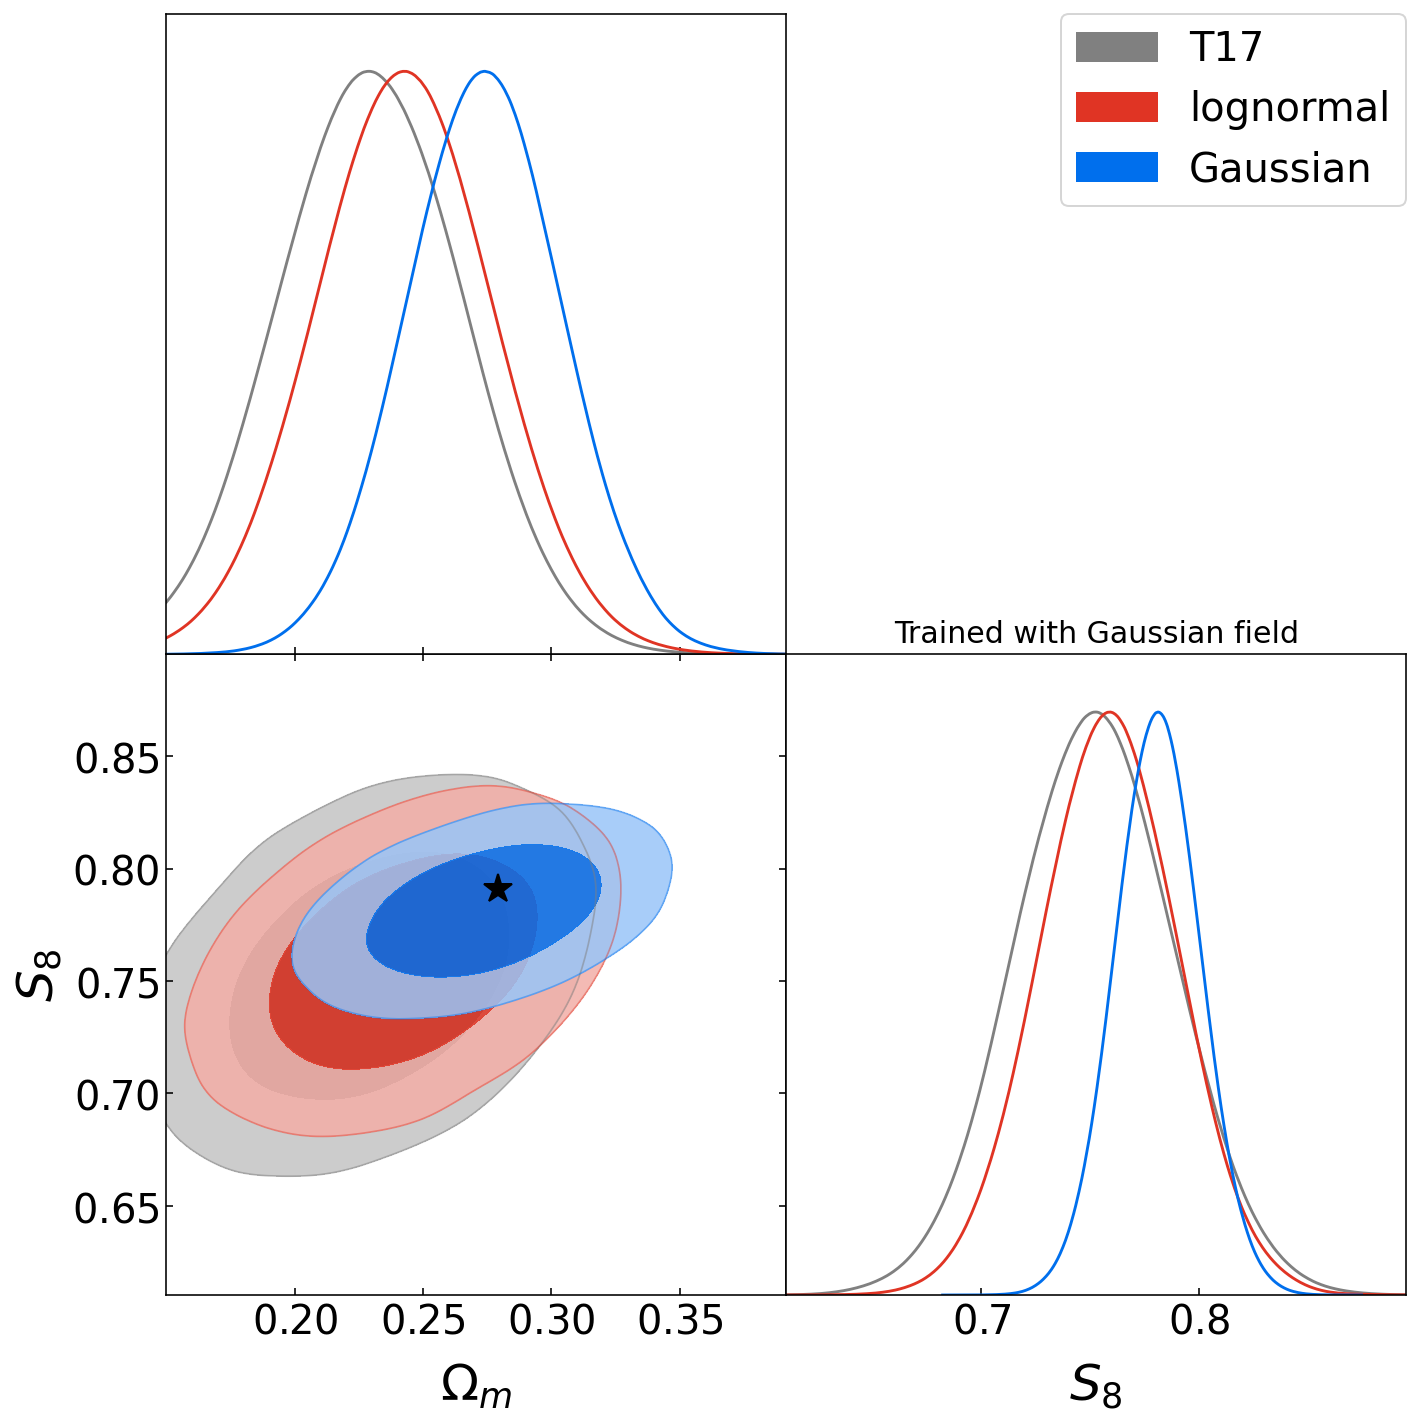

In [100]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_Gauss_mean_S_8_11, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Trained with Gaussian field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Posterior_Train_Gauss_S_8_11.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

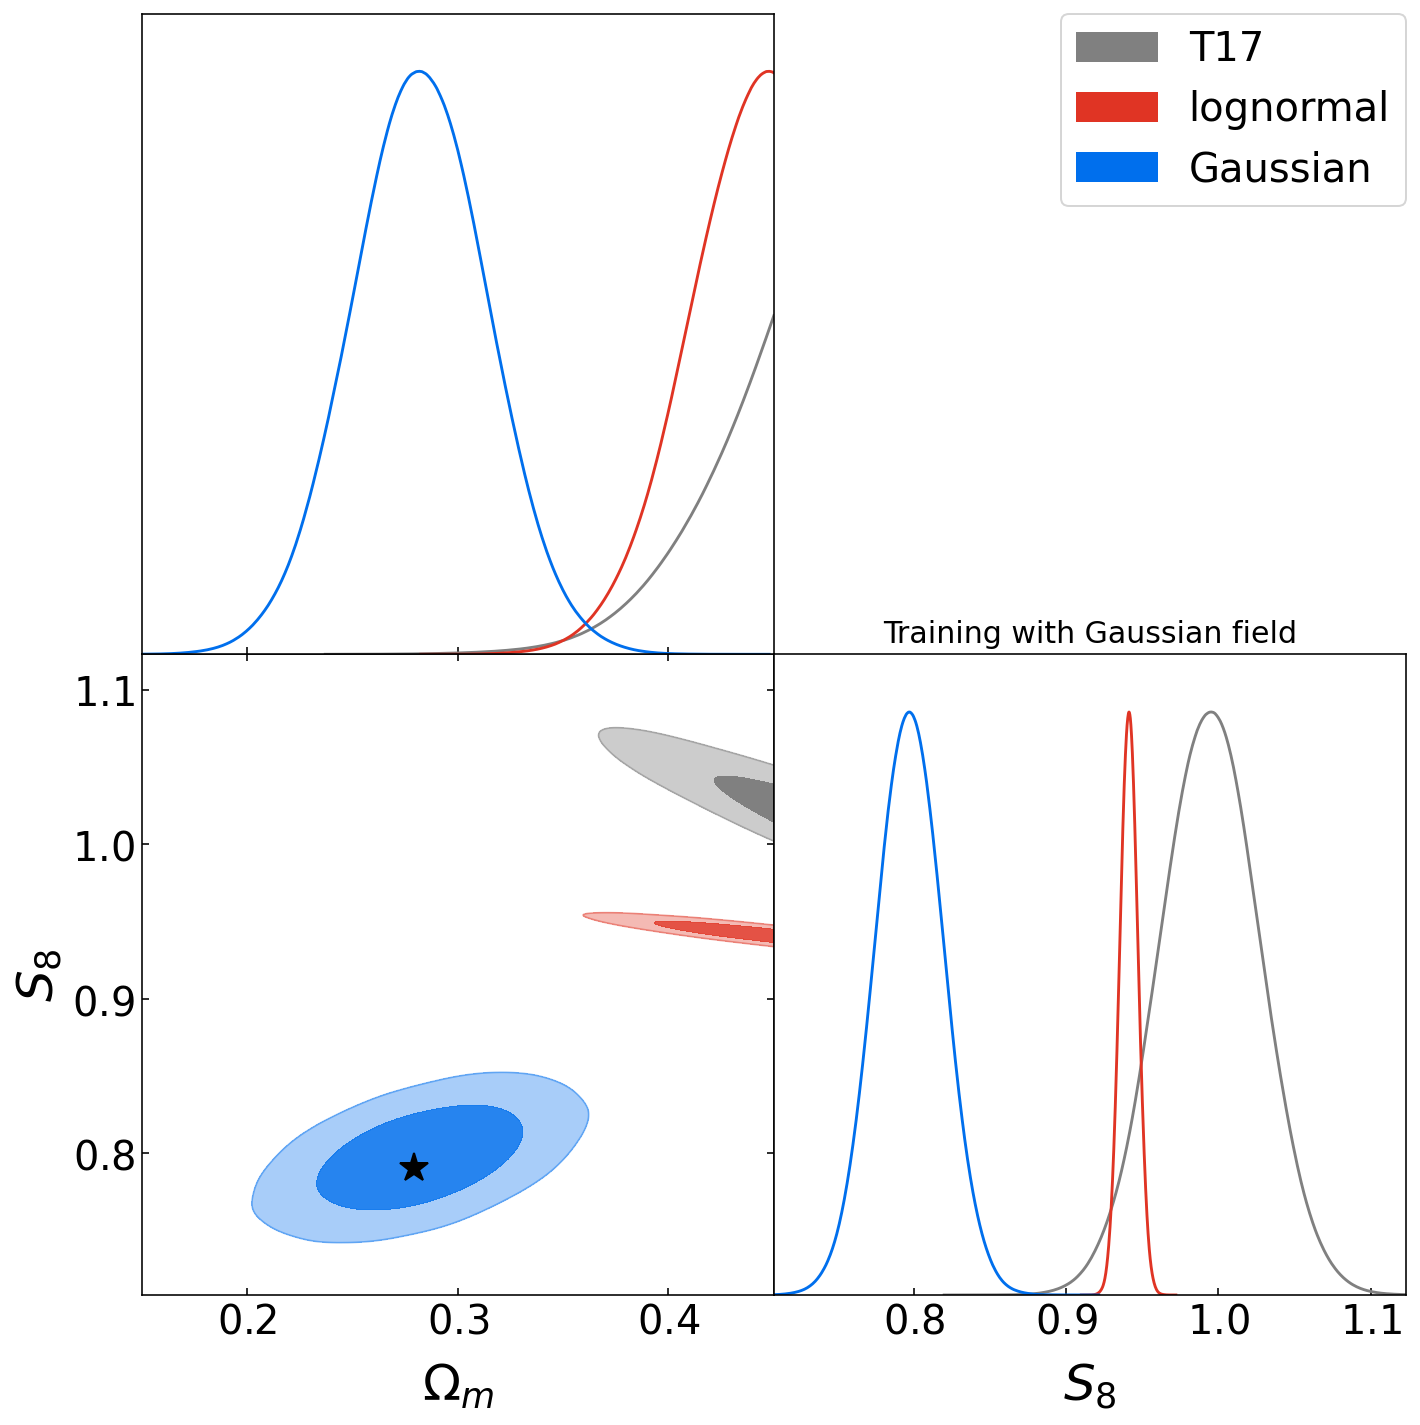

In [101]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_Gauss_mean_S_8_22, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Training with Gaussian field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_Gauss_S_8_22.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [102]:
prior_ranges = {'\Omega_m': (0.15, 0.45), 'S_8': (prior_down_S_8, prior_up_S_8)}
param_names = ['\Omega_m', 'S_8']
#T17 likelihood
nsamp = 100000
samples_T17_lognormal_1_mean_S_8                   = np.random.multivariate_normal(mu_T17_lognormal_1_S_8, cov_S8_T17_lognormal_1_mean, size=nsamp)
samples_T17_lognormal_2_mean_S_8                   = np.random.multivariate_normal(mu_T17_lognormal_2_S_8, cov_S8_T17_lognormal_2_mean, size=nsamp)
samples_Gauss_1_lognormal_1_mean_S_8               = np.random.multivariate_normal(mu_Gauss_1_lognormal_1_S_8, cov_S8_Gauss_1_lognormal_1_mean, size=nsamp)
samples_Gauss_1_lognormal_2_mean_S_8               = np.random.multivariate_normal(mu_Gauss_1_lognormal_2_S_8, cov_S8_Gauss_1_lognormal_2_mean, size=nsamp)
samples_Gauss_2_lognormal_1_mean_S_8               = np.random.multivariate_normal(mu_Gauss_2_lognormal_1_S_8, cov_S8_Gauss_2_lognormal_1_mean, size=nsamp)
samples_Gauss_2_lognormal_2_mean_S_8               = np.random.multivariate_normal(mu_Gauss_2_lognormal_2_S_8, cov_S8_Gauss_2_lognormal_2_mean, size=nsamp)
samples_lognormal_1_lognormal_1_mean_S_8           = np.random.multivariate_normal(mu_lognormal_1_lognormal_1_S_8, cov_S8_lognormal_1_lognormal_1_mean, size=nsamp)
samples_lognormal_1_lognormal_2_mean_S_8           = np.random.multivariate_normal(mu_lognormal_1_lognormal_2_S_8, cov_S8_lognormal_1_lognormal_2_mean, size=nsamp)
samples_lognormal_2_lognormal_1_mean_S_8           = np.random.multivariate_normal(mu_lognormal_2_lognormal_1_S_8, cov_S8_lognormal_2_lognormal_1_mean, size=nsamp)
samples_lognormal_2_lognormal_2_mean_S_8           = np.random.multivariate_normal(mu_lognormal_2_lognormal_2_S_8, cov_S8_lognormal_2_lognormal_2_mean, size=nsamp)
samples_T17_lognormal_1_mcsamples_mean_S_8         = MCSamples(samples=samples_T17_lognormal_1_mean_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_lognormal_2_mcsamples_mean_S_8         = MCSamples(samples=samples_T17_lognormal_2_mean_S_8, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_1_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_1_lognormal_1_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_2_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_1_lognormal_2_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_1_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_2_lognormal_1_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_2_mcsamples_mean_S_8 = MCSamples(samples=samples_lognormal_2_lognormal_2_mean_S_8, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_1_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_1_lognormal_1_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_2_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_1_lognormal_2_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_1_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_2_lognormal_1_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_2_mcsamples_mean_S_8     = MCSamples(samples=samples_Gauss_2_lognormal_2_mean_S_8, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_lognormal_mean_S_8_11 = [samples_T17_lognormal_1_mcsamples_mean_S_8, samples_lognormal_1_lognormal_1_mcsamples_mean_S_8, samples_Gauss_1_lognormal_1_mcsamples_mean_S_8]
all_samples_lognormal_mean_S_8_12 = [samples_T17_lognormal_2_mcsamples_mean_S_8, samples_lognormal_1_lognormal_2_mcsamples_mean_S_8, samples_Gauss_1_lognormal_2_mcsamples_mean_S_8]
all_samples_lognormal_mean_S_8_21 = [samples_T17_lognormal_1_mcsamples_mean_S_8, samples_lognormal_2_lognormal_1_mcsamples_mean_S_8, samples_Gauss_2_lognormal_1_mcsamples_mean_S_8]
all_samples_lognormal_mean_S_8_22 = [samples_T17_lognormal_2_mcsamples_mean_S_8, samples_lognormal_2_lognormal_2_mcsamples_mean_S_8, samples_Gauss_2_lognormal_2_mcsamples_mean_S_8]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


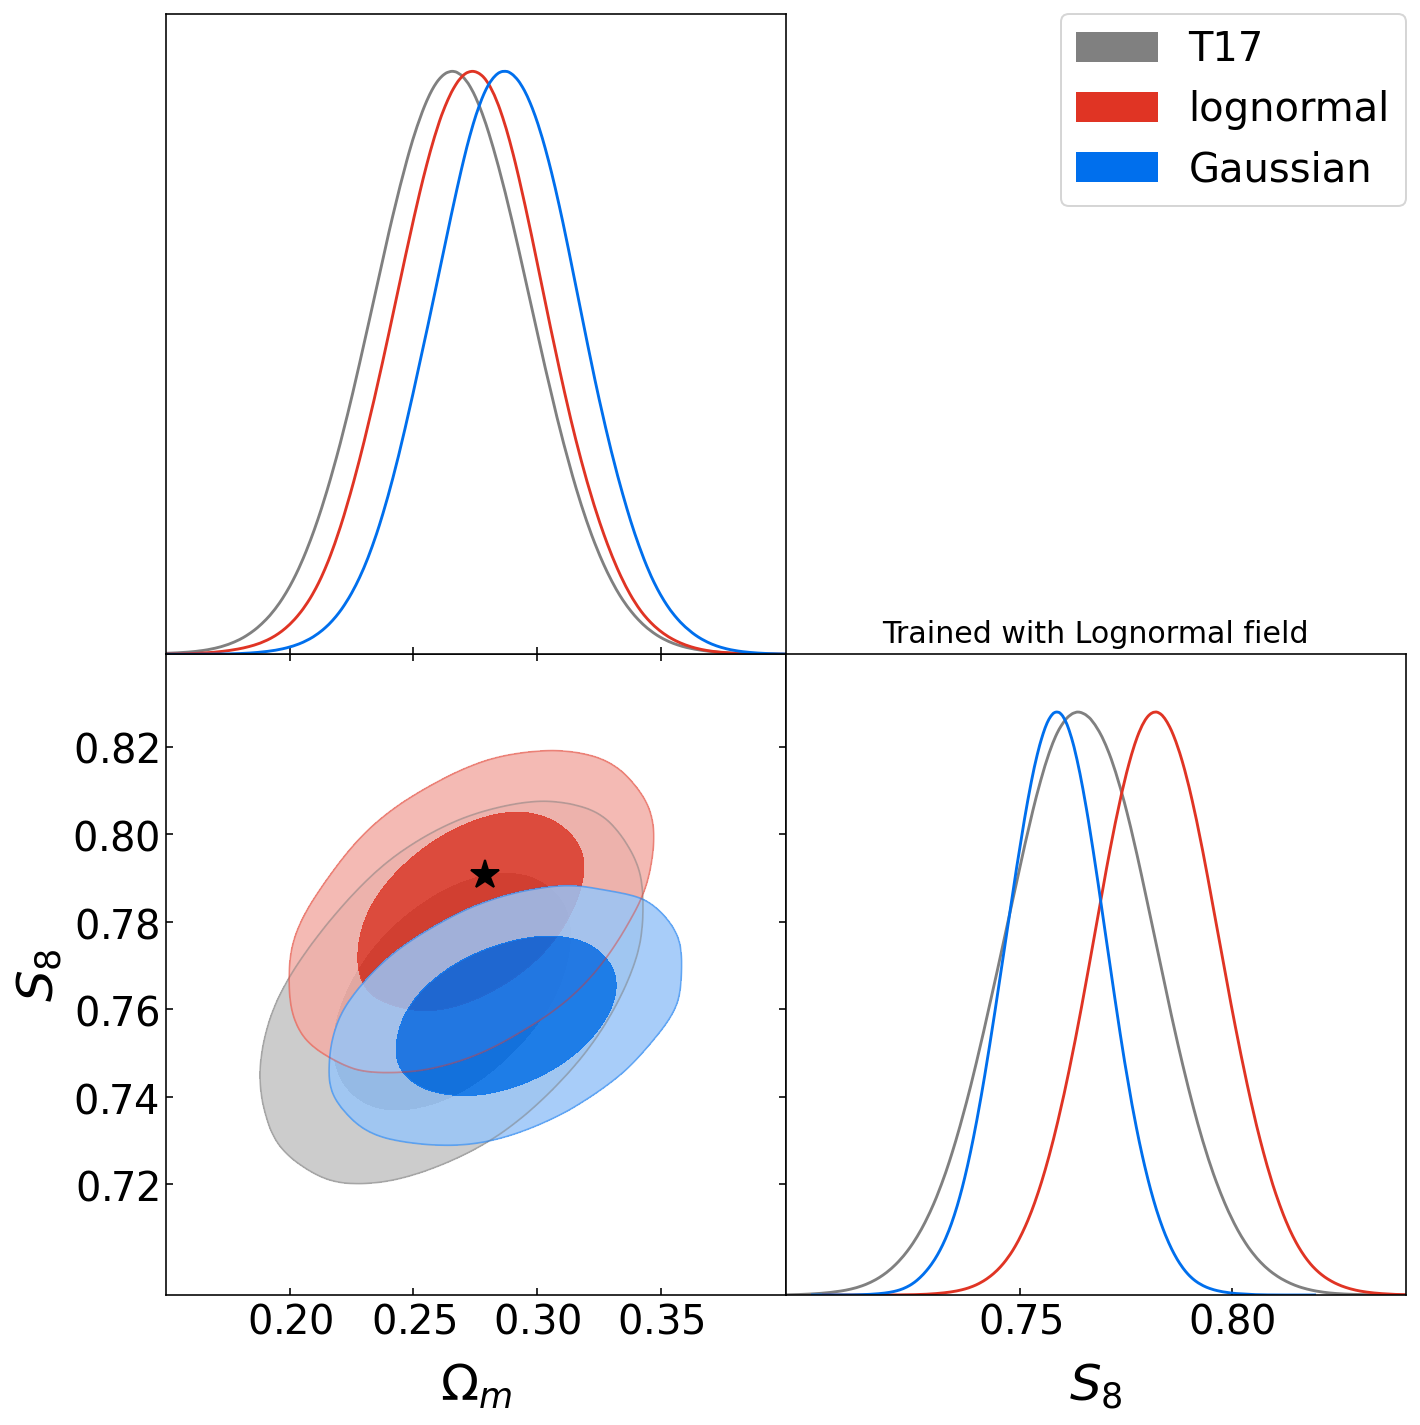

In [103]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_lognormal_mean_S_8_11, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Trained with Lognormal field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_lognormal_S_8_11.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

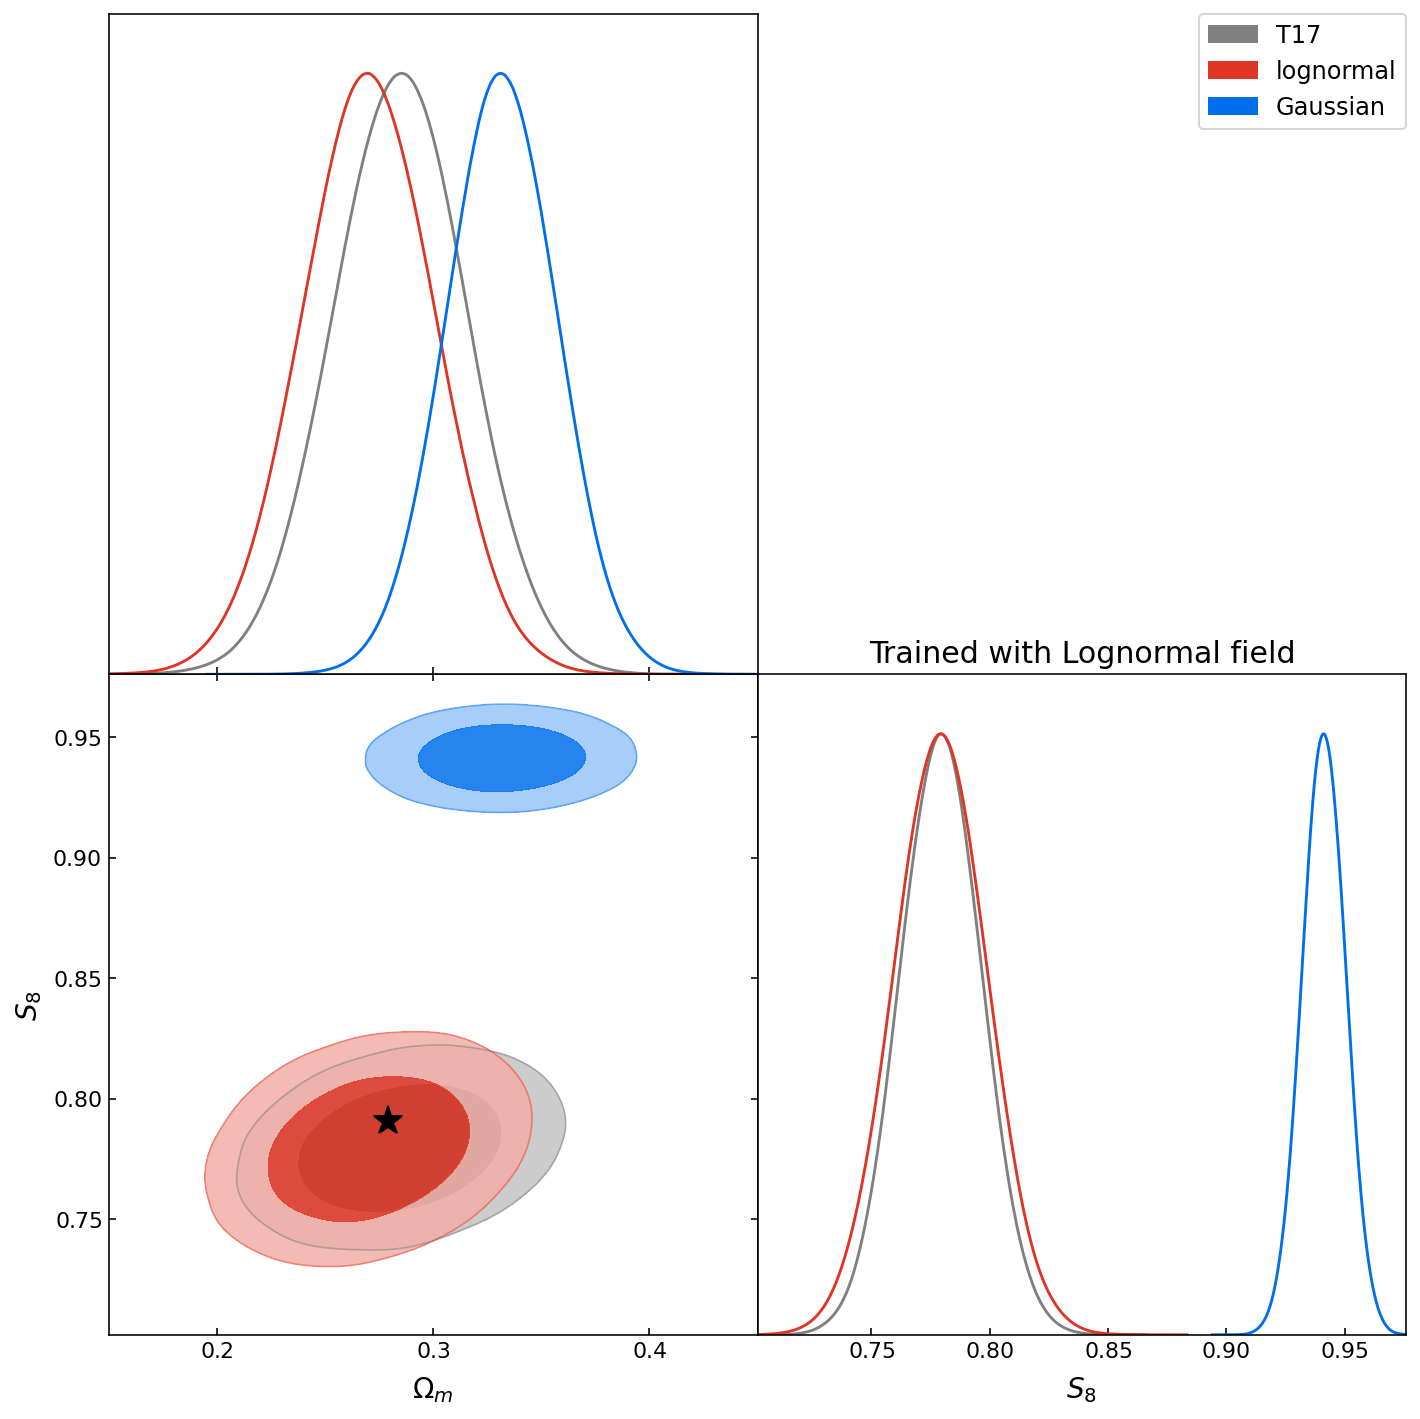

In [104]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)

# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_lognormal_mean_S_8_22, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_S_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Trained with Lognormal field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_lognormal_S_8_22.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [105]:
all_samples_cov_mean_S_8_11 = [samples_T17_Gauss_1_mcsamples_mean_S_8, samples_T17_lognormal_1_mcsamples_mean_S_8, samples_lognormal_1_Gauss_1_mcsamples_mean_S_8, samples_lognormal_1_lognormal_1_mcsamples_mean_S_8, samples_Gauss_1_Gauss_1_mcsamples_mean_S_8, samples_Gauss_1_lognormal_1_mcsamples_mean_S_8]
labels = ['Trained with Gauss, Test with T17', 'Trained with Lognormal, Test with T17','Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with Gauss']
foms_S_8_11 = []
for sample in all_samples_cov_mean_S_8_11:
    fom = figure_of_merit(sample.samples)
    foms_S_8_11.append(fom)

<Figure size 864x576 with 0 Axes>

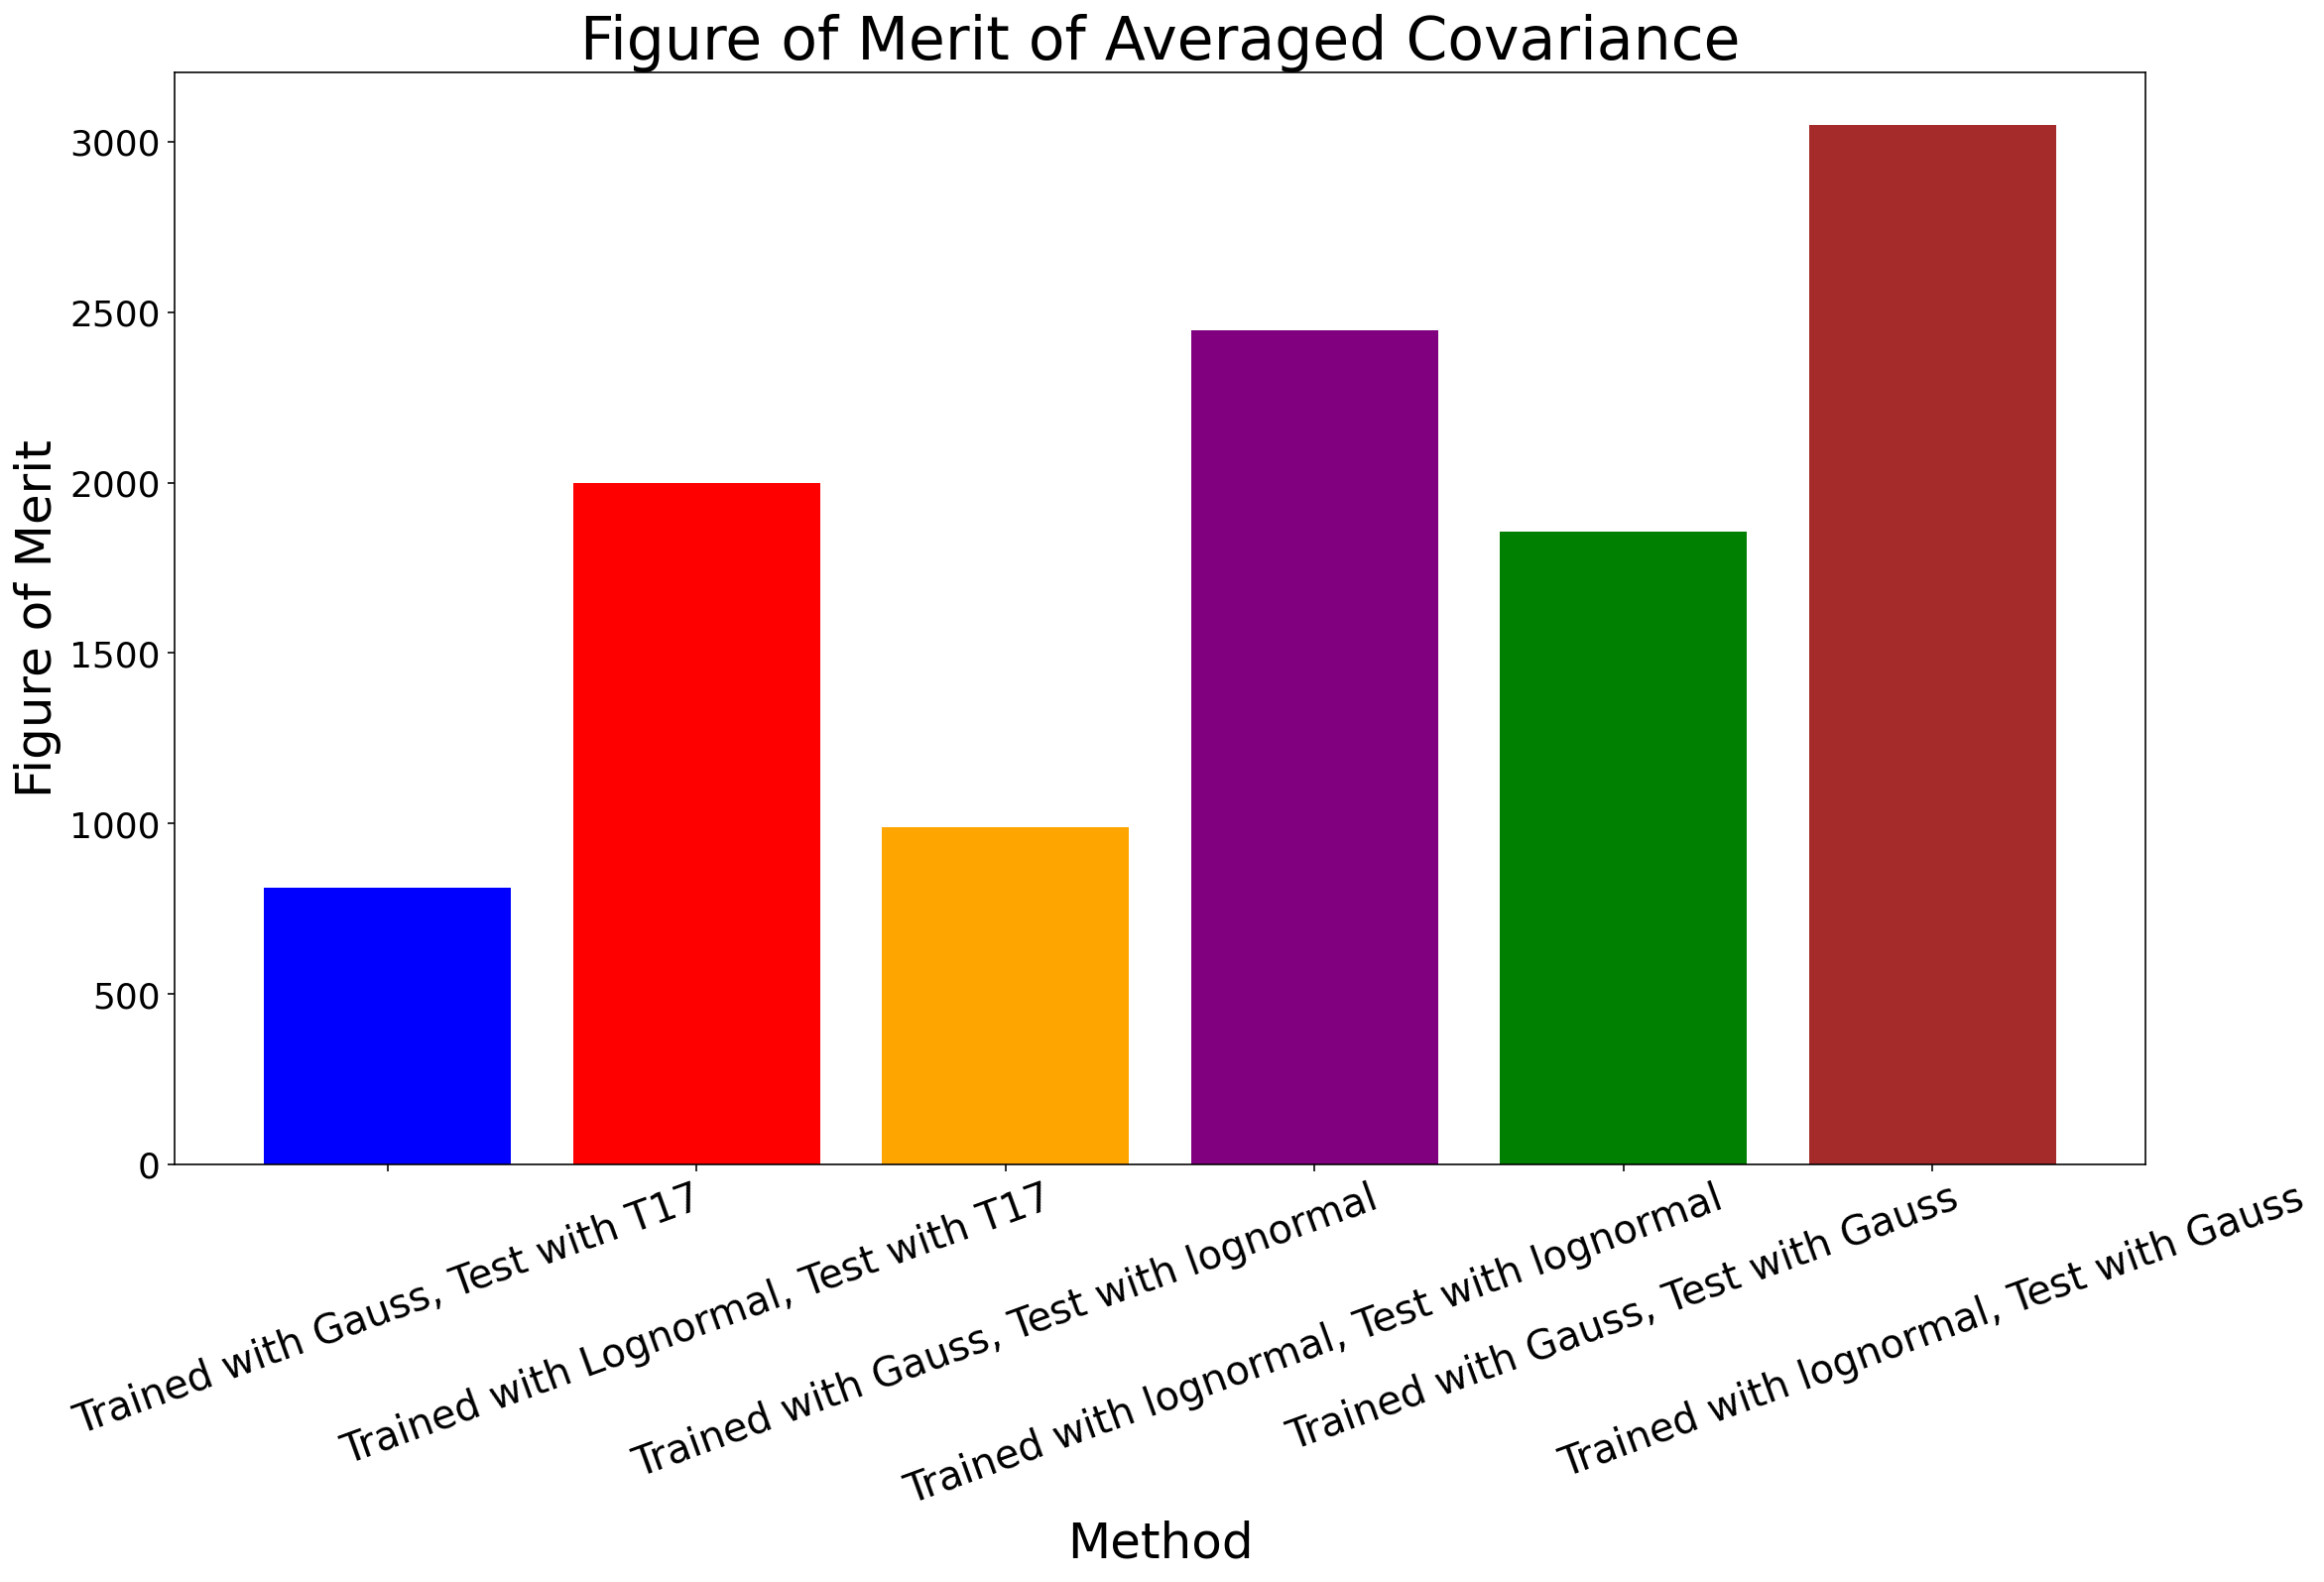

In [106]:
# Create a bar plot
plt.figure(figsize=(12, 8))
# Define custom colors for each bar
colors = ['blue', 'red', 'orange', 'purple', 'green', 'brown']

# Create a bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, foms_S_8_11, color=colors)

# Add legend with the corresponding labels
#plt.legend(bars, labels, loc='upper right', bbox_to_anchor=(1.20, 1.20))

plt.xlabel('Method', fontsize=25)
plt.ylabel('Figure of Merit', fontsize=25)
plt.title('Figure of Merit of Averaged Covariance',fontsize=30)
plt.xticks(rotation=20)
plt.tight_layout()
plt.yticks(fontsize=18)
plt.xticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/FOM_S8_11.png',bbox_inches='tight')
# Display the plot
plt.show();

In [107]:
all_samples_cov_S_8_11_KDE = [samples_T17_Gauss_1_mcsamples_KDE_S_8, samples_T17_lognormal_1_mcsamples_KDE_S_8, samples_lognormal_1_Gauss_1_mcsamples_KDE_S_8, samples_lognormal_1_lognormal_1_mcsamples_KDE_S_8, samples_Gauss_1_Gauss_1_mcsamples_KDE_S_8, samples_Gauss_1_lognormal_1_mcsamples_KDE_S_8]
labels = ['Trained with Gauss, Test with T17', 'Trained with Lognormal, Test with T17','Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with Gauss']
foms_S_8_11_KDE = []
for sample in all_samples_cov_S_8_11_KDE:
    fom = figure_of_merit(sample.samples)
    foms_S_8_11_KDE.append(fom)

<Figure size 864x576 with 0 Axes>

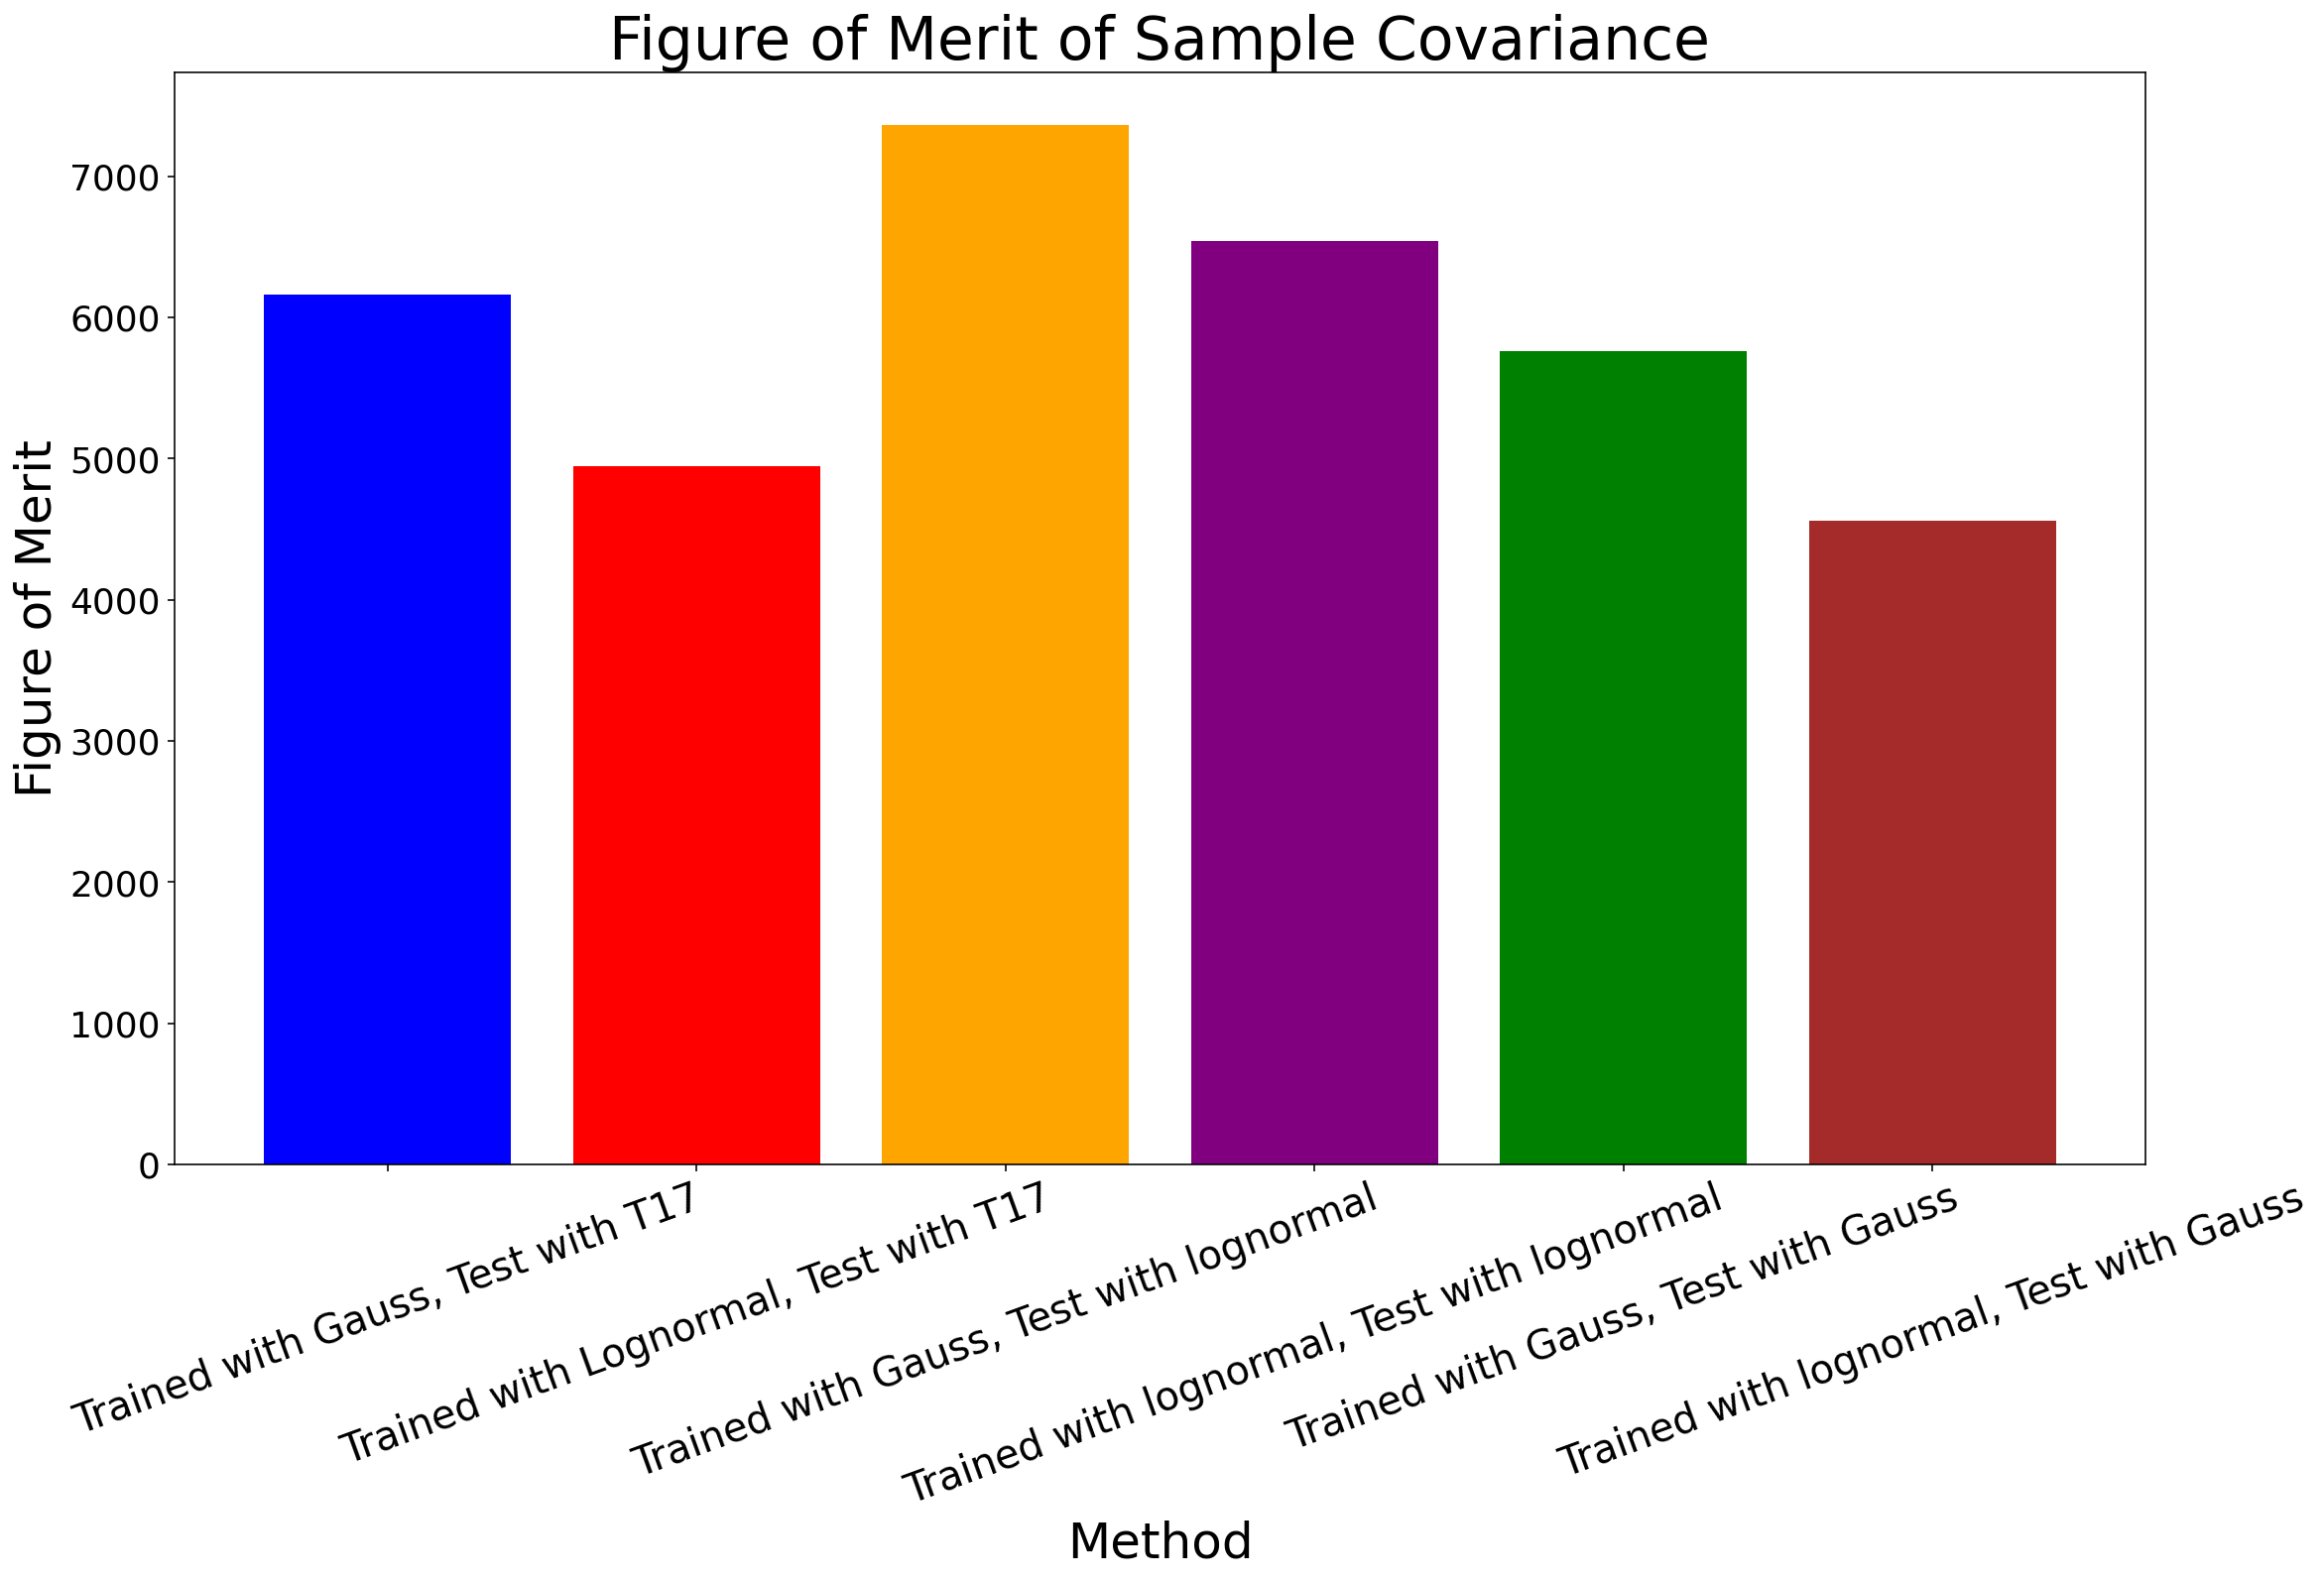

In [108]:
# Create a bar plot
plt.figure(figsize=(12, 8))
# Define custom colors for each bar
colors = ['blue', 'red', 'orange', 'purple', 'green', 'brown']

# Create a bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, foms_S_8_11_KDE, color=colors)

# Add legend with the corresponding labels
#plt.legend(bars, labels, loc='upper right', bbox_to_anchor=(1.20, 1.20))

plt.xlabel('Method', fontsize=25)
plt.ylabel('Figure of Merit', fontsize=25)
plt.title('Figure of Merit of Sample Covariance',fontsize=30)
plt.xticks(rotation=20)
plt.tight_layout()
plt.yticks(fontsize=18)
plt.xticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/FOM_S8_11_KDE.jpg',bbox_inches='tight')
# Display the plot
plt.show();

<Figure size 864x576 with 0 Axes>

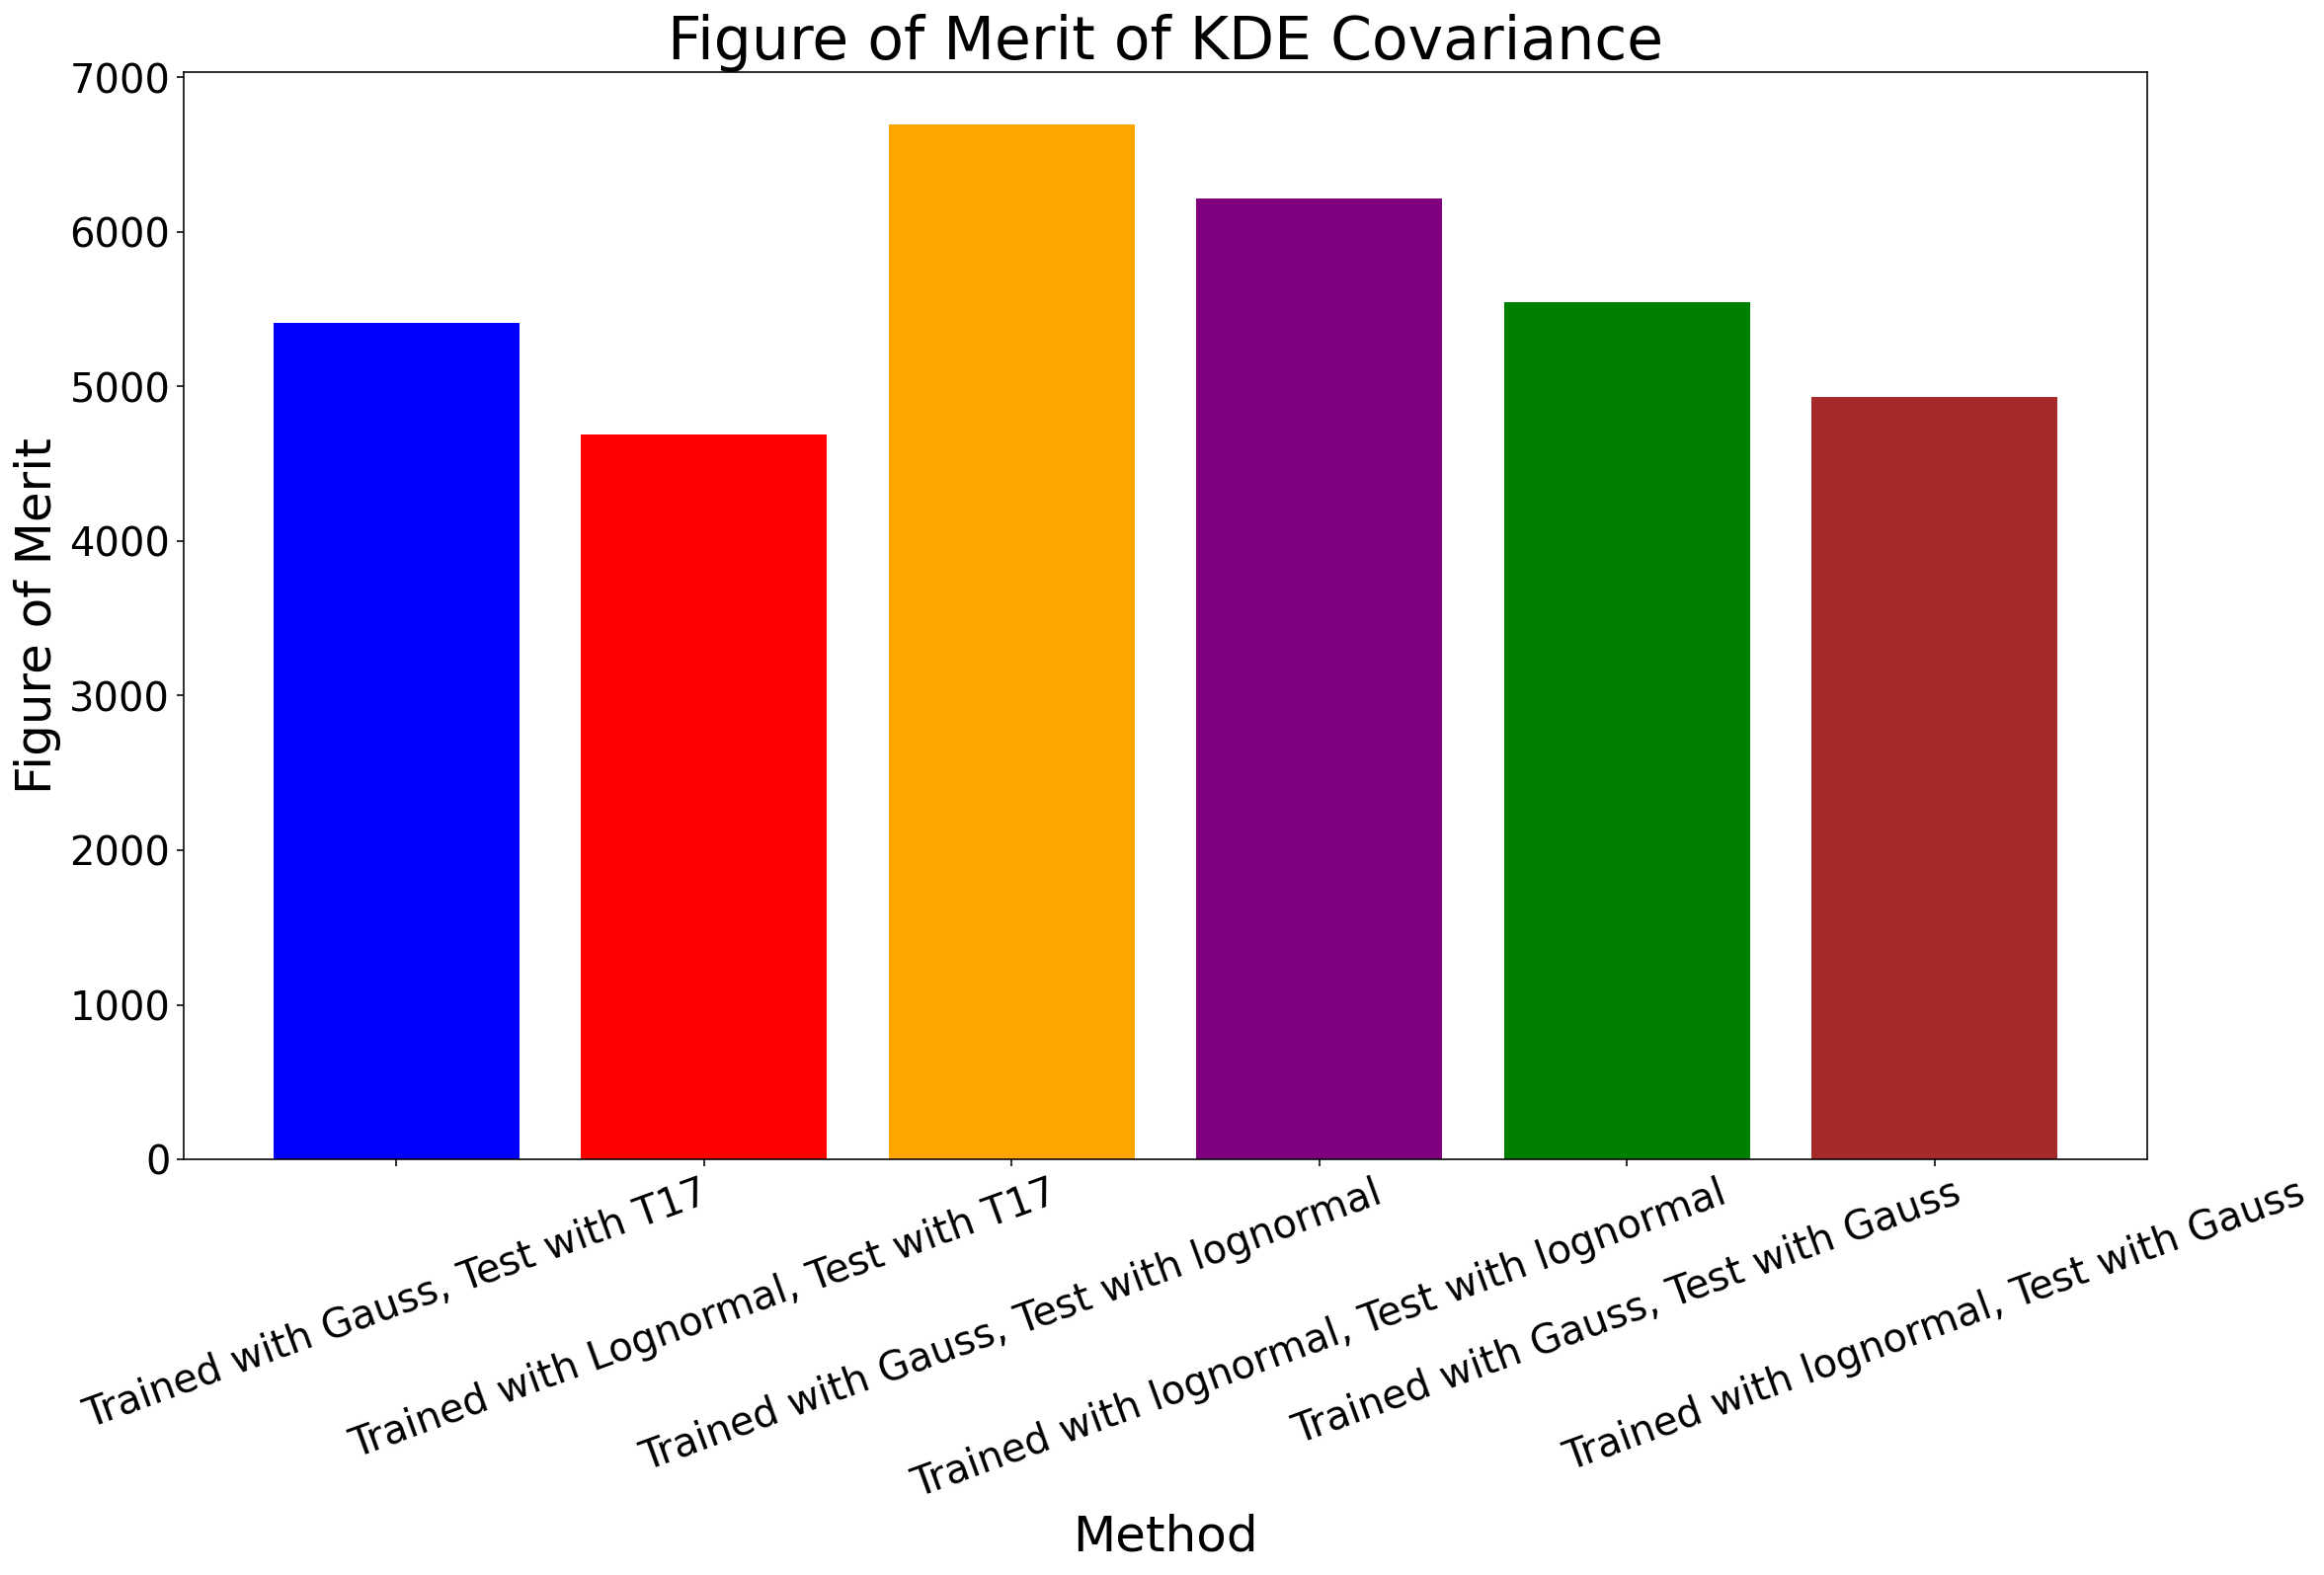

In [109]:
# Create a bar plot
plt.figure(figsize=(12, 8))
# Define custom colors for each bar
colors = ['blue', 'red', 'orange', 'purple', 'green', 'brown']

# Create a bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, foms_KDE_11, color=colors)

# Add legend with the corresponding labels
#plt.legend(bars, labels, loc='upper right', bbox_to_anchor=(1.20, 1.20))

plt.xlabel('Method', fontsize=25)
plt.ylabel('Figure of Merit', fontsize=25)
plt.title('Figure of Merit of KDE Covariance',fontsize=30)
plt.xticks(rotation=20)
plt.tight_layout()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/FOM_KDE_11.png',bbox_inches='tight')
# Display the plot
plt.show();

In [110]:
all_samples_cov_mean_S_8_22 = [samples_T17_Gauss_2_mcsamples_mean_S_8, samples_T17_lognormal_2_mcsamples_mean_S_8, samples_lognormal_2_Gauss_2_mcsamples_mean_S_8, samples_lognormal_2_lognormal_2_mcsamples_mean_S_8, samples_Gauss_2_Gauss_2_mcsamples_mean_S_8, samples_Gauss_2_lognormal_2_mcsamples_mean_S_8]
labels = ['Trained with Gauss, Test with T17', 'Trained with Lognormal, Test with T17','Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with Gauss']
foms = []
for sample in all_samples_cov_mean_22:
    fom = figure_of_merit(sample.samples)
    foms.append(fom)

<Figure size 864x576 with 0 Axes>

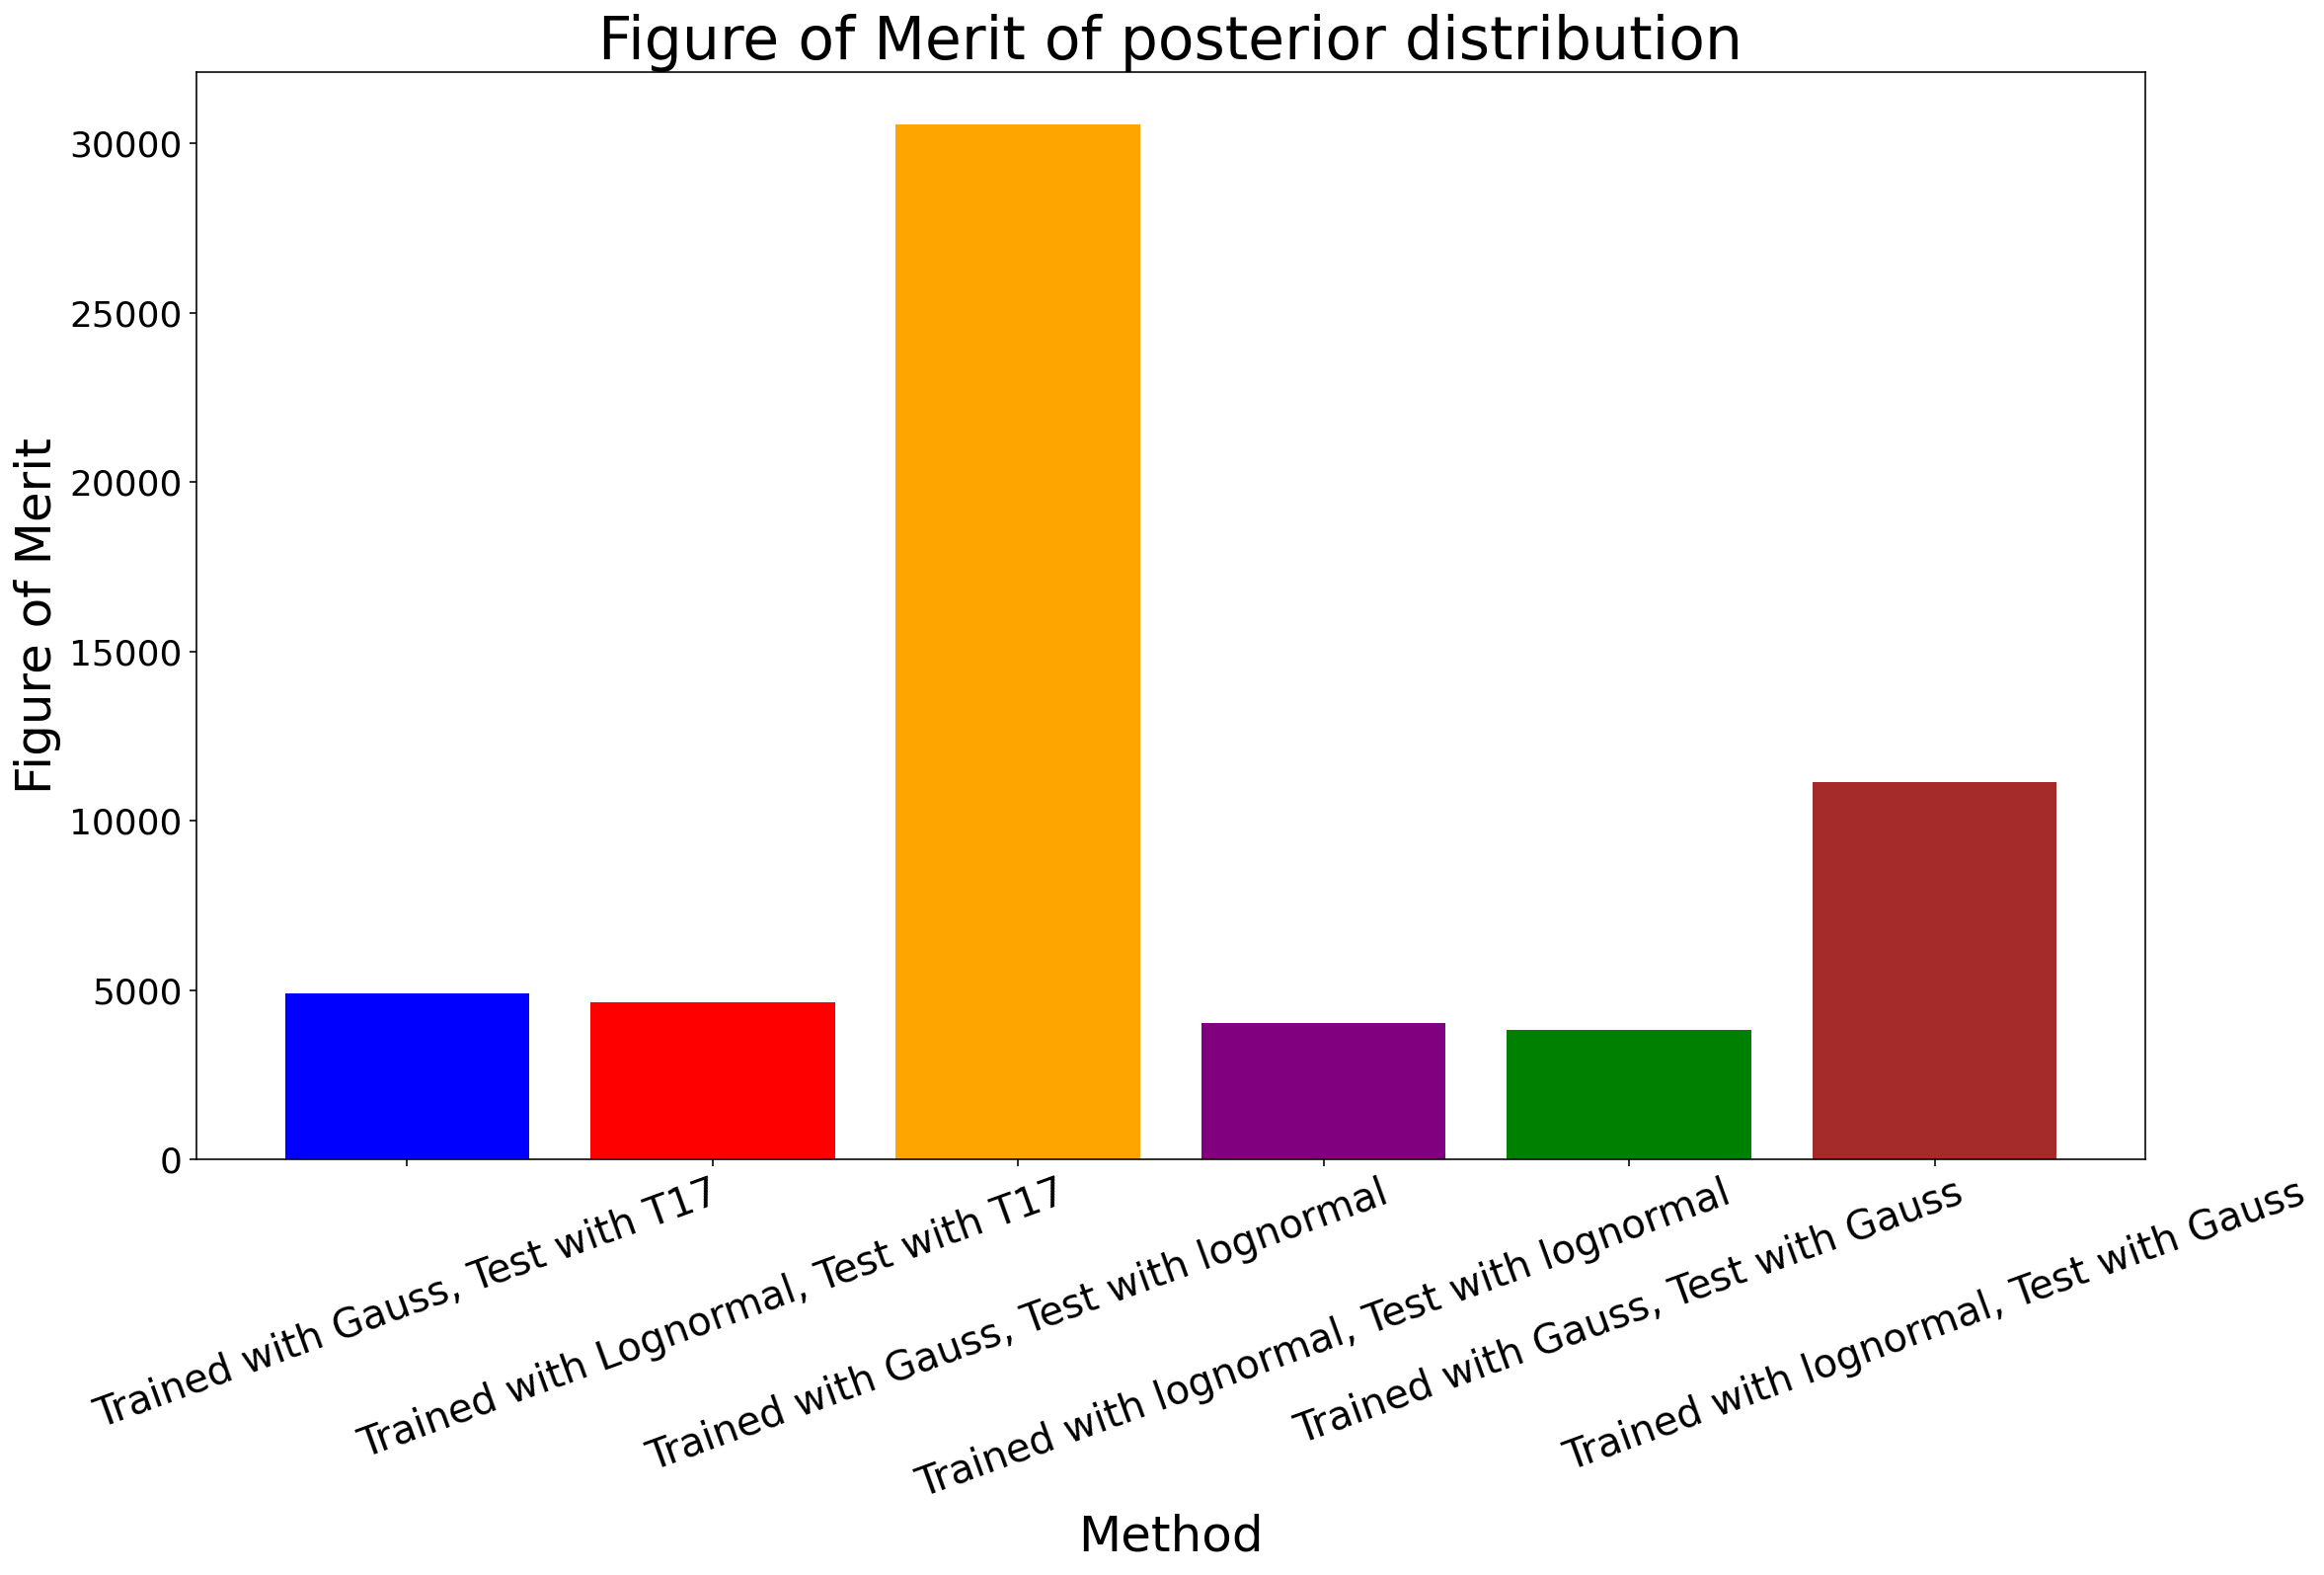

In [111]:
# Create a bar plot
plt.figure(figsize=(12, 8))
# Define custom colors for each bar
colors = ['blue', 'red', 'orange', 'purple', 'green', 'brown']

# Create a bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, foms, color=colors)

# Add legend with the corresponding labels
#plt.legend(bars, labels, loc='upper right', bbox_to_anchor=(1.20, 1.20))

plt.xlabel('Method', fontsize=25)
plt.ylabel('Figure of Merit', fontsize=25)
plt.title('Figure of Merit of posterior distribution',fontsize=30)
plt.xticks(rotation=20)
plt.tight_layout()
plt.yticks(fontsize=18)
plt.xticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/FOM_S8_22.png',bbox_inches='tight')
# Display the plot
plt.show();